In [6]:
#load in packages and initial config
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from sklearn.linear_model import LinearRegression
import warnings
from matplotlib.gridspec import GridSpec
import scipy.stats as stats
from sklearn import linear_model
import seaborn as sns
import tkinter as tk 
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from numpy import *
from scipy.interpolate import *
import statsmodels.api as sm
import plotly
import plotly.express as px
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from geopandas import GeoDataFrame
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as offline
import plotly.figure_factory as ff
from plotly.graph_objs import *
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import os
from datetime import datetime, timedelta
%matplotlib inline
init_notebook_mode(connected=True)
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 20)

In [7]:
dpdcalls = gpd.read_file('/Users/erikrobertsson/Documents/dataplus/dpdshapefilelatlong/dpdshapefilelatlong.shp')
dpdcalls = dpdcalls.loc[~(dpdcalls["X"] == 0) & ~(dpdcalls["Y"] == 0)].copy()
dpdcalls = dpdcalls.loc[dpdcalls["Source"] != "Self Initiated"].copy()
dpdcalls = dpdcalls.loc[dpdcalls["Cancelled"] == 0].copy()
dpdcalls = dpdcalls.loc[(dpdcalls["Beat"] != "DSO") & (dpdcalls["Beat"] != "SSA")].copy()
dpdcalls = dpdcalls.loc[dpdcalls["Nature"] != "HANG UP"].copy()
dpdcalls = dpdcalls.loc[(dpdcalls["Nature"] != "HANG UP WIRELESS PHASE 1") & (dpdcalls["Nature"] != "0") & (dpdcalls["Nature"] != "16") & (dpdcalls["Nature"] != "DIRECTED PATROL") & (dpdcalls["Nature"] != "NO apt # or phone") & (dpdcalls["Nature"] != "\\") & (dpdcalls["Nature"] != "VIN: JHMFA36226S011840 not sto") & (dpdcalls["Nature"] != "DISy") & (dpdcalls["Nature"] != "VEr") & (dpdcalls["Nature"] != "DIST") & (dpdcalls['Nature'] != 'HANG UP WIRELESS PHASE 2')].copy()
dpdcalls.rename(columns = {'Call Time':'time'}, inplace = True)
twotosix = ['2', '3', '4', '5', '6']
dpdcalls = dpdcalls[dpdcalls['Priority'].isin(twotosix)].copy()
nature_list = ['WELFARE CHECK', 'URGENT WELFARE CHECK', 'PANHANDLING OR NUISANCE', 'VERBAL DISTURBANCE', 'SUICIDE THREAT', 'MENTAL DISORDER', 'TRESPASS OR UNWANTED', 'INTOXICATED PERSON', 'ASSIST PERSON', 'CRISIS']
dpdcalls = dpdcalls[dpdcalls['Nature'].isin(nature_list)].copy()
dpdcalls24hour = dpdcalls.copy()
dpdcalls24hour['time'] = dpdcalls24hour['time'].str[:2] + dpdcalls24hour['time'].str[-2:]
dpdcalls24hour['time'] = dpdcalls24hour['time'].astype("string")
dpdcalls

Event Numb Case Numbe   Call Date        time             Source  \
70        21000113       None    1/1/2021  12:41:03AM  Wireless 911 Call   
71        21000114       None    1/1/2021  12:41:53AM  Wireless 911 Call   
74        21000119       None    1/1/2021  12:44:24AM              E-911   
114       21000186       None    1/1/2021   1:19:04AM              E-911   
189       21000338       None    1/1/2021   4:26:38AM  Wireless 911 Call   
...            ...        ...         ...         ...                ...   
278107    21478051       None  12/31/2021   8:29:54PM              E-911   
278116    21478064       None  12/31/2021   8:36:46PM  Wireless 911 Call   
278155    21478122       None  12/31/2021   9:21:17PM         Phone Call   
278215    21478215       None  12/31/2021  10:36:21PM  Wireless 911 Call   
278271    21478336       None  12/31/2021  11:51:01PM  Wireless 911 Call   

       Priority                Nature                Address        X       Y  \
70            2  TRESPASS OR UNWANTED          2300 GUESS RD  2022916  828272   
71            3                CRISIS             0 HAYTI LN  2030397  813534   
74            3         WELFARE CHECK          500 E MAIN ST  2031074  816191   
114           3  TRESPASS OR UNWANTED      2100 N ROXBORO ST  2032434  825627   
189           3                CRISIS        200 N DRIVER ST  2036165  814339   
...         ...                   ...                    ...      ...     ...   
278107        3  TRESPASS OR UNWANTED   3400 HILLSBOROUGH RD  2015445  826468   
278116        3  TRESPASS OR UNWANTED         700 LINDLEY DR  2045812  810608   
278155        2  URGENT WELFARE CHECK   600 W CHAPEL HILL ST  2026386  817495   
278215        2        SUICIDE THREAT    200 N BUCHANAN BLVD  2026005  820358   
278271        3  TRESPASS OR UNWANTED  1600 T W ALEXANDER DR  2045831  791379   

       District Beat               Dispositio  Cancelled  \
70           D2  211  Resolved Without Report          0   
71           D4  411  Resolved Without Report          0   
74           D5  513  Resolved Without Report          0   
114          D2  213  Resolved Without Report          0   
189          D1  113  Resolved Without Report          0   
...         ...  ...                      ...        ...   
278107       D2  221  Resolved Without Report          0   
278116       D1  114  Resolved Without Report          0   
278155       D5  511  Resolved Without Report          0   
278215       D2  212  Resolved Without Report          0   
278271       D4  423                Unfounded          0   

                          geometry  
70      POINT (-78.92250 36.02572)  
71      POINT (-78.89725 35.98522)  
74      POINT (-78.89496 35.99252)  
114     POINT (-78.89032 36.01843)  
189     POINT (-78.87775 35.98741)  
...                            ...  
278107  POINT (-78.94777 36.02078)  
278116  POINT (-78.84517 35.97713)  
278155  POINT (-78.91080 35.99611)  
278215  POINT (-78.91208 36.00398)  
278271  POINT (-78.84520 35.92430)  

[14757 rows x 15 columns]

In [8]:
dpdcallsdate = dpdcalls.copy()
dpdcallsdate['DATE'] = pd.to_datetime(dpdcallsdate['Call Date'],format="%m/%d/%Y")
dpdcalls2021date = dpdcallsdate.copy()
dpdcallsdate['YEAR'] = pd.DatetimeIndex(dpdcallsdate['DATE']).year
dpdcallsdate['MONTH'] = pd.DatetimeIndex(dpdcallsdate['DATE']).month
dpdcallsdate['DAY'] = pd.DatetimeIndex(dpdcallsdate['DATE']).day
dpdcallsdate['DAY_OF_WEEK'] = dpdcallsdate['DATE'].dt.dayofweek
dpdcallsdate.drop('Call Date', axis=1, inplace=True)
dpdcallsdate

Event Numb Case Numbe        time             Source Priority  \
70        21000113       None  12:41:03AM  Wireless 911 Call        2   
71        21000114       None  12:41:53AM  Wireless 911 Call        3   
74        21000119       None  12:44:24AM              E-911        3   
114       21000186       None   1:19:04AM              E-911        3   
189       21000338       None   4:26:38AM  Wireless 911 Call        3   
...            ...        ...         ...                ...      ...   
278107    21478051       None   8:29:54PM              E-911        3   
278116    21478064       None   8:36:46PM  Wireless 911 Call        3   
278155    21478122       None   9:21:17PM         Phone Call        2   
278215    21478215       None  10:36:21PM  Wireless 911 Call        2   
278271    21478336       None  11:51:01PM  Wireless 911 Call        3   

                      Nature                Address        X       Y District  \
70      TRESPASS OR UNWANTED          2300 GUESS RD  2022916  828272       D2   
71                    CRISIS             0 HAYTI LN  2030397  813534       D4   
74             WELFARE CHECK          500 E MAIN ST  2031074  816191       D5   
114     TRESPASS OR UNWANTED      2100 N ROXBORO ST  2032434  825627       D2   
189                   CRISIS        200 N DRIVER ST  2036165  814339       D1   
...                      ...                    ...      ...     ...      ...   
278107  TRESPASS OR UNWANTED   3400 HILLSBOROUGH RD  2015445  826468       D2   
278116  TRESPASS OR UNWANTED         700 LINDLEY DR  2045812  810608       D1   
278155  URGENT WELFARE CHECK   600 W CHAPEL HILL ST  2026386  817495       D5   
278215        SUICIDE THREAT    200 N BUCHANAN BLVD  2026005  820358       D2   
278271  TRESPASS OR UNWANTED  1600 T W ALEXANDER DR  2045831  791379       D4   

       Beat               Dispositio  Cancelled                    geometry  \
70      211  Resolved Without Report          0  POINT (-78.92250 36.02572)   
71      411  Resolved Without Report          0  POINT (-78.89725 35.98522)   
74      513  Resolved Without Report          0  POINT (-78.89496 35.99252)   
114     213  Resolved Without Report          0  POINT (-78.89032 36.01843)   
189     113  Resolved Without Report          0  POINT (-78.87775 35.98741)   
...     ...                      ...        ...                         ...   
278107  221  Resolved Without Report          0  POINT (-78.94777 36.02078)   
278116  114  Resolved Without Report          0  POINT (-78.84517 35.97713)   
278155  511  Resolved Without Report          0  POINT (-78.91080 35.99611)   
278215  212  Resolved Without Report          0  POINT (-78.91208 36.00398)   
278271  423                Unfounded          0  POINT (-78.84520 35.92430)   

             DATE  YEAR  MONTH  DAY  DAY_OF_WEEK  
70     2021-01-01  2021      1    1            4  
71     2021-01-01  2021      1    1            4  
74     2021-01-01  2021      1    1            4  
114    2021-01-01  2021      1    1            4  
189    2021-01-01  2021      1    1            4  
...           ...   ...    ...  ...          ...  
278107 2021-12-31  2021     12   31            4  
278116 2021-12-31  2021     12   31            4  
278155 2021-12-31  2021     12   31            4  
278215 2021-12-31  2021     12   31            4  
278271 2021-12-31  2021     12   31            4  

[14757 rows x 19 columns]

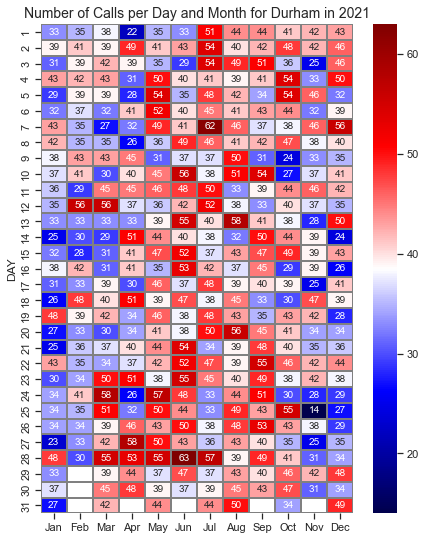

In [9]:
calls_pivot_table = dpdcallsdate[(dpdcallsdate['DATE'] != '2005-06-15')].pivot_table(values='YEAR', index='DAY', columns='MONTH', aggfunc=len)
calls_pivot_table_year_count = dpdcallsdate[(dpdcallsdate['DATE'] != '2005-06-15')].pivot_table(values='YEAR', index='DAY', columns='MONTH', aggfunc=lambda x: len(x.unique()))
calls_average = calls_pivot_table/calls_pivot_table_year_count
calls_average.columns = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

# Using seaborn heatmap
plt.figure(figsize=(7,9))
plt.title('Number of Calls per Day and Month for Durham in 2021', fontsize=14)
sns.heatmap(calls_average.round(), cmap='seismic', linecolor='grey',linewidths=0.1, cbar=True, annot=True, fmt=".0f");


In [10]:
dpdcallsdate['Nature'].value_counts().sort_index()


ASSIST PERSON              3060
CRISIS                     1323
INTOXICATED PERSON          440
MENTAL DISORDER              19
PANHANDLING OR NUISANCE     787
SUICIDE THREAT              583
TRESPASS OR UNWANTED       4941
URGENT WELFARE CHECK       1950
WELFARE CHECK              1654
Name: Nature, dtype: int64

In [11]:
def category(dpdcallsdate_nature):
    if 'CRISIS' in dpdcallsdate_nature:
        return 'CRISIS'
    elif 'MENTAL DISORDER' in dpdcallsdate_nature:
        return 'MENTAL DISORDER'
    elif 'SUICIDE THREAT' in dpdcallsdate_nature:
        return 'SUICIDE THREAT'

In [12]:
def category2(dpdcallsdate_nature):
    if 'INTOXICATED PERSON' in dpdcallsdate_nature:
        return 'INTOXICATED PERSON'
    elif 'PANHANDLING OR NUISANCE' in dpdcallsdate_nature:
        return 'PANHANDLING OR NUISANCE'
    elif 'TRESPASS OR UNWANTED' in dpdcallsdate_nature:
        return 'TRESPASS OR UNWANTED'

In [13]:
def category3(dpdcallsdate_nature):
    if 'ASSIST PERSON' in dpdcallsdate_nature:
        return 'ASSIST PERSON'
    elif 'URGENT WELFARE CHECK' in dpdcallsdate_nature:
        return 'URGENT WELFARE CHECK'
    elif 'WELFARE CHECK' in dpdcallsdate_nature:
        return 'WELFARE CHECK'

In [14]:
dpdcallsdate['CATEGORY'] = dpdcallsdate['Nature'].apply(category)

In [15]:
dpdcallsdate['CATEGORY2'] = dpdcallsdate['Nature'].apply(category2)

In [16]:
dpdcallsdate['CATEGORY3'] = dpdcallsdate['Nature'].apply(category3)

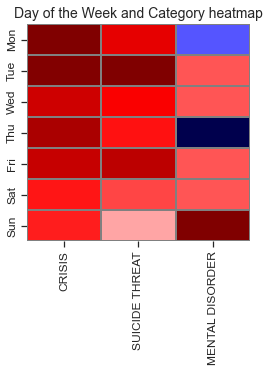

In [17]:
calls_pivot_table = dpdcallsdate.pivot_table(values='Nature', index='CATEGORY', columns='DAY_OF_WEEK', aggfunc=len)

# To compare categories, I'm scaling each category by diving by the max value of each one
calls_scaled = pd.DataFrame(calls_pivot_table.iloc[0] / calls_pivot_table.iloc[0].max())

# Using a for loop to scale others
for i in [2,1]:
    calls_scaled[calls_pivot_table.index[i]] =  pd.DataFrame(calls_pivot_table.iloc[i] / calls_pivot_table.iloc[i].max())
    
calls_scaled.index = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
                    
# Using seaborn heatmap
plt.figure(figsize=(4,4))
plt.title('Day of the Week and Category heatmap', fontsize=14)
plt.tick_params(labelsize=12)
sns.heatmap(calls_scaled, cmap='seismic', linecolor='grey',linewidths=0.1, cbar=False);

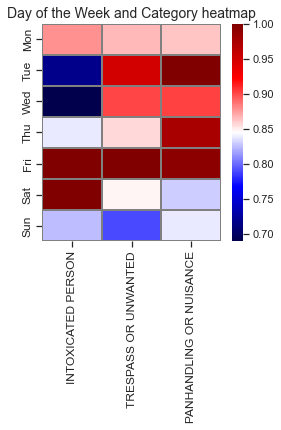

In [18]:
calls_pivot_table = dpdcallsdate.pivot_table(values='Nature', index='CATEGORY2', columns='DAY_OF_WEEK', aggfunc=len)

# To compare categories, I'm scaling each category by diving by the max value of each one
calls_scaled = pd.DataFrame(calls_pivot_table.iloc[0] / calls_pivot_table.iloc[0].max())

# Using a for loop to scale others
for i in [2,1]:
    calls_scaled[calls_pivot_table.index[i]] =  pd.DataFrame(calls_pivot_table.iloc[i] / calls_pivot_table.iloc[i].max())
    
calls_scaled.index = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
                    
# Using seaborn heatmap
plt.figure(figsize=(4,4))
plt.title('Day of the Week and Category heatmap', fontsize=14)
plt.tick_params(labelsize=12)
sns.heatmap(calls_scaled, cmap='seismic', linecolor='grey',linewidths=0.1, cbar=True);


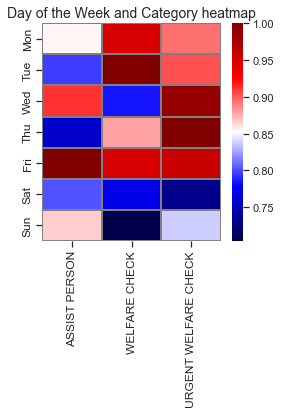

In [19]:
calls_pivot_table = dpdcallsdate.pivot_table(values='Nature', index='CATEGORY3', columns='DAY_OF_WEEK', aggfunc=len)

# To compare categories, I'm scaling each category by diving by the max value of each one
calls_scaled = pd.DataFrame(calls_pivot_table.iloc[0] / calls_pivot_table.iloc[0].max())

# Using a for loop to scale others
for i in [2,1]:
    calls_scaled[calls_pivot_table.index[i]] =  pd.DataFrame(calls_pivot_table.iloc[i] / calls_pivot_table.iloc[i].max())
    
calls_scaled.index = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
                    
# Using seaborn heatmap
plt.figure(figsize=(4,4))
plt.title('Day of the Week and Category heatmap', fontsize=14)
plt.tick_params(labelsize=12)
sns.heatmap(calls_scaled, cmap='seismic', linecolor='grey',linewidths=0.1, cbar=True);

In [20]:
monthly_crime = dpdcallsdate[['MONTH','Nature']]
monthly_crime = monthly_crime.groupby('MONTH').count().reset_index(drop=False)
monthly_crime.columns = ['MONTH', 'Counts']
fig = px.line(monthly_crime, x='MONTH',y='Counts',title='Number of Calls per Month in Durham')
fig.show()

In [21]:
#dpdcalls = dpdcalls.replace(['AM'],'')
#dpdcalls = dpdcalls.replace([':M'],'')
#dpdcalls['time'] = dpdcalls['time'].replace([':'],'')
dpdcalls24hour = dpdcalls24hour.replace(['12AM'],'0')
dpdcalls24hour = dpdcalls24hour.replace(['12PM'],'12')
dpdcalls24hour = dpdcalls24hour.replace(['11PM'],'23')
dpdcalls24hour = dpdcalls24hour.replace(['10PM'],'22')
dpdcalls24hour = dpdcalls24hour.replace(['9:PM'],'21')
dpdcalls24hour = dpdcalls24hour.replace(['8:PM'],'20')
dpdcalls24hour = dpdcalls24hour.replace(['7:PM'],'19')
dpdcalls24hour = dpdcalls24hour.replace(['6:PM'],'18')
dpdcalls24hour = dpdcalls24hour.replace(['5:PM'],'17')
dpdcalls24hour = dpdcalls24hour.replace(['4:PM'],'16')
dpdcalls24hour = dpdcalls24hour.replace(['3:PM'],'15')
dpdcalls24hour = dpdcalls24hour.replace(['2:PM'],'14')
dpdcalls24hour = dpdcalls24hour.replace(['1:PM'],'13')
dpdcalls24hour = dpdcalls24hour.replace(['11AM'],'11')
dpdcalls24hour = dpdcalls24hour.replace(['10AM'],'10')
dpdcalls24hour = dpdcalls24hour.replace(['9:AM'],'9')
dpdcalls24hour = dpdcalls24hour.replace(['8:AM'],'8')
dpdcalls24hour = dpdcalls24hour.replace(['7:AM'],'7')
dpdcalls24hour = dpdcalls24hour.replace(['6:AM'],'6')
dpdcalls24hour = dpdcalls24hour.replace(['5:AM'],'5')
dpdcalls24hour = dpdcalls24hour.replace(['4:AM'],'4')
dpdcalls24hour = dpdcalls24hour.replace(['3:AM'],'3')
dpdcalls24hour = dpdcalls24hour.replace(['2:AM'],'2')
dpdcalls24hour = dpdcalls24hour.replace(['1:AM'],'1')
dpdcalls24hour['time'] = dpdcalls24hour['time'].astype(int)
#dpdcalls.sort_values(by='time', inplace=True, ascending=False)
dpdcalls24hour


Event Numb Case Numbe   Call Date  time             Source Priority  \
70        21000113       None    1/1/2021     0  Wireless 911 Call        2   
71        21000114       None    1/1/2021     0  Wireless 911 Call        3   
74        21000119       None    1/1/2021     0              E-911        3   
114       21000186       None    1/1/2021     1              E-911        3   
189       21000338       None    1/1/2021     4  Wireless 911 Call        3   
...            ...        ...         ...   ...                ...      ...   
278107    21478051       None  12/31/2021    20              E-911        3   
278116    21478064       None  12/31/2021    20  Wireless 911 Call        3   
278155    21478122       None  12/31/2021    21         Phone Call        2   
278215    21478215       None  12/31/2021    22  Wireless 911 Call        2   
278271    21478336       None  12/31/2021    23  Wireless 911 Call        3   

                      Nature                Address        X       Y District  \
70      TRESPASS OR UNWANTED          2300 GUESS RD  2022916  828272       D2   
71                    CRISIS             0 HAYTI LN  2030397  813534       D4   
74             WELFARE CHECK          500 E MAIN ST  2031074  816191       D5   
114     TRESPASS OR UNWANTED      2100 N ROXBORO ST  2032434  825627       D2   
189                   CRISIS        200 N DRIVER ST  2036165  814339       D1   
...                      ...                    ...      ...     ...      ...   
278107  TRESPASS OR UNWANTED   3400 HILLSBOROUGH RD  2015445  826468       D2   
278116  TRESPASS OR UNWANTED         700 LINDLEY DR  2045812  810608       D1   
278155  URGENT WELFARE CHECK   600 W CHAPEL HILL ST  2026386  817495       D5   
278215        SUICIDE THREAT    200 N BUCHANAN BLVD  2026005  820358       D2   
278271  TRESPASS OR UNWANTED  1600 T W ALEXANDER DR  2045831  791379       D4   

       Beat               Dispositio  Cancelled                    geometry  
70      211  Resolved Without Report          0  POINT (-78.92250 36.02572)  
71      411  Resolved Without Report          0  POINT (-78.89725 35.98522)  
74      513  Resolved Without Report          0  POINT (-78.89496 35.99252)  
114     213  Resolved Without Report          0  POINT (-78.89032 36.01843)  
189     113  Resolved Without Report          0  POINT (-78.87775 35.98741)  
...     ...                      ...        ...                         ...  
278107  221  Resolved Without Report          0  POINT (-78.94777 36.02078)  
278116  114  Resolved Without Report          0  POINT (-78.84517 35.97713)  
278155  511  Resolved Without Report          0  POINT (-78.91080 35.99611)  
278215  212  Resolved Without Report          0  POINT (-78.91208 36.00398)  
278271  423                Unfounded          0  POINT (-78.84520 35.92430)  

[14757 rows x 15 columns]

In [22]:
def category1(dpdcalls24hour_nature):
    if 'CRISIS' in dpdcalls24hour_nature:
        return 'CRISIS'
    elif 'MENTAL DISORDER' in dpdcalls24hour_nature:
        return 'MENTAL DISORDER'
    elif 'SUICIDE THREAT' in dpdcalls24hour_nature:
        return 'SUICIDE THREAT'

In [23]:
def category2(dpdcalls24hour_nature):
    if 'INTOXICATED PERSON' in dpdcalls24hour_nature:
        return 'INTOXICATED PERSON'
    elif 'PANHANDLING OR NUISANCE' in dpdcalls24hour_nature:
        return 'PANHANDLING OR NUISANCE'
    elif 'TRESPASS OR UNWANTED' in dpdcalls24hour_nature:
        return 'TRESPASS OR UNWANTED'

In [24]:
def category3(dpdcalls24hour_nature):
    if 'ASSIST PERSON' in dpdcalls24hour_nature:
        return 'ASSIST PERSON'
    elif 'URGENT WELFARE CHECK' in dpdcalls24hour_nature:
        return 'URGENT WELFARE CHECK'
    elif 'WELFARE CHECK' in dpdcalls24hour_nature:
        return 'WELFARE CHECK'

In [25]:
dpdcalls24hour['CATEGORY1'] = dpdcalls24hour['Nature'].apply(category1)

In [26]:
dpdcalls24hour['CATEGORY2'] = dpdcalls24hour['Nature'].apply(category2)

In [27]:
dpdcalls24hour['CATEGORY3'] = dpdcalls24hour['Nature'].apply(category3)


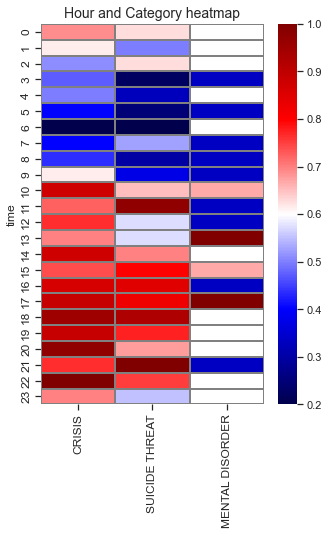

In [28]:
calls_pivot_table = dpdcalls24hour.pivot_table(values='Nature', index='CATEGORY1', columns='time', aggfunc=len)

# To compare categories, I'm scaling each category by diving by the max value of each one
calls_scaled = pd.DataFrame(calls_pivot_table.iloc[0] / calls_pivot_table.iloc[0].max())

# Using a for loop to scale others
for i in [2,1]:
    calls_scaled[calls_pivot_table.index[i]] =  pd.DataFrame(calls_pivot_table.iloc[i] / calls_pivot_table.iloc[i].max())
                    
# Using seaborn heatmap
plt.figure(figsize=(5,7))
plt.title('Hour and Category heatmap', fontsize=14)
plt.tick_params(labelsize=12)
sns.heatmap(calls_scaled, cmap='seismic', linecolor='grey',linewidths=0.1, cbar=True);

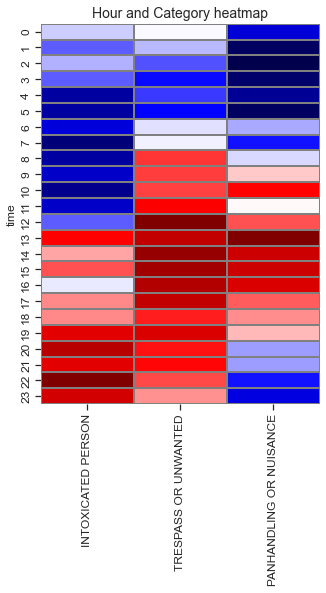

In [29]:
calls_pivot_table = dpdcalls24hour.pivot_table(values='Nature', index='CATEGORY2', columns='time', aggfunc=len)

# To compare categories, I'm scaling each category by diving by the max value of each one
calls_scaled = pd.DataFrame(calls_pivot_table.iloc[0] / calls_pivot_table.iloc[0].max())

# Using a for loop to scale others
for i in [2,1]:
    calls_scaled[calls_pivot_table.index[i]] =  pd.DataFrame(calls_pivot_table.iloc[i] / calls_pivot_table.iloc[i].max())
                    
# Using seaborn heatmap
plt.figure(figsize=(5,7))
plt.title('Hour and Category heatmap', fontsize=14)
plt.tick_params(labelsize=12)
sns.heatmap(calls_scaled, cmap='seismic', linecolor='grey',linewidths=0.1, cbar=False);

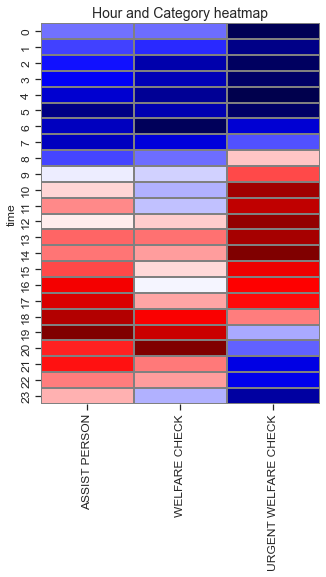

In [30]:
calls_pivot_table = dpdcalls24hour.pivot_table(values='Nature', index='CATEGORY3', columns='time', aggfunc=len)

# To compare categories, I'm scaling each category by diving by the max value of each one
calls_scaled = pd.DataFrame(calls_pivot_table.iloc[0] / calls_pivot_table.iloc[0].max())

# Using a for loop to scale others
for i in [2,1]:
    calls_scaled[calls_pivot_table.index[i]] =  pd.DataFrame(calls_pivot_table.iloc[i] / calls_pivot_table.iloc[i].max())
                    
# Using seaborn heatmap
plt.figure(figsize=(5,7))
plt.title('Hour and Category heatmap', fontsize=14)
plt.tick_params(labelsize=12)
sns.heatmap(calls_scaled, cmap='seismic', linecolor='grey',linewidths=0.1, cbar=False);

In [31]:
byHour=pd.value_counts(dpdcalls24hour['time']).sort_index(ascending=True)

flatByHour = []
for i in range(0,len(byHour)):
    flatByHour.append(np.repeat(i, byHour[i]))
    
arr=np.concatenate(flatByHour, axis=0 )  

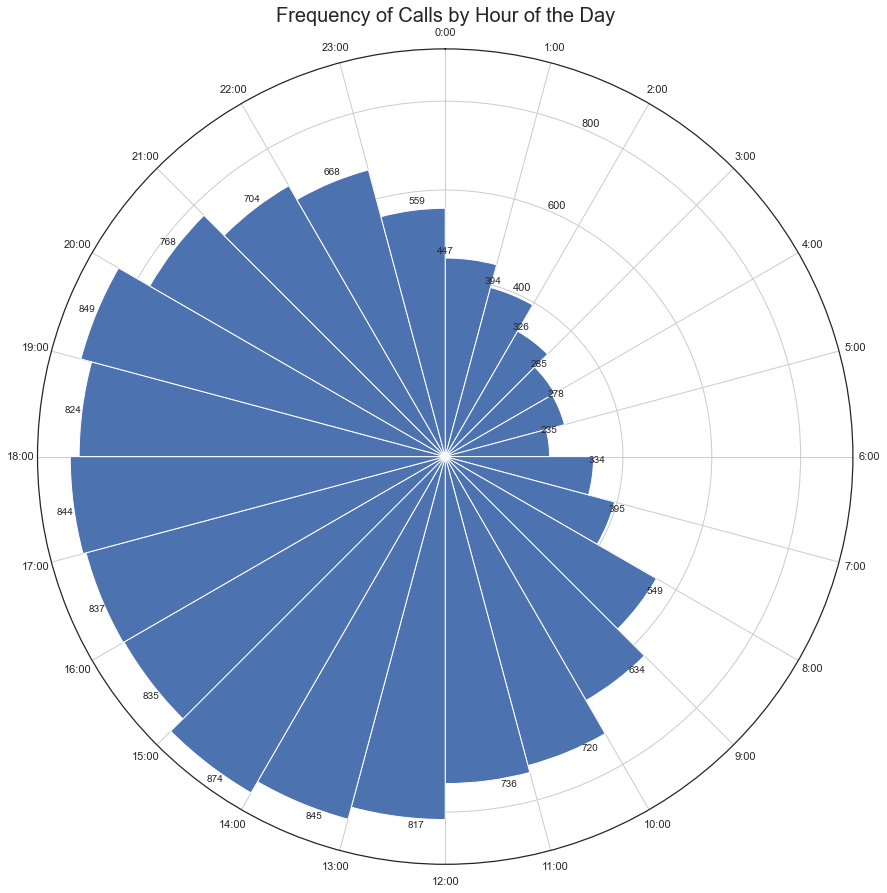

In [32]:
# Plotting the radial plot

N = 24

# Creating theta for 24 hours with an offset, so that the bars for each hour would not be centered relative to the labels
theta = np.linspace(7.5*np.pi/180, 2 * np.pi + 7.5*np.pi/180, N, endpoint=False)

# Setting the properties for a polar plot
radii, tick = np.histogram(arr, bins = 24)
width = (2*np.pi) / N

# Plotting a polar plot
plt.figure(figsize = (15, 15))
ax = plt.subplot(111, projection='polar')
plt.title("Frequency of Calls by Hour of the Day", fontsize = 20)

# Setting the ticks
thetaticks = np.arange(0, 360, 15)
ax.set_thetagrids(thetaticks)

# Plotting the bars
bars = ax.bar(theta, radii, width=width)

# Set labels to go clockwise and start from the top
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

# Setting the labels
ticks = ['0:00', '1:00', '2:00', '3:00', '4:00', '5:00', '6:00', '7:00', '8:00', '9:00', '10:00', '11:00', '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00', '22:00', '23:00']
ax.set_xticklabels(ticks)


for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.025, p.get_height() * 1.025), ha='center')
    
#for i, t in enumerate(ax.patches()):
#    t.set_rotation(i*45)


plt.show()

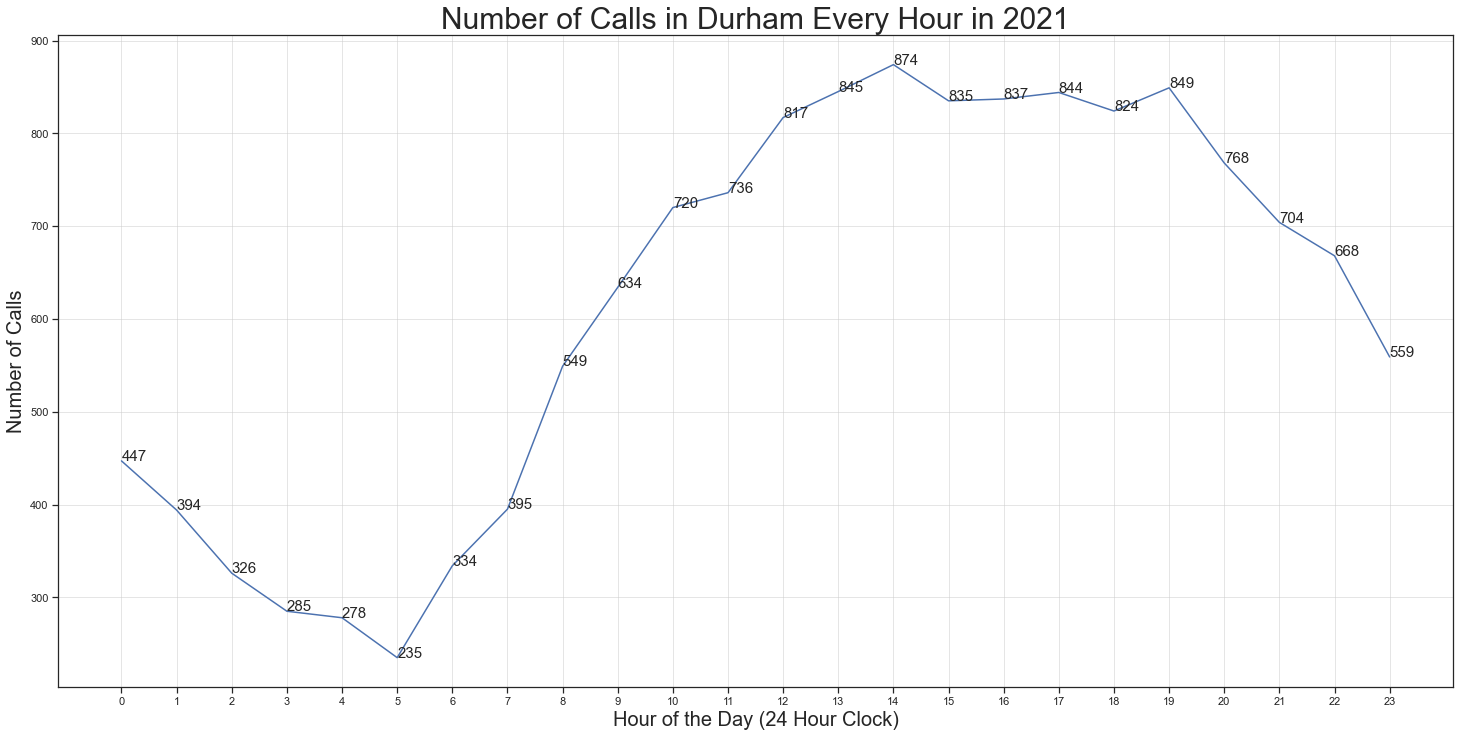

In [33]:
ax = pd.value_counts(dpdcalls24hour[dpdcalls24hour.time != 24]['time']).sort_index().plot(figsize=(25,12))
ax.set_title("Number of Calls in Durham Every Hour in 2021", fontsize=30)
ax.set_xlabel('Hour of the Day (24 Hour Clock)', fontsize=20)
ax.set_ylabel('Number of Calls', fontsize=20)
ticks=dpdcalls24hour[dpdcalls24hour.time != 24]['time'].unique()
ax.set_xticks(ticks)
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
for i,j in pd.value_counts(dpdcalls24hour[dpdcalls24hour.time != 24]['time']).sort_index().items():
    ax.annotate(str(j), xy=(i, j), fontsize=15)

In [34]:
policebeats_geojson = gpd.read_file("/Users/erikrobertsson/Documents/dataplus/Police_Beatsgeojson.geojson")
policebeats_geojson['LAWBEAT']= policebeats_geojson['LAWBEAT'].map(str)
policebeats_geojson

OBJECTID      PERIMETER STATUS CONTIGUOUS LAWDIST LAWBEAT  CAD  \
0           1   29657.869141                        D2     299  SSA   
1           2   18915.720703                        D2     299  SSA   
2           3    1193.728027                        D2     299  SSA   
3           4    1308.963013                       DSO     999  DSO   
4           5    1467.506958                       DSO     999  DSO   
..        ...            ...    ...        ...     ...     ...  ...   
119       120   98360.617188      I        yes      D4     414  414   
120       121    2400.751953      I         no      D1     114  114   
121       122    1733.583008      I         no      D1     114  114   
122       123  128589.203125      I        yes      D3     321  321   
123       124   74104.953125      I        yes      D3     323  323   

    GIS_DataA1Law_BeatAREA   ShapeSTArea  ShapeSTLength  \
0                     None  2.075708e+07   29657.868615   
1                     None  2.086135e+06   18915.724912   
2                     None  6.682308e+04    1193.727878   
3                     None  6.932677e+04    1308.962953   
4                     None  8.512911e+04    1467.506955   
..                     ...           ...            ...   
119                   None  1.342096e+08   98360.616926   
120                   None  1.818909e+05    2400.752242   
121                   None  1.319269e+05    1733.583547   
122                   None  1.590013e+08  128589.228775   
123                   None  1.066341e+08   74104.947841   

                                              geometry  
0    POLYGON ((-78.86588 36.18066, -78.86624 36.180...  
1    POLYGON ((-78.85731 36.17823, -78.85732 36.178...  
2    POLYGON ((-78.86585 36.18027, -78.86558 36.180...  
3    POLYGON ((-78.86585 36.18027, -78.86572 36.180...  
4    POLYGON ((-78.86452 36.17903, -78.86458 36.178...  
..                                                 ...  
119  POLYGON ((-78.87657 35.95794, -78.87744 35.957...  
120  POLYGON ((-78.84461 35.95609, -78.84488 35.956...  
121  POLYGON ((-78.84048 35.95491, -78.84051 35.954...  
122  POLYGON ((-78.95997 35.99931, -78.95997 35.999...  
123  POLYGON ((-78.96145 35.96169, -78.96153 35.961...  

[124 rows x 11 columns]

In [35]:
dpdcalls2020 = gpd.read_file('/Users/erikrobertsson/Documents/dataplus/dpdshapefile2020/dpdshapefile2020.shp')
dpdcalls2020 = dpdcalls2020.loc[~(dpdcalls2020["X"] == 0) & ~(dpdcalls2020["Y"] == 0)].copy()
dpdcalls2020 = dpdcalls2020.loc[dpdcalls2020["Source"] != "Self Initiated"].copy()
dpdcalls2020 = dpdcalls2020.loc[dpdcalls2020["Cancelled"] == 0].copy()
dpdcalls2020 = dpdcalls2020.loc[(dpdcalls2020["Beat"] != "DSO") & (dpdcalls2020["Beat"] != "SSA")].copy()
dpdcalls2020 = dpdcalls2020.loc[dpdcalls2020["Nature"] != "HANG UP"].copy()
dpdcalls2020 = dpdcalls2020.loc[(dpdcalls2020["Nature"] != "HANG UP WIRELESS PHASE 1") & (dpdcalls2020["Nature"] != "0") & (dpdcalls2020["Nature"] != "16") & (dpdcalls2020["Nature"] != "DIRECTED PATROL") & (dpdcalls2020["Nature"] != "NO apt # or phone") & (dpdcalls2020["Nature"] != "\\") & (dpdcalls2020["Nature"] != "VIN: JHMFA36226S011840 not sto") & (dpdcalls2020["Nature"] != "DISy") & (dpdcalls2020["Nature"] != "VEr") & (dpdcalls2020["Nature"] != "DIST") & (dpdcalls2020['Nature'] != 'HANG UP WIRELESS PHASE 2')].copy()
nature_list = ['WELFARE CHECK', 'URGENT WELFARE CHECK', 'PANHANDLING OR NUISANCE', 'VERBAL DISTURBANCE', 'SUICIDE THREAT', 'MENTAL DISORDER', 'TRESPASS OR UNWANTED', 'INTOXICATED PERSON', 'ASSIST PERSON', 'CRISIS']
dpdcalls2020 = dpdcalls2020[dpdcalls2020['Nature'].isin(nature_list)].copy()
twotosix = ['2', '3', '4', '5', '6']
dpdcalls2020 = dpdcalls2020[dpdcalls2020['Priority'].isin(twotosix)].copy()
dpdcalls2020 = dpdcalls2020.to_crs("EPSG:4326")
dpdcalls2020

Event Numb  Case Numbe   Call Date   Call Time             Source  \
0         20090196         NaN   10/3/2020   5:55:18PM         Phone Call   
2         20090198         NaN   10/3/2020   6:03:31PM         Phone Call   
13        20090210         NaN   10/3/2020   6:27:24PM         Phone Call   
26        20090225         NaN   10/3/2020   6:40:56PM         Phone Call   
30        20090237         NaN   10/3/2020   6:49:12PM         Phone Call   
...            ...         ...         ...         ...                ...   
336417    20469555         NaN  31/12/2020  10:09:42PM         Phone Call   
336434    20469575         NaN  31/12/2020  10:22:49PM              E-911   
336444    20469590         NaN  31/12/2020  10:33:39PM  Wireless 911 Call   
336482    20469645         NaN  31/12/2020  11:14:52PM  Wireless 911 Call   
336526    20469706         NaN  31/12/2020  11:59:40PM  Wireless 911 Call   

       Priority                   Nature               Address        X  \
0             4            WELFARE CHECK        400 E PILOT ST  2027210   
2             4            ASSIST PERSON      7800 LEONARDO DR  2012737   
13            4            ASSIST PERSON       3800 BOOKER AVE  2027572   
26            4            WELFARE CHECK      1000 W CLUB BLVD  2026731   
30            4            WELFARE CHECK        1700 FOREST RD  2024703   
...         ...                      ...                   ...      ...   
336417        3            WELFARE CHECK  200 CHATTAHOOCHEE ST  2055444   
336434        3     TRESPASS OR UNWANTED     2100 N ROXBORO ST  2032526   
336444        4  PANHANDLING OR NUISANCE      2400 HOLLOWAY ST  2041624   
336482        4            ASSIST PERSON         2600 CREST ST  2018007   
336526        3            WELFARE CHECK        4700 NC 55 HWY  2030751   

             Y District Beat               Dispositio  Cancelled  \
0       805972       D4  412  Resolved Without Report          0   
2       783053       D3  324  Resolved Without Report          0   
13      801043       D4  415  Resolved Without Report          0   
26      825554       D2  212  Resolved Without Report          0   
30      827871       D2  212  Resolved Without Report          0   
...        ...      ...  ...                      ...        ...   
336417  789031       D4  423  Resolved Without Report          0   
336434  825629       D2  213  Resolved Without Report          0   
336444  815098       D1  123  Resolved Without Report          0   
336482  823623       D3  313  Resolved Without Report          0   
336526  783233       D4  422                Unfounded          0   

                          geometry  
0       POINT (-78.90805 35.96446)  
2       POINT (-78.95699 35.90152)  
13      POINT (-78.90684 35.95091)  
26      POINT (-78.90961 36.01825)  
30      POINT (-78.91646 36.02462)  
...                            ...  
336417  POINT (-78.81275 35.91781)  
336434  POINT (-78.89002 36.01844)  
336444  POINT (-78.85930 35.98948)  
336482  POINT (-78.93911 36.01296)  
336526  POINT (-78.89617 35.90198)  

[12066 rows x 15 columns]

In [36]:
dpdcalls2019 = gpd.read_file('/Users/erikrobertsson/Documents/dataplus/dpdshapefile2019/dpdshapefile2019.shp')
dpdcalls2019 = dpdcalls2019.loc[~(dpdcalls2019["X"] == 0) & ~(dpdcalls2019["Y"] == 0)].copy()
dpdcalls2019 = dpdcalls2019.loc[dpdcalls2019["Source"] != "Self Initiated"].copy()
dpdcalls2019 = dpdcalls2019.loc[dpdcalls2019["Cancelled"] == 0].copy()
dpdcalls2019 = dpdcalls2019.loc[(dpdcalls2019["Beat"] != "DSO") & (dpdcalls2019["Beat"] != "SSA")].copy()
dpdcalls2019 = dpdcalls2019.loc[dpdcalls2019["Nature"] != "HANG UP"].copy()
dpdcalls2019 = dpdcalls2019.loc[(dpdcalls2019["Nature"] != "HANG UP WIRELESS PHASE 1") & (dpdcalls2019["Nature"] != "0") & (dpdcalls2019["Nature"] != "16") & (dpdcalls2019["Nature"] != "DIRECTED PATROL") & (dpdcalls2019["Nature"] != "NO apt # or phone") & (dpdcalls2019["Nature"] != "\\") & (dpdcalls2019["Nature"] != "VIN: JHMFA36226S011840 not sto") & (dpdcalls2019["Nature"] != "DISy") & (dpdcalls2019["Nature"] != "VEr") & (dpdcalls2019["Nature"] != "DIST") & (dpdcalls2019['Nature'] != 'HANG UP WIRELESS PHASE 2')].copy()
nature_list = ['WELFARE CHECK', 'URGENT WELFARE CHECK', 'PANHANDLING OR NUISANCE', 'VERBAL DISTURBANCE', 'SUICIDE THREAT', 'MENTAL DISORDER', 'TRESPASS OR UNWANTED', 'INTOXICATED PERSON', 'ASSIST PERSON', 'CRISIS']
dpdcalls2019 = dpdcalls2019[dpdcalls2019['Nature'].isin(nature_list)].copy()
twotosix = ['2', '3', '4', '5', '6']
dpdcalls2019 = dpdcalls2019[dpdcalls2019['Priority'].isin(twotosix)].copy()
dpdcalls2019 = dpdcalls2019.to_crs("EPSG:4326")
dpdcalls2019

Event Numb Case Numbe   Call Date   Call Time             Source  \
53      2019000065       None    1/1/2019  12:28:38AM  Wireless 911 Call   
85      2019000108       None    1/1/2019  12:54:10AM              E-911   
99      2019000129       None    1/1/2019   1:09:59AM         Phone Call   
107     2019000144       None    1/1/2019   1:19:46AM         Phone Call   
122     2019000165       None    1/1/2019   1:41:23AM  Wireless 911 Call   
...            ...        ...         ...         ...                ...   
355798  2019506589       None  31/12/2019   8:40:54PM  Wireless 911 Call   
355835  2019506636       None  31/12/2019   9:25:40PM  Wireless 911 Call   
355838  2019506639       None  31/12/2019   9:27:08PM  Wireless 911 Call   
355858  2019506676       None  31/12/2019   9:49:08PM              E-911   
355955  2019506808       None  31/12/2019  11:37:43PM  Wireless 911 Call   

       Priority                Nature                       Address        X  \
53            4         ASSIST PERSON             2000 N ROXBORO ST  2032691   
85            2         ASSIST PERSON                2500 WILBON ST  2027818   
99            4         WELFARE CHECK                   700 KENT ST  2024091   
107           3  TRESPASS OR UNWANTED          3500 HILLSBOROUGH RD  2013912   
122           3  TRESPASS OR UNWANTED         6400 GREENS HOLLOW LN  2023736   
...         ...                   ...                           ...      ...   
355798        2    VERBAL DISTURBANCE               300 JUNCTION RD  2043188   
355835        4         ASSIST PERSON              100 W PARRISH ST  2029329   
355838        2    VERBAL DISTURBANCE  4600 DURHAM CHAPEL HILL BLVD  2006277   
355858        4  TRESPASS OR UNWANTED             1000 N ALSTON AVE  2033919   
355955        2    VERBAL DISTURBANCE                 500 HARDEE ST  2040084   

             Y District   Beat               Dispositio  Cancelled  \
53      825075       D1  121.0  Resolved Without Report          0   
85      829914       D2  214.0  Resolved Without Report          0   
99      817241       D3  312.0  Resolved Without Report          0   
107     827209       D2  221.0  Resolved Without Report          0   
122     785521       D4  422.0  Resolved Without Report          0   
...        ...      ...    ...                      ...        ...   
355798  816606       D1  123.0  Resolved Without Report          0   
355835  817435       D5  512.0  Resolved Without Report          0   
355838  805161       D3  321.0  Resolved Without Report          0   
355858  817070       D1  112.0  Resolved Without Report          0   
355955  819119       D1  122.0  Resolved Without Report          0   

                          geometry  
53      POINT (-78.88946 36.01692)  
85      POINT (-78.90592 36.03022)  
99      POINT (-78.91856 35.99542)  
107     POINT (-78.95295 36.02282)  
122     POINT (-78.91985 35.90828)  
...                            ...  
355798  POINT (-78.85401 35.99362)  
355835  POINT (-78.90085 35.99594)  
355838  POINT (-78.97879 35.96226)  
355858  POINT (-78.88534 35.99492)  
355955  POINT (-78.86449 36.00053)  

[13891 rows x 15 columns]

In [37]:
dpdcalls2018 = gpd.read_file('/Users/erikrobertsson/Documents/dataplus/dpdshapefile2018/dpdshapefile2018.shp')
dpdcalls2018 = dpdcalls2018.loc[~(dpdcalls2018["X"] == 0) & ~(dpdcalls2018["Y"] == 0)].copy()
dpdcalls2018 = dpdcalls2018.loc[dpdcalls2018["Source"] != "Self Initiated"].copy()
dpdcalls2018 = dpdcalls2018.loc[dpdcalls2018["Cancelled"] == 0].copy()
dpdcalls2018 = dpdcalls2018.loc[(dpdcalls2018["Beat"] != "DSO") & (dpdcalls2018["Beat"] != "SSA")].copy()
dpdcalls2018 = dpdcalls2018.loc[dpdcalls2018["Nature"] != "HANG UP"].copy()
dpdcalls2018 = dpdcalls2018.loc[(dpdcalls2018["Nature"] != "HANG UP WIRELESS PHASE 1") & (dpdcalls2018["Nature"] != "0") & (dpdcalls2018["Nature"] != "16") & (dpdcalls2018["Nature"] != "DIRECTED PATROL") & (dpdcalls2018["Nature"] != "NO apt # or phone") & (dpdcalls2018["Nature"] != "\\") & (dpdcalls2018["Nature"] != "VIN: JHMFA36226S011840 not sto") & (dpdcalls2018["Nature"] != "DISy") & (dpdcalls2018["Nature"] != "VEr") & (dpdcalls2018["Nature"] != "DIST") & (dpdcalls2018['Nature'] != 'HANG UP WIRELESS PHASE 2')].copy()
nature_list = ['WELFARE CHECK', 'URGENT WELFARE CHECK', 'PANHANDLING OR NUISANCE', 'VERBAL DISTURBANCE', 'SUICIDE THREAT', 'MENTAL DISORDER', 'TRESPASS OR UNWANTED', 'INTOXICATED PERSON', 'ASSIST PERSON', 'CRISIS']
dpdcalls2018 = dpdcalls2018[dpdcalls2018['Nature'].isin(nature_list)].copy()
twotosix = ['2', '3', '4', '5', '6']
dpdcalls2018 = dpdcalls2018[dpdcalls2018['Priority'].isin(twotosix)].copy()
dpdcalls2018 = dpdcalls2018.to_crs("EPSG:4326")
dpdcalls2018

Event Numb Case Numbe   Call Date   Call Time             Source  \
50      2018000065       None    1/1/2018  12:26:56AM  Wireless 911 Call   
111     2018000141       None    1/1/2018   1:24:28AM  Wireless 911 Call   
115     2018000151       None    1/1/2018   1:30:38AM  Wireless 911 Call   
134     2018000182       None    1/1/2018   1:57:31AM  Wireless 911 Call   
157     2018000218       None    1/1/2018   2:51:00AM         Phone Call   
...            ...        ...         ...         ...                ...   
335172  2018489844       None  31/12/2018   8:28:34PM         Phone Call   
335185  2018489860       None  31/12/2018   8:46:06PM  Wireless 911 Call   
335237  2018489936       None  31/12/2018   9:44:57PM  Wireless 911 Call   
335333  2018490076       None  31/12/2018  11:16:34PM  Wireless 911 Call   
335343  2018490088       None  31/12/2018  11:27:00PM              E-911   

       Priority                Nature               Address        X       Y  \
50            4    INTOXICATED PERSON     5600 S MIAMI BLVD  2044198  773242   
111           3                CRISIS        400 E PILOT ST  2027329  806950   
115           2    INTOXICATED PERSON      2900 DEARBORN DR  2039078  832128   
134           2    INTOXICATED PERSON         4200 ORAN AVE  2022662  840120   
157           2         ASSIST PERSON    4000 GLENNSTONE DR  2049183  837770   
...         ...                   ...                   ...      ...     ...   
335172        4         ASSIST PERSON         500 HARDEE ST  2040076  819001   
335185        2         ASSIST PERSON  1500 FAYETTEVILLE ST  2029551  811311   
335237        3  TRESPASS OR UNWANTED     200 N CORCORAN ST  2029247  817623   
335333        3                CRISIS   900 FAYETTEVILLE ST  2030107  813301   
335343        3  TRESPASS OR UNWANTED     1000 N ALSTON AVE  2033702  816913   

       District Beat               Dispositio  Cancelled  \
50           D4  423  Resolved Without Report          0   
111          D4  412          CIT - No Report          0   
115          D2  223  Resolved Without Report          0   
134          D2  224  Resolved Without Report          0   
157          D2  223  Resolved Without Report          0   
...         ...  ...                      ...        ...   
335172       D1  122  Resolved Without Report          0   
335185       D4  411  Resolved Without Report          0   
335237       D5  522  Resolved Without Report          0   
335333       D4  411  Resolved Without Report          0   
335343       D1  113  Resolved Without Report          0   

                          geometry  
50      POINT (-78.85081 35.87448)  
111     POINT (-78.90765 35.96714)  
115     POINT (-78.86783 36.03627)  
134     POINT (-78.92333 36.05827)  
157     POINT (-78.83362 36.05173)  
...                            ...  
335172  POINT (-78.86452 36.00021)  
335185  POINT (-78.90012 35.97912)  
335237  POINT (-78.90113 35.99646)  
335333  POINT (-78.89824 35.98458)  
335343  POINT (-78.88607 35.99449)  

[13708 rows x 15 columns]

In [38]:
dpdcalls2017 = gpd.read_file('/Users/erikrobertsson/Documents/dataplus/dpdshapefile2017/dpdshapefile2017.shp')
dpdcalls2017 = dpdcalls2017.loc[~(dpdcalls2017["X"] == 0) & ~(dpdcalls2017["Y"] == 0)].copy()
dpdcalls2017 = dpdcalls2017.loc[dpdcalls2017["Source"] != "Self Initiated"].copy()
dpdcalls2017 = dpdcalls2017.loc[dpdcalls2017["Cancelled"] == 0].copy()
dpdcalls2017 = dpdcalls2017.loc[(dpdcalls2017["Beat"] != "DSO") & (dpdcalls2017["Beat"] != "SSA")].copy()
dpdcalls2017 = dpdcalls2017.loc[dpdcalls2017["Nature"] != "HANG UP"].copy()
dpdcalls2017 = dpdcalls2017.loc[(dpdcalls2017["Nature"] != "HANG UP WIRELESS PHASE 1") & (dpdcalls2017["Nature"] != "0") & (dpdcalls2017["Nature"] != "16") & (dpdcalls2017["Nature"] != "DIRECTED PATROL") & (dpdcalls2017["Nature"] != "NO apt # or phone") & (dpdcalls2017["Nature"] != "\\") & (dpdcalls2017["Nature"] != "VIN: JHMFA36226S011840 not sto") & (dpdcalls2017["Nature"] != "DISy") & (dpdcalls2017["Nature"] != "VEr") & (dpdcalls2017["Nature"] != "DIST") & (dpdcalls2017['Nature'] != 'HANG UP WIRELESS PHASE 2')].copy()
nature_list = ['WELFARE CHECK', 'URGENT WELFARE CHECK', 'PANHANDLING OR NUISANCE', 'VERBAL DISTURBANCE', 'SUICIDE THREAT', 'MENTAL DISORDER', 'TRESPASS OR UNWANTED', 'INTOXICATED PERSON', 'ASSIST PERSON', 'CRISIS']
dpdcalls2017 = dpdcalls2017[dpdcalls2017['Nature'].isin(nature_list)].copy()
twotosix = ['2', '3', '4', '5', '6']
dpdcalls2017 = dpdcalls2017[dpdcalls2017['Priority'].isin(twotosix)].copy()
dpdcalls2017 = dpdcalls2017.to_crs("EPSG:4326")
dpdcalls2017

Event Numb Case Numbe   Call Date   Call Time             Source  \
16      2017000024       None    1/1/2017  12:08:10AM              E-911   
27      2017000040       None    1/1/2017  12:13:47AM         Phone Call   
42      2017000070       None    1/1/2017  12:26:58AM  Wireless 911 Call   
55      2017000092       None    1/1/2017  12:45:44AM              E-911   
100     2017000156       None    1/1/2017   1:36:35AM         Phone Call   
...            ...        ...         ...         ...                ...   
340147  2017492533       None  31/12/2017   7:33:45PM              E-911   
340168  2017492566       None  31/12/2017   8:08:53PM              E-911   
340205  2017492624       None  31/12/2017   9:10:53PM              E-911   
340210  2017492629       None  31/12/2017   9:16:48PM         Phone Call   
340220  2017492644       None  31/12/2017   9:42:00PM              E-911   

       Priority         Nature                     Address        X       Y  \
16            4  ASSIST PERSON          4600 UNIVERSITY DR  2009312  804227   
27            4  ASSIST PERSON             1300 HUDSON AVE  2025825  827286   
42            4  ASSIST PERSON     WASHINGTON ST/W KNOX ST  2029945  823663   
55            4  ASSIST PERSON       E LAWSON ST/WABASH ST  2032797  809477   
100           4  WELFARE CHECK        2000-BLK WOODVIEW DR  2028382  826991   
...         ...            ...                         ...      ...     ...   
340147        3  ASSIST PERSON  1700 CARPENTER FLETCHER RD  2032583  788237   
340168        4  ASSIST PERSON        3900 FAYETTEVILLE ST  2028575  800843   
340205        3         CRISIS              1200 E MAIN ST  2033362  814461   
340210        3  WELFARE CHECK        1100 N BUCHANAN BLVD  2026109  824595   
340220        4  ASSIST PERSON             6900 GARRETT RD  2011959  790206   

       District Beat               Dispositio  Cancelled  \
16           D3  323  Resolved Without Report          0   
27           D2  214  Resolved Without Report          0   
42           D2  212  Resolved Without Report          0   
55           D4  413  Resolved Without Report          0   
100          D2  214  Resolved Without Report          0   
...         ...  ...                      ...        ...   
340147       D4  421  Resolved Without Report          0   
340168       D4  413  Resolved Without Report          0   
340205       D1  114          CIT - No Report          0   
340210       D2  211  Resolved Without Report          0   
340220       D3  322  Resolved Without Report          0   

                          geometry  
16      POINT (-78.96853 35.95969)  
27      POINT (-78.91267 36.02301)  
42      POINT (-78.89875 36.01305)  
55      POINT (-78.88916 35.97407)  
100     POINT (-78.90402 36.02219)  
...                            ...  
340147  POINT (-78.88996 35.91572)  
340168  POINT (-78.90346 35.95036)  
340205  POINT (-78.88723 35.98776)  
340210  POINT (-78.91172 36.01562)  
340220  POINT (-78.95961 35.92117)  

[14772 rows x 15 columns]

In [39]:
dpdcalls2016 = gpd.read_file('/Users/erikrobertsson/Documents/dataplus/dpdshapefile2016/dpdshapefile2016.shp')
dpdcalls2016 = dpdcalls2016.loc[~(dpdcalls2016["X"] == 0) & ~(dpdcalls2016["Y"] == 0)].copy()
dpdcalls2016 = dpdcalls2016.loc[dpdcalls2016["Source"] != "Self Initiated"].copy()
dpdcalls2016 = dpdcalls2016.loc[dpdcalls2016["Cancelled"] == 0].copy()
dpdcalls2016 = dpdcalls2016.loc[(dpdcalls2016["Beat"] != "DSO") & (dpdcalls2016["Beat"] != "SSA")].copy()
dpdcalls2016 = dpdcalls2016.loc[dpdcalls2016["Nature"] != "HANG UP"].copy()
dpdcalls2016 = dpdcalls2016.loc[(dpdcalls2016["Nature"] != "HANG UP WIRELESS PHASE 1") & (dpdcalls2016["Nature"] != "0") & (dpdcalls2016["Nature"] != "16") & (dpdcalls2016["Nature"] != "DIRECTED PATROL") & (dpdcalls2016["Nature"] != "NO apt # or phone") & (dpdcalls2016["Nature"] != "\\") & (dpdcalls2016["Nature"] != "VIN: JHMFA36226S011840 not sto") & (dpdcalls2016["Nature"] != "DISy") & (dpdcalls2016["Nature"] != "VEr") & (dpdcalls2016["Nature"] != "DIST") & (dpdcalls2016['Nature'] != 'HANG UP WIRELESS PHASE 2')].copy()
nature_list = ['WELFARE CHECK', 'URGENT WELFARE CHECK', 'PANHANDLING OR NUISANCE', 'VERBAL DISTURBANCE', 'SUICIDE THREAT', 'MENTAL DISORDER', 'TRESPASS OR UNWANTED', 'INTOXICATED PERSON', 'ASSIST PERSON', 'CRISIS']
dpdcalls2016 = dpdcalls2016[dpdcalls2016['Nature'].isin(nature_list)].copy()
twotosix = ['2', '3', '4', '5', '6']
dpdcalls2016 = dpdcalls2016[dpdcalls2016['Priority'].isin(twotosix)].copy()
dpdcalls2016 = dpdcalls2016.to_crs("EPSG:4326")
dpdcalls2016

Event Numb Case Numbe   Call Date   Call Time             Source  \
32      2016000047       None    1/1/2016  12:10:10AM  Wireless 911 Call   
58      2016000091       None    1/1/2016  12:29:43AM              E-911   
72      2016000115       None    1/1/2016  12:51:24AM  Wireless 911 Call   
105     2016000173       None    1/1/2016   1:29:33AM              E-911   
110     2016000179       None    1/1/2016   1:40:30AM              E-911   
...            ...        ...         ...         ...                ...   
358807  2016510199       None  31/12/2016   6:54:20PM  Wireless 911 Call   
358812  2016510206       None  31/12/2016   6:58:01PM         Phone Call   
358955  2016510393       None  31/12/2016   9:35:29PM              E-911   
359014  2016510476       None  31/12/2016  10:30:30PM              E-911   
359017  2016510482       None  31/12/2016  10:34:39PM  Wireless 911 Call   

       Priority                Nature               Address        X       Y  \
32            4         WELFARE CHECK      900 N MIAMI BLVD  2038925  815957   
58            4         ASSIST PERSON        3800 N DUKE ST  2028227  837614   
72            2    INTOXICATED PERSON     900 W TRINITY AVE  2027904  820883   
105           4         ASSIST PERSON   300 COMMONWEALTH ST  2040576  809443   
110           2         WELFARE CHECK    I85 N/N ROXBORO ST  2032336  824291   
...         ...                   ...                   ...      ...     ...   
358807        4         ASSIST PERSON          600 BROAD ST  2023472  821468   
358812        3  TRESPASS OR UNWANTED  2000 HILLSBOROUGH RD  2023033  822866   
358955        2        SUICIDE THREAT      2500 HOLLOWAY ST  2042057  815217   
359014        4         ASSIST PERSON       300 N DRIVER ST  2035860  814886   
359017        4         ASSIST PERSON         500 HARDEE ST  2040245  818037   

       District Beat               Dispositio  Cancelled  \
32           D1  122                Unfounded          0   
58           D2  224  Resolved Without Report          0   
72           D5  512  Resolved Without Report          0   
105          D1  124  Resolved Without Report          0   
110          D2  212  Resolved Without Report          0   
...         ...  ...                      ...        ...   
358807       D5  512  Resolved Without Report          0   
358812       D2  213  Resolved Without Report          0   
358955       D1  125                Unfounded          0   
359014       D1  114  Resolved Without Report          0   
359017       D1  122  Resolved Without Report          0   

                          geometry  
32      POINT (-78.86842 35.99185)  
58      POINT (-78.90451 36.05138)  
72      POINT (-78.90566 36.00542)  
105     POINT (-78.86287 35.97395)  
110     POINT (-78.89066 36.01477)  
...                            ...  
358807  POINT (-78.92064 36.00703)  
358812  POINT (-78.92212 36.01087)  
358955  POINT (-78.85784 35.98980)  
359014  POINT (-78.87879 35.98892)  
359017  POINT (-78.86395 35.99756)  

[15324 rows x 15 columns]

In [40]:
dpdcalls2015 = gpd.read_file('/Users/erikrobertsson/Documents/dataplus/dpdshapefile2015/dpdshapefile2015.shp')
dpdcalls2015 = dpdcalls2015.loc[~(dpdcalls2015["X"] == 0) & ~(dpdcalls2015["Y"] == 0)].copy()
dpdcalls2015 = dpdcalls2015.loc[dpdcalls2015["Source"] != "Self Initiated"].copy()
dpdcalls2015 = dpdcalls2015.loc[dpdcalls2015["Cancelled"] == 0].copy()
dpdcalls2015 = dpdcalls2015.loc[(dpdcalls2015["Beat"] != "DSO") & (dpdcalls2015["Beat"] != "SSA")].copy()
dpdcalls2015 = dpdcalls2015.loc[dpdcalls2015["Nature"] != "HANG UP"].copy()
dpdcalls2015 = dpdcalls2015.loc[(dpdcalls2015["Nature"] != "HANG UP WIRELESS PHASE 1") & (dpdcalls2015["Nature"] != "0") & (dpdcalls2015["Nature"] != "16") & (dpdcalls2015["Nature"] != "DIRECTED PATROL") & (dpdcalls2015["Nature"] != "NO apt # or phone") & (dpdcalls2015["Nature"] != "\\") & (dpdcalls2015["Nature"] != "VIN: JHMFA36226S011840 not sto") & (dpdcalls2015["Nature"] != "DISy") & (dpdcalls2015["Nature"] != "VEr") & (dpdcalls2015["Nature"] != "DIST") & (dpdcalls2015['Nature'] != 'HANG UP WIRELESS PHASE 2')].copy()
nature_list = ['WELFARE CHECK', 'URGENT WELFARE CHECK', 'PANHANDLING OR NUISANCE', 'VERBAL DISTURBANCE', 'SUICIDE THREAT', 'MENTAL DISORDER', 'TRESPASS OR UNWANTED', 'INTOXICATED PERSON', 'ASSIST PERSON', 'CRISIS']
dpdcalls2015 = dpdcalls2015[dpdcalls2015['Nature'].isin(nature_list)].copy()
twotosix = ['2', '3', '4', '5', '6']
dpdcalls2015 = dpdcalls2015[dpdcalls2015['Priority'].isin(twotosix)].copy()
dpdcalls2015 = dpdcalls2015.to_crs("EPSG:4326")
dpdcalls2015

Event Numb Case Numbe   Call Date   Call Time             Source  \
73      2015000123       None    1/1/2015  12:43:50AM              E-911   
74      2015000124       None    1/1/2015  12:45:12AM              E-911   
91      2015000150       None    1/1/2015   1:06:12AM         Phone Call   
107     2015000171       None    1/1/2015   1:26:16AM  Wireless 911 Call   
113     2015000178       None    1/1/2015   1:33:01AM         Phone Call   
...            ...        ...         ...         ...                ...   
381920  2015536620       None  31/12/2015  10:01:55PM  Wireless 911 Call   
381923  2015536623       None  31/12/2015  10:03:29PM              E-911   
381948  2015536666       None  31/12/2015  10:22:35PM         Phone Call   
382005  2015536752       None  31/12/2015  11:19:12PM         Phone Call   
382011  2015536764       None  31/12/2015  11:29:55PM         Phone Call   

       Priority                Nature             Address        X       Y  \
73            4         ASSIST PERSON   5200 S MIAMI BLVD  2044564  776463   
74            4         ASSIST PERSON      2000 N DUKE ST  2027910  827532   
91            4         ASSIST PERSON       2300 ERWIN RD  2018475  821864   
107           2    INTOXICATED PERSON      900 MASSEY AVE  2031576  811259   
113           3  TRESPASS OR UNWANTED     100 NC 54 HWY E  2019438  786458   
...         ...                   ...                 ...      ...     ...   
381920        4         ASSIST PERSON  4100 MERIWETHER DR  2032106  834618   
381923        4         ASSIST PERSON     900 PLEASANT DR  2042644  805840   
381948        2    INTOXICATED PERSON  2500 MERIDIAN PKWY  2030610  786016   
382005        3  TRESPASS OR UNWANTED       1700 GUESS RD  2025421  826452   
382011        3  TRESPASS OR UNWANTED      4400 NC 55 HWY  2031980  786571   

       District Beat               Dispositio  Cancelled  \
73           D4  423  Resolved Without Report          0   
74           D2  214  Resolved Without Report          0   
91           D3  313  Resolved Without Report          0   
107          D4  411       Assist/Backup Unit          0   
113          D4  421  Resolved Without Report          0   
...         ...  ...                      ...        ...   
381920       D2  223                Unfounded          0   
381923       D1  124  Resolved Without Report          0   
381948       D4  421  Resolved Without Report          0   
382005       D2  211  Resolved Without Report          0   
382011       D4  421  Resolved Without Report          0   

                          geometry  
73      POINT (-78.84956 35.88333)  
74      POINT (-78.90562 36.02368)  
91      POINT (-78.93754 36.00813)  
107     POINT (-78.89328 35.97897)  
113     POINT (-78.93436 35.91086)  
...                            ...  
381920  POINT (-78.89140 36.04313)  
381923  POINT (-78.85590 35.96404)  
381948  POINT (-78.89663 35.90962)  
382005  POINT (-78.91404 36.02072)  
382011  POINT (-78.89201 35.91114)  

[15273 rows x 15 columns]

In [41]:
dpdcalls2014 = gpd.read_file('/Users/erikrobertsson/Documents/dataplus/dpdshapefile2014/dpdshapefile2014.shp')
dpdcalls2014 = dpdcalls2014.loc[~(dpdcalls2014["X"] == 0) & ~(dpdcalls2014["Y"] == 0)].copy()
dpdcalls2014 = dpdcalls2014.loc[dpdcalls2014["Source"] != "Self Initiated"].copy()
dpdcalls2014 = dpdcalls2014.loc[dpdcalls2014["Cancelled"] == 0].copy()
dpdcalls2014 = dpdcalls2014.loc[(dpdcalls2014["Beat"] != "DSO") & (dpdcalls2014["Beat"] != "SSA")].copy()
dpdcalls2014 = dpdcalls2014.loc[dpdcalls2014["Nature"] != "HANG UP"].copy()
dpdcalls2014 = dpdcalls2014.loc[(dpdcalls2014["Nature"] != "HANG UP WIRELESS PHASE 1") & (dpdcalls2014["Nature"] != "0") & (dpdcalls2014["Nature"] != "16") & (dpdcalls2014["Nature"] != "DIRECTED PATROL") & (dpdcalls2014["Nature"] != "NO apt # or phone") & (dpdcalls2014["Nature"] != "\\") & (dpdcalls2014["Nature"] != "VIN: JHMFA36226S011840 not sto") & (dpdcalls2014["Nature"] != "DISy") & (dpdcalls2014["Nature"] != "VEr") & (dpdcalls2014["Nature"] != "DIST") & (dpdcalls2014['Nature'] != 'HANG UP WIRELESS PHASE 2')].copy()
nature_list = ['WELFARE CHECK', 'URGENT WELFARE CHECK', 'PANHANDLING OR NUISANCE', 'VERBAL DISTURBANCE', 'SUICIDE THREAT', 'MENTAL DISORDER', 'TRESPASS OR UNWANTED', 'INTOXICATED PERSON', 'ASSIST PERSON', 'CRISIS']
dpdcalls2014 = dpdcalls2014[dpdcalls2014['Nature'].isin(nature_list)].copy()
twotosix = ['2', '3', '4', '5', '6']
dpdcalls2014 = dpdcalls2014[dpdcalls2014['Priority'].isin(twotosix)].copy()
dpdcalls2014 = dpdcalls2014.to_crs("EPSG:4326")
dpdcalls2014

Event Numb Case Numbe   Call Date   Call Time             Source  \
78      2014000099       None    1/1/2014   1:02:29AM         Phone Call   
100     2014000133       None    1/1/2014   1:27:06AM         Phone Call   
104     2014000138       None    1/1/2014   1:31:55AM         Phone Call   
111     2014000147       None    1/1/2014   1:39:14AM         Phone Call   
144     2014000192       None    1/1/2014   2:41:20AM  Wireless 911 Call   
...            ...        ...         ...         ...                ...   
373233  2014508647       None  31/12/2014   6:18:22PM  Wireless 911 Call   
373275  2014508702       None  31/12/2014   7:07:50PM              E-911   
373328  2014508779       None  31/12/2014   8:38:09PM              E-911   
373348  2014508811       None  31/12/2014   8:59:08PM              E-911   
373455  2014508968       None  31/12/2014  11:21:03PM              E-911   

       Priority                Nature                             Address  \
78            3  TRESPASS OR UNWANTED                        700 NINTH ST   
100           4         ASSIST PERSON                       1100 ELLIS RD   
104           4         ASSIST PERSON                        500 FORGE RD   
111           4         ASSIST PERSON               3700 CHIMNEY RIDGE PL   
144           4         ASSIST PERSON         W CLUB BLVD/N BUCHANAN BLVD   
...         ...                   ...                                 ...   
373233        4         ASSIST PERSON                  100 MOUNT EVANS DR   
373275        3  TRESPASS OR UNWANTED  CROOKED CREEK PKWY/FAYETTEVILLE RD   
373328        4         ASSIST PERSON                        1600 KENT ST   
373348        4         ASSIST PERSON                       200 STOKES ST   
373455        2    INTOXICATED PERSON                      800 MASSEY AVE   

              X       Y District Beat               Dispositio  Cancelled  \
78      2022481  822247       D5  512  Resolved Without Report          0   
100     2037988  803710       D4  414       Assist/Backup Unit          0   
104     2021331  786389       D4  421  Resolved Without Report          0   
111     2018443  791963       D3  324  Resolved Without Report          0   
144     2026028  825024       D2  211  Resolved Without Report          0   
...         ...     ...      ...  ...                      ...        ...   
373233  2009416  828074       D3  313  Resolved Without Report          0   
373275  2019642  786961       D4  421  Resolved Without Report          0   
373328  2023425  811298       D3  311  Resolved Without Report          0   
373348  2032606  813639       D5  522  Resolved Without Report          0   
373455  2031222  811261       D4  411       Assist/Backup Unit          0   

                          geometry  
78      POINT (-78.92399 36.00918)  
100     POINT (-78.87164 35.95821)  
104     POINT (-78.92797 35.91067)  
111     POINT (-78.93771 35.92599)  
144     POINT (-78.91199 36.01680)  
...                            ...  
373233  POINT (-78.96816 36.02520)  
373275  POINT (-78.93367 35.91225)  
373328  POINT (-78.92083 35.97910)  
373348  POINT (-78.88979 35.98550)  
373455  POINT (-78.89448 35.97897)  

[14227 rows x 15 columns]

In [42]:
dpdcalls2013 = gpd.read_file('/Users/erikrobertsson/Documents/dataplus/dpdshapefile2013/dpdshapefile2013.shp')
dpdcalls2013 = dpdcalls2013.loc[~(dpdcalls2013["X"] == 0) & ~(dpdcalls2013["Y"] == 0)].copy()
dpdcalls2013 = dpdcalls2013.loc[dpdcalls2013["Source"] != "Self Initiated"].copy()
dpdcalls2013 = dpdcalls2013.loc[dpdcalls2013["Cancelled"] == 0].copy()
dpdcalls2013 = dpdcalls2013.loc[(dpdcalls2013["Beat"] != "DSO") & (dpdcalls2013["Beat"] != "SSA")].copy()
dpdcalls2013 = dpdcalls2013.loc[dpdcalls2013["Nature"] != "HANG UP"].copy()
dpdcalls2013 = dpdcalls2013.loc[(dpdcalls2013["Nature"] != "HANG UP WIRELESS PHASE 1") & (dpdcalls2013["Nature"] != "0") & (dpdcalls2013["Nature"] != "16") & (dpdcalls2013["Nature"] != "DIRECTED PATROL") & (dpdcalls2013["Nature"] != "NO apt # or phone") & (dpdcalls2013["Nature"] != "\\") & (dpdcalls2013["Nature"] != "VIN: JHMFA36226S011840 not sto") & (dpdcalls2013["Nature"] != "DISy") & (dpdcalls2013["Nature"] != "VEr") & (dpdcalls2013["Nature"] != "DIST") & (dpdcalls2013['Nature'] != 'HANG UP WIRELESS PHASE 2')].copy()
nature_list = ['WELFARE CHECK', 'URGENT WELFARE CHECK', 'PANHANDLING OR NUISANCE', 'VERBAL DISTURBANCE', 'SUICIDE THREAT', 'MENTAL DISORDER', 'TRESPASS OR UNWANTED', 'INTOXICATED PERSON', 'ASSIST PERSON', 'CRISIS', 'TRESPASS OR LOITERING', 'PANHANDLING OR SOLICITATION']
dpdcalls2013 = dpdcalls2013[dpdcalls2013['Nature'].isin(nature_list)].copy()
twotosix = ['2', '3', '4', '5', '6']
dpdcalls2013 = dpdcalls2013[dpdcalls2013['Priority'].isin(twotosix)].copy()
dpdcalls2013 = dpdcalls2013.to_crs("EPSG:4326")
dpdcalls2013

Event Numb Case Numbe   Call Date   Call Time             Source  \
92      2013000136       None    1/1/2013   1:17:11AM              E-911   
125     2013000181       None    1/1/2013   1:56:46AM  Wireless 911 Call   
138     2013000202   13000014    1/1/2013   2:15:17AM              E-911   
146     2013000220       None    1/1/2013   2:37:05AM         Phone Call   
153     2013000229       None    1/1/2013   2:46:59AM  Wireless 911 Call   
...            ...        ...         ...         ...                ...   
384728  2013499756       None  31/12/2013   5:17:14PM  Wireless 911 Call   
384889  2013499967       None  31/12/2013   9:14:35PM              E-911   
384928  2013500017       None  31/12/2013  10:08:13PM              E-911   
384976  2013500077       None  31/12/2013  11:15:42PM  Wireless 911 Call   
384979  2013500080       None  31/12/2013  11:17:11PM  Wireless 911 Call   

       Priority                Nature                  Address        X  \
92            2        SUICIDE THREAT     3000 FAYETTEVILLE ST  2027160   
125           4         ASSIST PERSON           2700 NC 55 HWY  2033314   
138           4         ASSIST PERSON            500 SPRUCE ST  2035690   
146           5         ASSIST PERSON            500 FULTON ST  2017969   
153           2    INTOXICATED PERSON          300 W MORGAN ST  2028988   
...         ...                   ...                      ...      ...   
384728        4         ASSIST PERSON             800 PARK AVE  2036413   
384889        2         ASSIST PERSON             700 GRAY AVE  2033377   
384928        2  TRESPASS OR UNWANTED      4800 HOPE VALLEY RD  2011756   
384976        4         ASSIST PERSON        2500 S ROXBORO ST  2024672   
384979        4         ASSIST PERSON  5100 OLD CHAPEL HILL RD  2003386   

             Y District Beat               Dispositio  Cancelled  \
92      805849       D4  412          CIT - No Report          0   
125     798437       D4  414                Unfounded          0   
138     815668       D1  114    CIT - Incident Report          0   
146     822354       D3  313  Resolved Without Report          0   
153     818467       D5  522  Resolved Without Report          0   
...        ...      ...  ...                      ...        ...   
384728  816784       D1  114  Resolved Without Report          0   
384889  818654       D1  111  Resolved Without Report          0   
384928  789501       D3  324  Resolved Without Report          0   
384976  806536       D4  412  Resolved Without Report          0   
384979  799303       D3  323  Resolved Without Report          0   

                          geometry  
92      POINT (-78.90822 35.96412)  
125     POINT (-78.88745 35.94374)  
138     POINT (-78.87936 35.99107)  
146     POINT (-78.93925 36.00948)  
153     POINT (-78.90200 35.99878)  
...                            ...  
384728  POINT (-78.87691 35.99413)  
384889  POINT (-78.88716 35.99928)  
384928  POINT (-78.96030 35.91924)  
384976  POINT (-78.91663 35.96601)  
384979  POINT (-78.98856 35.94617)  

[14906 rows x 15 columns]

In [43]:
dpdcalls2012 = gpd.read_file('/Users/erikrobertsson/Documents/dataplus/dpdshapefile2012/dpdshapefile2012.shp')
dpdcalls2012 = dpdcalls2012.loc[~(dpdcalls2012["X"] == 0) & ~(dpdcalls2012["Y"] == 0)].copy()
dpdcalls2012 = dpdcalls2012.loc[dpdcalls2012["Source"] != "Self Initiated"].copy()
dpdcalls2012 = dpdcalls2012.loc[dpdcalls2012["Cancelled"] == 0].copy()
dpdcalls2012 = dpdcalls2012.loc[(dpdcalls2012["Beat"] != "DSO") & (dpdcalls2012["Beat"] != "SSA")].copy()
dpdcalls2012 = dpdcalls2012.loc[dpdcalls2012["Nature"] != "HANG UP"].copy()
dpdcalls2012 = dpdcalls2012.loc[(dpdcalls2012["Nature"] != "HANG UP WIRELESS PHASE 1") & (dpdcalls2012["Nature"] != "0") & (dpdcalls2012["Nature"] != "16") & (dpdcalls2012["Nature"] != "DIRECTED PATROL") & (dpdcalls2012["Nature"] != "NO apt # or phone") & (dpdcalls2012["Nature"] != "\\") & (dpdcalls2012["Nature"] != "VIN: JHMFA36226S011840 not sto") & (dpdcalls2012["Nature"] != "DISy") & (dpdcalls2012["Nature"] != "VEr") & (dpdcalls2012["Nature"] != "DIST") & (dpdcalls2012['Nature'] != 'HANG UP WIRELESS PHASE 2')].copy()
nature_list = ['WELFARE CHECK', 'URGENT WELFARE CHECK', 'PANHANDLING OR NUISANCE', 'VERBAL DISTURBANCE', 'SUICIDE THREAT', 'MENTAL DISORDER', 'TRESPASS OR UNWANTED', 'INTOXICATED PERSON', 'ASSIST PERSON', 'CRISIS', 'TRESPASS OR LOITERING', 'PANHANDLING OR SOLICITATION']
dpdcalls2012 = dpdcalls2012[dpdcalls2012['Nature'].isin(nature_list)].copy()
twotosix = ['2', '3', '4', '5', '6']
dpdcalls2012 = dpdcalls2012[dpdcalls2012['Priority'].isin(twotosix)].copy()
dpdcalls2012 = dpdcalls2012.to_crs("EPSG:4326")
dpdcalls2012

Event Numb Case Numbe   Call Date   Call Time             Source  \
43      2012000053       None    1/1/2012  12:13:45AM         Phone Call   
79      2012000096       None    1/1/2012  12:37:05AM              E-911   
86      2012000105       None    1/1/2012  12:45:23AM              E-911   
107     2012000136       None    1/1/2012   1:15:23AM              E-911   
116     2012000149       None    1/1/2012   1:22:12AM  Wireless 911 Call   
...            ...        ...         ...         ...                ...   
388778  2012504891       None  31/12/2012   8:30:30PM         Phone Call   
388792  2012504911       None  31/12/2012   8:52:23PM              E-911   
388855  2012505002       None  31/12/2012  10:00:45PM         Phone Call   
388861  2012505009       None  31/12/2012  10:06:46PM  Wireless 911 Call   
388897  2012505060       None  31/12/2012  10:45:43PM         Phone Call   

       Priority                 Nature           Address        X       Y  \
43            4          ASSIST PERSON  3500 SKYBROOK LN  2050434  792280   
79            4          ASSIST PERSON  500 ROOSEVELT ST  2028885  806894   
86            2     INTOXICATED PERSON  300 S ALSTON AVE  2032571  812957   
107           4          ASSIST PERSON   700 COLONIAL ST  2034149  822357   
116           3  TRESPASS OR LOITERING     600 E KNOX ST  2034199  823460   
...         ...                    ...               ...      ...     ...   
388778        4          ASSIST PERSON   1100 LIBERTY ST  2035383  816330   
388792        4          ASSIST PERSON     2300 GUESS RD  2022918  828379   
388855        4          ASSIST PERSON    1200 SPRUCE ST  2035551  818400   
388861        3  TRESPASS OR LOITERING      1100 WALL ST  2033403  815341   
388897        3  TRESPASS OR LOITERING   200 N DRIVER ST  2036309  814171   

       District Beat               Dispositio  Cancelled  \
43           D4  423  Resolved Without Report          0   
79           D4  412  Resolved Without Report          0   
86           D5  522  Resolved Without Report          0   
107          D2  212  Resolved Without Report          0   
116          D2  212  Resolved Without Report          0   
...         ...  ...                      ...        ...   
388778       D1  114  Resolved Without Report          0   
388792       D2  213  Resolved Without Report          0   
388855       D1  113  Resolved Without Report          0   
388861       D1  112       Assist/Backup Unit          0   
388897       D1  114  Resolved Without Report          0   

                          geometry  
43      POINT (-78.82965 35.92676)  
79      POINT (-78.90239 35.96698)  
86      POINT (-78.88991 35.98363)  
107     POINT (-78.88454 36.00945)  
116     POINT (-78.88437 36.01248)  
...                            ...  
388778  POINT (-78.88039 35.99289)  
388792  POINT (-78.92250 36.02602)  
388855  POINT (-78.87982 35.99857)  
388861  POINT (-78.88709 35.99018)  
388897  POINT (-78.87727 35.98695)  

[17437 rows x 15 columns]

In [44]:
dpdcalls2011 = gpd.read_file('/Users/erikrobertsson/Documents/dataplus/dpdshapefile2011/dpdshapefile2011.shp')
dpdcalls2011 = dpdcalls2011.loc[~(dpdcalls2011["X"] == 0) & ~(dpdcalls2011["Y"] == 0)].copy()
dpdcalls2011 = dpdcalls2011.loc[dpdcalls2011["Source"] != "Self Initiated"].copy()
dpdcalls2011 = dpdcalls2011.loc[dpdcalls2011["Cancelled"] == 0].copy()
dpdcalls2011 = dpdcalls2011.loc[(dpdcalls2011["Beat"] != "DSO") & (dpdcalls2011["Beat"] != "SSA")].copy()
dpdcalls2011 = dpdcalls2011.loc[dpdcalls2011["Nature"] != "HANG UP"].copy()
dpdcalls2011 = dpdcalls2011.loc[(dpdcalls2011["Nature"] != "HANG UP WIRELESS PHASE 1") & (dpdcalls2011["Nature"] != "0") & (dpdcalls2011["Nature"] != "16") & (dpdcalls2011["Nature"] != "DIRECTED PATROL") & (dpdcalls2011["Nature"] != "NO apt # or phone") & (dpdcalls2011["Nature"] != "\\") & (dpdcalls2011["Nature"] != "VIN: JHMFA36226S011840 not sto") & (dpdcalls2011["Nature"] != "DISy") & (dpdcalls2011["Nature"] != "VEr") & (dpdcalls2011["Nature"] != "DIST") & (dpdcalls2011['Nature'] != 'HANG UP WIRELESS PHASE 2')].copy()
nature_list = ['WELFARE CHECK', 'URGENT WELFARE CHECK', 'PANHANDLING OR NUISANCE', 'VERBAL DISTURBANCE', 'SUICIDE THREAT', 'MENTAL DISORDER', 'TRESPASS OR UNWANTED', 'INTOXICATED PERSON', 'ASSIST PERSON', 'CRISIS', 'TRESPASS OR LOITERING', 'PANHANDLING OR SOLICITATION']
dpdcalls2011 = dpdcalls2011[dpdcalls2011['Nature'].isin(nature_list)].copy()
twotosix = ['2', '3', '4', '5', '6']
dpdcalls2011 = dpdcalls2011[dpdcalls2011['Priority'].isin(twotosix)].copy()
dpdcalls2011 = dpdcalls2011.to_crs("EPSG:4326")
dpdcalls2011

Event Numb Case Numbe   Call Date   Call Time             Source  \
68      2011000098       None    1/1/2011  12:28:17AM              E-911   
149     2011000207       None    1/1/2011   2:08:49AM  Wireless 911 Call   
155     2011000215       None    1/1/2011   2:16:18AM              E-911   
181     2011000249       None    1/1/2011   2:34:23AM              E-911   
191     2011000270       None    1/1/2011   2:52:13AM              E-911   
...            ...        ...         ...         ...                ...   
342298  2011449456       None  31/12/2011   9:19:29PM              E-911   
342333  2011449503       None  31/12/2011   9:51:42PM         Phone Call   
342370  2011449549       None  31/12/2011  10:30:08PM              E-911   
342411  2011449605       None  31/12/2011  11:12:50PM              E-911   
342433  2011449634       None  31/12/2011  11:42:59PM              E-911   

       Priority                 Nature                   Address        X  \
68            2          ASSIST PERSON              100 S ELM ST  2032459   
149           3          ASSIST PERSON          2500 E NC 54 HWY  2033648   
155           4          ASSIST PERSON            1100 GURLEY ST  2031868   
181           4          ASSIST PERSON            1100 GURLEY ST  2031874   
191           2     INTOXICATED PERSON  N ROXBORO ST/E CLUB BLVD  2032525   
...         ...                    ...                       ...      ...   
342298        3  TRESPASS OR LOITERING             800 E GEER ST  2035816   
342333        4          ASSIST PERSON       1500 CHAPEL HILL RD  2023368   
342370        4          ASSIST PERSON            1200 NAPLES PL  2040054   
342411        3  TRESPASS OR LOITERING         1200 N MIAMI BLVD  2037754   
342433        2     INTOXICATED PERSON          1400 E CLUB BLVD  2038270   

             Y District Beat               Dispositio  Cancelled  \
68      814604       D5  522  Resolved Without Report          0   
149     782616       D4  422  Resolved Without Report          0   
155     819829       D1  111  Resolved Without Report          0   
181     819832       D1  111  Resolved Without Report          0   
191     826156       D2  223  Resolved Without Report          0   
...        ...      ...  ...                      ...        ...   
342298  820484       D1  122                Unfounded          0   
342333  817242       D3  312  Resolved Without Report          0   
342370  820057       D1  122  Resolved Without Report          0   
342411  817837       D1  122  Resolved Without Report          0   
342433  828836       D2  223  Resolved Without Report          0   

                          geometry  
68      POINT (-78.89028 35.98815)  
149     POINT (-78.88639 35.90027)  
155     POINT (-78.89226 36.00251)  
181     POINT (-78.89224 36.00252)  
191     POINT (-78.89002 36.01989)  
...                            ...  
342298  POINT (-78.87891 36.00430)  
342333  POINT (-78.92101 35.99542)  
342370  POINT (-78.86459 36.00311)  
342411  POINT (-78.87237 35.99702)  
342433  POINT (-78.87058 36.02723)  

[16539 rows x 15 columns]

In [45]:
dpdcalls2010 = gpd.read_file('/Users/erikrobertsson/Documents/dataplus/dpdshapefile2010/dpdshapefile2010.shp')
dpdcalls2010 = dpdcalls2010.loc[~(dpdcalls2010["X"] == 0) & ~(dpdcalls2010["Y"] == 0)].copy()
dpdcalls2010 = dpdcalls2010.loc[dpdcalls2010["Source"] != "Self Initiated"].copy()
dpdcalls2010 = dpdcalls2010.loc[dpdcalls2010["Cancelled"] == 0].copy()
dpdcalls2010 = dpdcalls2010.loc[(dpdcalls2010["Beat"] != "DSO") & (dpdcalls2010["Beat"] != "SSA")].copy()
dpdcalls2010 = dpdcalls2010.loc[dpdcalls2010["Nature"] != "HANG UP"].copy()
dpdcalls2010 = dpdcalls2010.loc[(dpdcalls2010["Nature"] != "HANG UP WIRELESS PHASE 1") & (dpdcalls2010["Nature"] != "0") & (dpdcalls2010["Nature"] != "16") & (dpdcalls2010["Nature"] != "DIRECTED PATROL") & (dpdcalls2010["Nature"] != "NO apt # or phone") & (dpdcalls2010["Nature"] != "\\") & (dpdcalls2010["Nature"] != "VIN: JHMFA36226S011840 not sto") & (dpdcalls2010["Nature"] != "DISy") & (dpdcalls2010["Nature"] != "VEr") & (dpdcalls2010["Nature"] != "DIST") & (dpdcalls2010['Nature'] != 'HANG UP WIRELESS PHASE 2')].copy()
nature_list = ['WELFARE CHECK', 'URGENT WELFARE CHECK', 'PANHANDLING OR NUISANCE', 'VERBAL DISTURBANCE', 'SUICIDE THREAT', 'MENTAL DISORDER', 'TRESPASS OR UNWANTED', 'INTOXICATED PERSON', 'ASSIST PERSON', 'CRISIS', 'TRESPASS OR LOITERING', 'PANHANDLING OR SOLICITATION']
dpdcalls2010 = dpdcalls2010[dpdcalls2010['Nature'].isin(nature_list)].copy()
twotosix = ['2', '3', '4', '5', '6']
dpdcalls2010 = dpdcalls2010[dpdcalls2010['Priority'].isin(twotosix)].copy()
dpdcalls2010 = dpdcalls2010.to_crs("EPSG:4326")
dpdcalls2010

Event Numb Case Numbe   Call Date   Call Time             Source  \
44      2010000057   10000004    1/1/2010  12:17:14AM              E-911   
48      2010000063       None    1/1/2010  12:19:07AM  Wireless 911 Call   
104     2010000133       None    1/1/2010   1:16:35AM              E-911   
125     2010000159       None    1/1/2010   1:33:54AM         Phone Call   
143     2010000183       None    1/1/2010   2:00:37AM         Phone Call   
...            ...        ...         ...         ...                ...   
337842  2010443184       None  31/12/2010   9:23:31PM              E-911   
337850  2010443192       None  31/12/2010   9:31:40PM         Phone Call   
337981  2010443357       None  31/12/2010  11:48:59PM              E-911   
337990  2010443369       None  31/12/2010  11:53:00PM              E-911   
338003  2010443385       None  31/12/2010  11:58:31PM         Phone Call   

       Priority                 Nature                     Address        X  \
44            3  TRESPASS OR LOITERING             300 MEREDITH DR  2029387   
48            2          ASSIST PERSON  HILLSBOROUGH RD/SPARGER RD  2005402   
104           4          ASSIST PERSON              400 N QUEEN ST  2030936   
125           2     INTOXICATED PERSON           1000 CLARENDON ST  2024219   
143           4          ASSIST PERSON  E PILOT ST/FAYETTEVILLE ST  2027480   
...         ...                    ...                         ...      ...   
337842        3  TRESPASS OR LOITERING              400 LIBERTY ST  2031035   
337850        4          ASSIST PERSON            0 RICHARDSON CIR  2027843   
337981        2     INTOXICATED PERSON             1600 KILMER TER  2037535   
337990        4          ASSIST PERSON           8073005 S DUKE ST  2027272   
338003        4          ASSIST PERSON               500 FULTON ST  2017878   

             Y District Beat               Dispositio  Cancelled  \
44      782690       D4  422          Incident Report          0   
48      830783       D2  221  Resolved Without Report          0   
104     817349       D1  111  Resolved Without Report          0   
125     824393       D2  211  Resolved Without Report          0   
143     805754       D4  412                Unfounded          0   
...        ...      ...  ...                      ...        ...   
337842  816494       D5  522  Resolved Without Report          0   
337850  786613       D4  421  Resolved Without Report          0   
337981  818784       D1  122  Resolved Without Report          0   
337990  815370       D3  311  Resolved Without Report          0   
338003  822423       D3  313  Resolved Without Report          0   

                          geometry  
44      POINT (-78.90077 35.90049)  
48      POINT (-78.98173 36.03265)  
104     POINT (-78.89542 35.99570)  
125     POINT (-78.91811 36.01507)  
143     POINT (-78.90714 35.96386)  
...                            ...  
337842  POINT (-78.89509 35.99335)  
337850  POINT (-78.90598 35.91127)  
337981  POINT (-78.87311 35.99962)  
337990  POINT (-78.90781 35.99027)  
338003  POINT (-78.93955 36.00967)  

[16856 rows x 15 columns]

In [46]:
pd.set_option('display.max_rows', 20)
callspernature = dpdcalls2010.groupby( ["Nature"] ).size().to_frame(name = '2010dpdcalls_count').reset_index()
callspernature.sort_values(by='2010dpdcalls_count', inplace=True, ascending=False)
callspernature

Nature  2010dpdcalls_count
0                ASSIST PERSON               12802
4        TRESPASS OR LOITERING                1835
1           INTOXICATED PERSON                 963
2  PANHANDLING OR SOLICITATION                 848
3               SUICIDE THREAT                 408

In [47]:
dpdcalls2009 = gpd.read_file('/Users/erikrobertsson/Documents/dataplus/dpdshapefile2009/dpdshapefile2009.shp')
dpdcalls2009 = dpdcalls2009.loc[~(dpdcalls2009["X"] == 0) & ~(dpdcalls2009["Y"] == 0)].copy()
dpdcalls2009 = dpdcalls2009.loc[dpdcalls2009["Source"] != "Self Initiated"].copy()
dpdcalls2009 = dpdcalls2009.loc[dpdcalls2009["Cancelled"] == 0].copy()
dpdcalls2009 = dpdcalls2009.loc[(dpdcalls2009["Beat"] != "DSO") & (dpdcalls2009["Beat"] != "SSA")].copy()
dpdcalls2009 = dpdcalls2009.loc[dpdcalls2009["Nature"] != "HANG UP"].copy()
dpdcalls2009 = dpdcalls2009.loc[(dpdcalls2009["Nature"] != "HANG UP WIRELESS PHASE 1") & (dpdcalls2009["Nature"] != "0") & (dpdcalls2009["Nature"] != "16") & (dpdcalls2009["Nature"] != "DIRECTED PATROL") & (dpdcalls2009["Nature"] != "NO apt # or phone") & (dpdcalls2009["Nature"] != "\\") & (dpdcalls2009["Nature"] != "VIN: JHMFA36226S011840 not sto") & (dpdcalls2009["Nature"] != "DISy") & (dpdcalls2009["Nature"] != "VEr") & (dpdcalls2009["Nature"] != "DIST") & (dpdcalls2009['Nature'] != 'HANG UP WIRELESS PHASE 2')].copy()
nature_list = ['WELFARE CHECK', 'URGENT WELFARE CHECK', 'PANHANDLING OR NUISANCE', 'VERBAL DISTURBANCE', 'SUICIDE THREAT', 'MENTAL DISORDER', 'TRESPASS OR UNWANTED', 'INTOXICATED PERSON', 'ASSIST PERSON', 'CRISIS', 'TRESPASS OR LOITERING', 'PANHANDLING OR SOLICITATION']
dpdcalls2009 = dpdcalls2009[dpdcalls2009['Nature'].isin(nature_list)].copy()
twotosix = ['2', '3', '4', '5', '6']
dpdcalls2009 = dpdcalls2009[dpdcalls2009['Priority'].isin(twotosix)].copy()
dpdcalls2009 = dpdcalls2009.to_crs("EPSG:4326")
dpdcalls2009

Event Numb Case Numbe   Call Date   Call Time      Source Priority  \
53      2009000063       None    1/1/2009  12:26:59AM  Phone Call        4   
92      2009000110       None    1/1/2009   1:02:55AM  Phone Call        4   
100     2009000119    9000010    1/1/2009   1:26:00AM       E-911        4   
104     2009000125    9000007    1/1/2009   1:35:59AM       E-911        4   
108     2009000129       None    1/1/2009   1:37:16AM  Phone Call        2   
...            ...        ...         ...         ...         ...      ...   
331509  2009437402       None  31/12/2009  10:41:02PM       E-911        4   
331521  2009437417       None  31/12/2009  10:58:33PM  Phone Call        4   
331533  2009437434       None  31/12/2009  11:11:08PM       E-911        4   
331547  2009437451       None  31/12/2009  11:40:52PM       E-911        4   
331552  2009437456       None  31/12/2009  11:50:56PM       E-911        4   

                    Nature                Address        X       Y District  \
53           ASSIST PERSON  800-BLK UNDERWOOD AVE  2022862  817264       D3   
92           ASSIST PERSON  800-BLK UNDERWOOD AVE  2022784  817171       D3   
100          ASSIST PERSON         1100 DAYTON ST  2032488  809374       D4   
104          ASSIST PERSON       2100 HOLLOWAY ST  2040165  815663       D1   
108     INTOXICATED PERSON   3100 HILLSBOROUGH RD  2017828  825010       D2   
...                    ...                    ...      ...     ...      ...   
331509       ASSIST PERSON    1800 CHAPEL HILL RD  2022484  815411       D3   
331521       ASSIST PERSON      4900 N ROXBORO ST  2027402  843662       D2   
331533       ASSIST PERSON         2400 CHAPIN ST  2029569  806979       D4   
331547       ASSIST PERSON    2800 CHAPEL HILL RD  2018245  809104       D3   
331552       ASSIST PERSON       800 CLEVELAND ST  2030904  818394       D1   

       Beat               Dispositio  Cancelled                    geometry  
53      312  Resolved Without Report          0  POINT (-78.92272 35.99549)  
92      312  Resolved Without Report          0  POINT (-78.92298 35.99523)  
100     413          Incident Report          0  POINT (-78.89020 35.97379)  
104     122          Incident Report          0  POINT (-78.86423 35.99104)  
108     221  Resolved Without Report          0  POINT (-78.93972 36.01677)  
...     ...                      ...        ...                         ...  
331509  312  Resolved Without Report          0  POINT (-78.92400 35.99040)  
331521  224  Resolved Without Report          0  POINT (-78.90728 36.06799)  
331533  412  Resolved Without Report          0  POINT (-78.90008 35.96722)  
331547  314  Resolved Without Report          0  POINT (-78.93834 35.97308)  
331552  111  Resolved Without Report          0  POINT (-78.89553 35.99857)  

[16805 rows x 15 columns]

In [48]:
dpdcalls2008 = gpd.read_file('/Users/erikrobertsson/Documents/dataplus/dpdshapefile2008/dpdshapefile2008.shp')
dpdcalls2008 = dpdcalls2008.loc[~(dpdcalls2008["X"] == 0) & ~(dpdcalls2008["Y"] == 0)].copy()
dpdcalls2008 = dpdcalls2008.loc[dpdcalls2008["Source"] != "Self Initiated"].copy()
dpdcalls2008 = dpdcalls2008.loc[dpdcalls2008["Cancelled"] == 0].copy()
dpdcalls2008 = dpdcalls2008.loc[(dpdcalls2008["Beat"] != "DSO") & (dpdcalls2008["Beat"] != "SSA")].copy()
dpdcalls2008 = dpdcalls2008.loc[dpdcalls2008["Nature"] != "HANG UP"].copy()
dpdcalls2008 = dpdcalls2008.loc[(dpdcalls2008["Nature"] != "HANG UP WIRELESS PHASE 1") & (dpdcalls2008["Nature"] != "0") & (dpdcalls2008["Nature"] != "16") & (dpdcalls2008["Nature"] != "DIRECTED PATROL") & (dpdcalls2008["Nature"] != "NO apt # or phone") & (dpdcalls2008["Nature"] != "\\") & (dpdcalls2008["Nature"] != "VIN: JHMFA36226S011840 not sto") & (dpdcalls2008["Nature"] != "DISy") & (dpdcalls2008["Nature"] != "VEr") & (dpdcalls2008["Nature"] != "DIST") & (dpdcalls2008['Nature'] != 'HANG UP WIRELESS PHASE 2')].copy()
nature_list = ['WELFARE CHECK', 'URGENT WELFARE CHECK', 'PANHANDLING OR NUISANCE', 'VERBAL DISTURBANCE', 'SUICIDE THREAT', 'MENTAL DISORDER', 'TRESPASS OR UNWANTED', 'INTOXICATED PERSON', 'ASSIST PERSON', 'CRISIS', 'TRESPASS OR LOITERING', 'PANHANDLING OR SOLICITATION']
dpdcalls2008 = dpdcalls2008[dpdcalls2008['Nature'].isin(nature_list)].copy()
twotosix = ['2', '3', '4', '5', '6']
dpdcalls2008 = dpdcalls2008[dpdcalls2008['Priority'].isin(twotosix)].copy()
dpdcalls2008 = dpdcalls2008.to_crs("EPSG:4326")
dpdcalls2008

Event Numb Case Numbe   Call Date   Call Time      Source Priority  \
22      2008000033       None    1/1/2008  12:08:39AM       E-911        4   
76      2008000119       None    1/1/2008  12:46:57AM       E-911        2   
88      2008000134       None    1/1/2008  12:53:53AM       E-911        3   
113     2008000178       None    1/1/2008   1:25:21AM       E-911        3   
115     2008000181       None    1/1/2008   1:28:44AM       E-911        4   
...            ...        ...         ...         ...         ...      ...   
327021  2008448142       None  31/12/2008   7:19:59PM  Phone Call        4   
327023  2008448144       None  31/12/2008   7:22:10PM       E-911        4   
327118  2008448267       None  31/12/2008   9:41:35PM  Phone Call        4   
327122  2008448272       None  31/12/2008   9:49:45PM       E-911        4   
327223  2008448398       None  31/12/2008  11:35:06PM       E-911        3   

                       Nature                      Address        X       Y  \
22              ASSIST PERSON         400 W CHAPEL HILL ST  2027121  817890   
76         INTOXICATED PERSON               900 SIMMONS ST  2031269  812410   
88      TRESPASS OR LOITERING              700 N HOOVER RD  2041301  820563   
113     TRESPASS OR LOITERING         1100 N BUCHANAN BLVD  2026209  824778   
115             ASSIST PERSON             3000 E WEAVER ST  2025380  805939   
...                       ...                          ...      ...     ...   
327021          ASSIST PERSON  FAYETTEVILLE RD/E NC 54 HWY  2019444  786467   
327023          ASSIST PERSON        LIBERTY ST/N QUEEN ST  2030866  816762   
327118          ASSIST PERSON            4900 N ROXBORO ST  2027483  843688   
327122          ASSIST PERSON             900 N MIAMI BLVD  2038986  816083   
327223  TRESPASS OR LOITERING              3400 GLASSON ST  2012772  820484   

       District Beat               Dispositio  Cancelled  \
22           D5  512  Resolved Without Report          0   
76           D4  411  Resolved Without Report          0   
88           D1  121                Unfounded          0   
113          D2  211  Resolved Without Report          0   
115          D4  412  Resolved Without Report          0   
...         ...  ...                      ...        ...   
327021       D4  421  Resolved Without Report          0   
327023       D5  522  Resolved Without Report          0   
327118       D2  224  Resolved Without Report          0   
327122       D1  122  Resolved Without Report          0   
327223       D3  313  Resolved Without Report          0   

                          geometry  
22      POINT (-78.90832 35.99720)  
76      POINT (-78.89431 35.98213)  
88      POINT (-78.86037 36.00449)  
113     POINT (-78.91138 36.01612)  
115     POINT (-78.91424 35.96437)  
...                            ...  
327021  POINT (-78.93434 35.91089)  
327023  POINT (-78.89566 35.99409)  
327118  POINT (-78.90701 36.06806)  
327122  POINT (-78.86821 35.99219)  
327223  POINT (-78.95682 36.00435)  

[15779 rows x 15 columns]

In [49]:
dpdcalls2007 = gpd.read_file('/Users/erikrobertsson/Documents/dataplus/dpdshapefile2007/dpdshapefile2007.shp')
dpdcalls2007 = dpdcalls2007.loc[~(dpdcalls2007["X"] == 0) & ~(dpdcalls2007["Y"] == 0)].copy()
dpdcalls2007 = dpdcalls2007.loc[dpdcalls2007["Source"] != "Self Initiated"].copy()
dpdcalls2007 = dpdcalls2007.loc[dpdcalls2007["Cancelled"] == 0].copy()
dpdcalls2007 = dpdcalls2007.loc[(dpdcalls2007["Beat"] != "DSO") & (dpdcalls2007["Beat"] != "SSA")].copy()
dpdcalls2007 = dpdcalls2007.loc[dpdcalls2007["Nature"] != "HANG UP"].copy()
dpdcalls2007 = dpdcalls2007.loc[(dpdcalls2007["Nature"] != "HANG UP WIRELESS PHASE 1") & (dpdcalls2007["Nature"] != "0") & (dpdcalls2007["Nature"] != "16") & (dpdcalls2007["Nature"] != "DIRECTED PATROL") & (dpdcalls2007["Nature"] != "NO apt # or phone") & (dpdcalls2007["Nature"] != "\\") & (dpdcalls2007["Nature"] != "VIN: JHMFA36226S011840 not sto") & (dpdcalls2007["Nature"] != "DISy") & (dpdcalls2007["Nature"] != "VEr") & (dpdcalls2007["Nature"] != "DIST") & (dpdcalls2007['Nature'] != 'HANG UP WIRELESS PHASE 2')].copy()
nature_list = ['WELFARE CHECK', 'URGENT WELFARE CHECK', 'PANHANDLING OR NUISANCE', 'VERBAL DISTURBANCE', 'SUICIDE THREAT', 'MENTAL DISORDER', 'TRESPASS OR UNWANTED', 'INTOXICATED PERSON', 'ASSIST PERSON', 'CRISIS', 'TRESPASS OR LOITERING', 'PANHANDLING OR SOLICITATION']
dpdcalls2007 = dpdcalls2007[dpdcalls2007['Nature'].isin(nature_list)].copy()
twotosix = ['2', '3', '4', '5', '6']
dpdcalls2007 = dpdcalls2007[dpdcalls2007['Priority'].isin(twotosix)].copy()
dpdcalls2007 = dpdcalls2007.to_crs("EPSG:4326")
dpdcalls2007

Event Numb Case Numbe   Call Date   Call Time             Source  \
59      2007000076       None    1/1/2007  12:24:00AM         Phone Call   
65      2007000083       None    1/1/2007  12:31:39AM         Phone Call   
115     2007000142       None    1/1/2007   1:14:58AM              E-911   
119     2007000146       None    1/1/2007   1:18:19AM              E-911   
142     2007000182       None    1/1/2007   1:45:07AM  Wireless 911 Call   
...            ...        ...         ...         ...                ...   
289167  2007395994       None  31/12/2007   8:37:45PM              E-911   
289249  2007396107       None  31/12/2007  10:18:58PM              E-911   
289255  2007396114       None  31/12/2007  10:26:03PM              E-911   
289274  2007396140       None  31/12/2007  10:51:57PM  Wireless 911 Call   
289295  2007396165       None  31/12/2007  11:10:04PM  Wireless 911 Call   

       Priority                 Nature                   Address        X  \
59            4          ASSIST PERSON          2700 ATLANTIC ST  2027607   
65            4          ASSIST PERSON        CHEEK RD/HARDEE ST  2039422   
115           3  TRESPASS OR LOITERING         3000 IVEY WOOD LN  2045541   
119           4          ASSIST PERSON             1200 HAZEL ST  2032764   
142           2     INTOXICATED PERSON           1400 LATHROP ST  2036614   
...         ...                    ...                       ...      ...   
289167        4          ASSIST PERSON        1200 UNIVERSITY DR  2026384   
289249        3  TRESPASS OR LOITERING          1400 E CLUB BLVD  2038178   
289255        4          ASSIST PERSON  E CLUB BLVD/N ROXBORO ST  2032538   
289274        3  TRESPASS OR LOITERING      3800 HILLSBOROUGH RD  2013056   
289295        4          ASSIST PERSON             700 COLFAX ST  2031633   

             Y District Beat               Dispositio  Cancelled  \
59      806544       D4  412  Resolved Without Report          0   
65      820737       D1  122  Resolved Without Report          0   
115     808227       D1  123                Unfounded          0   
119     818758       D1  111  Resolved Without Report          0   
142     816352       D1  114  Resolved Without Report          0   
...        ...      ...  ...                      ...        ...   
289167  813242       D4  411  Resolved Without Report          0   
289249  829011       D2  223  Resolved Without Report          0   
289255  826020       D2  223  Resolved Without Report          0   
289274  828417       D2  221  Resolved Without Report          0   
289295  812477       D4  411  Resolved Without Report          0   

                          geometry  
59      POINT (-78.90671 35.96603)  
65      POINT (-78.86672 36.00498)  
115     POINT (-78.84610 35.97059)  
119     POINT (-78.88924 35.99956)  
142     POINT (-78.87623 35.99294)  
...                            ...  
289167  POINT (-78.91082 35.98443)  
289249  POINT (-78.87089 36.02771)  
289255  POINT (-78.88997 36.01951)  
289274  POINT (-78.95585 36.02614)  
289295  POINT (-78.89308 35.98231)  

[15235 rows x 15 columns]

In [50]:
dpdcalls2006 = gpd.read_file('/Users/erikrobertsson/Documents/dataplus/dpdshapefile2006/dpdshapefile2006.shp')
dpdcalls2006 = dpdcalls2006.loc[~(dpdcalls2006["X"] == 0) & ~(dpdcalls2006["Y"] == 0)].copy()
dpdcalls2006 = dpdcalls2006.loc[dpdcalls2006["Source"] != "Self Initiated"].copy()
dpdcalls2006 = dpdcalls2006.loc[dpdcalls2006["Cancelled"] == 0].copy()
dpdcalls2006 = dpdcalls2006.loc[(dpdcalls2006["Beat"] != "DSO") & (dpdcalls2006["Beat"] != "SSA")].copy()
dpdcalls2006 = dpdcalls2006.loc[dpdcalls2006["Nature"] != "HANG UP"].copy()
dpdcalls2006 = dpdcalls2006.loc[(dpdcalls2006["Nature"] != "HANG UP WIRELESS PHASE 1") & (dpdcalls2006["Nature"] != "0") & (dpdcalls2006["Nature"] != "16") & (dpdcalls2006["Nature"] != "DIRECTED PATROL") & (dpdcalls2006["Nature"] != "NO apt # or phone") & (dpdcalls2006["Nature"] != "\\") & (dpdcalls2006["Nature"] != "VIN: JHMFA36226S011840 not sto") & (dpdcalls2006["Nature"] != "DISy") & (dpdcalls2006["Nature"] != "VEr") & (dpdcalls2006["Nature"] != "DIST") & (dpdcalls2006['Nature'] != 'HANG UP WIRELESS PHASE 2')].copy()
nature_list = ['WELFARE CHECK', 'URGENT WELFARE CHECK', 'PANHANDLING OR NUISANCE', 'VERBAL DISTURBANCE', 'SUICIDE THREAT', 'MENTAL DISORDER', 'TRESPASS OR UNWANTED', 'INTOXICATED PERSON', 'ASSIST PERSON', 'CRISIS', 'TRESPASS OR LOITERING', 'PANHANDLING OR SOLICITATION']
dpdcalls2006 = dpdcalls2006[dpdcalls2006['Nature'].isin(nature_list)].copy()
twotosix = ['2', '3', '4', '5', '6']
dpdcalls2006 = dpdcalls2006[dpdcalls2006['Priority'].isin(twotosix)].copy()
dpdcalls2006 = dpdcalls2006.to_crs("EPSG:4326")
dpdcalls2006

Event Numb Case Numbe   Call Date   Call Time      Source Priority  \
8       2006000009       None    1/1/2006  12:05:14AM  Phone Call        3   
51      2006000079       None    1/1/2006   1:01:19AM  Phone Call        3   
78      2006000122       None    1/1/2006   1:36:16AM  Phone Call        4   
100     2006000151       None    1/1/2006   1:57:55AM  Phone Call        4   
107     2006000159       None    1/1/2006   2:11:11AM       E-911        2   
...            ...        ...         ...         ...         ...      ...   
247588  2006352455       None  31/12/2006  10:02:33PM       E-911        2   
247601  2006352469       None  31/12/2006  10:11:33PM  Phone Call        4   
247629  2006352513       None  31/12/2006  10:51:24PM  Phone Call        4   
247639  2006352526       None  31/12/2006  11:09:39PM       E-911        4   
247675  2006352573       None  31/12/2006  11:49:33PM  Phone Call        4   

                       Nature               Address        X       Y District  \
8       TRESPASS OR LOITERING         600 W KNOX ST  2029369  823689       D2   
51      TRESPASS OR LOITERING       1300 HUDSON AVE  2026096  827761       D2   
78              ASSIST PERSON       300 W CLUB BLVD  2031200  825986       D2   
100             ASSIST PERSON  3000 FAYETTEVILLE ST  2027357  805628        2   
107        INTOXICATED PERSON        500 LIBERTY ST  2031617  816414       D1   
...                       ...                   ...      ...     ...      ...   
247588     INTOXICATED PERSON         200 E GEER ST  2031729  820140       D1   
247601          ASSIST PERSON   200 W CORNWALLIS RD  2022966  807208       D4   
247629          ASSIST PERSON         2300 ERWIN RD  2018611  821943       D3   
247639          ASSIST PERSON          800 BROAD ST  2023730  822579       D2   
247675          ASSIST PERSON          2500 LANE ST  2028901  806453       D4   

       Beat               Dispositio  Cancelled                    geometry  
8       212  Resolved Without Report          0  POINT (-78.90070 36.01312)  
51      214  Resolved Without Report          0  POINT (-78.91175 36.02431)  
78      214                Unfounded          0  POINT (-78.89450 36.01942)  
100     411  Resolved Without Report          0  POINT (-78.90756 35.96351)  
107     112  Resolved Without Report          0  POINT (-78.89312 35.99313)  
...     ...                      ...        ...                         ...  
247588  111  Resolved Without Report          0  POINT (-78.89273 36.00336)  
247601  412  Resolved Without Report          0  POINT (-78.92239 35.96786)  
247629  313  Resolved Without Report          0  POINT (-78.93708 36.00835)  
247639  213  Resolved Without Report          0  POINT (-78.91977 36.01008)  
247675  412  Resolved Without Report          0  POINT (-78.90234 35.96577)  

[15487 rows x 15 columns]

In [51]:
#dpdcallscombined = dpdcalls.append(dpdcalls2020)
dpdcallscombined = dpdcalls2020.append(dpdcalls2019)
dpdcallscombined = dpdcallscombined.append(dpdcalls2018)
dpdcallscombined = dpdcallscombined.append(dpdcalls2017)
dpdcallscombined = dpdcallscombined.append(dpdcalls2016)
dpdcallscombined = dpdcallscombined.append(dpdcalls2015)
dpdcallscombined = dpdcallscombined.append(dpdcalls2014)
dpdcallscombined = dpdcallscombined.append(dpdcalls2013)
dpdcallscombined = dpdcallscombined.append(dpdcalls2012)
dpdcallscombined = dpdcallscombined.append(dpdcalls2011)
dpdcallscombined = dpdcallscombined.append(dpdcalls2010)
dpdcallscombined = dpdcallscombined.append(dpdcalls2009)
dpdcallscombined = dpdcallscombined.append(dpdcalls2008)
dpdcallscombined = dpdcallscombined.append(dpdcalls2007)
dpdcallscombined = dpdcallscombined.append(dpdcalls2006)
dpdcallscombined

/var/folders/wp/8v0b6s453zqc6tdymx2qv2l80000gp/T/ipykernel_11194/3874481646.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/wp/8v0b6s453zqc6tdymx2qv2l80000gp/T/ipykernel_11194/3874481646.py:3: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/wp/8v0b6s453zqc6tdymx2qv2l80000gp/T/ipykernel_11194/3874481646.py:4: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/wp/8v0b6s453zqc6tdymx2qv2l80000gp/T/ipykernel_11194/3874481646.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/wp/8v0b6s453zqc6tdymx2qv2l80000gp/T/ipykernel_11194/3874481646.py:6: FutureWarning:

The frame.append method is depreca

Event Numb Case Numbe   Call Date   Call Time      Source Priority  \
0         20090196        NaN   10/3/2020   5:55:18PM  Phone Call        4   
2         20090198        NaN   10/3/2020   6:03:31PM  Phone Call        4   
13        20090210        NaN   10/3/2020   6:27:24PM  Phone Call        4   
26        20090225        NaN   10/3/2020   6:40:56PM  Phone Call        4   
30        20090237        NaN   10/3/2020   6:49:12PM  Phone Call        4   
...            ...        ...         ...         ...         ...      ...   
247588  2006352455       None  31/12/2006  10:02:33PM       E-911        2   
247601  2006352469       None  31/12/2006  10:11:33PM  Phone Call        4   
247629  2006352513       None  31/12/2006  10:51:24PM  Phone Call        4   
247639  2006352526       None  31/12/2006  11:09:39PM       E-911        4   
247675  2006352573       None  31/12/2006  11:49:33PM  Phone Call        4   

                    Nature              Address        X       Y District  \
0            WELFARE CHECK       400 E PILOT ST  2027210  805972       D4   
2            ASSIST PERSON     7800 LEONARDO DR  2012737  783053       D3   
13           ASSIST PERSON      3800 BOOKER AVE  2027572  801043       D4   
26           WELFARE CHECK     1000 W CLUB BLVD  2026731  825554       D2   
30           WELFARE CHECK       1700 FOREST RD  2024703  827871       D2   
...                    ...                  ...      ...     ...      ...   
247588  INTOXICATED PERSON        200 E GEER ST  2031729  820140       D1   
247601       ASSIST PERSON  200 W CORNWALLIS RD  2022966  807208       D4   
247629       ASSIST PERSON        2300 ERWIN RD  2018611  821943       D3   
247639       ASSIST PERSON         800 BROAD ST  2023730  822579       D2   
247675       ASSIST PERSON         2500 LANE ST  2028901  806453       D4   

       Beat               Dispositio  Cancelled                    geometry  
0       412  Resolved Without Report          0  POINT (-78.90805 35.96446)  
2       324  Resolved Without Report          0  POINT (-78.95699 35.90152)  
13      415  Resolved Without Report          0  POINT (-78.90684 35.95091)  
26      212  Resolved Without Report          0  POINT (-78.90961 36.01825)  
30      212  Resolved Without Report          0  POINT (-78.91646 36.02462)  
...     ...                      ...        ...                         ...  
247588  111  Resolved Without Report          0  POINT (-78.89273 36.00336)  
247601  412  Resolved Without Report          0  POINT (-78.92239 35.96786)  
247629  313  Resolved Without Report          0  POINT (-78.93708 36.00835)  
247639  213  Resolved Without Report          0  POINT (-78.91977 36.01008)  
247675  412  Resolved Without Report          0  POINT (-78.90234 35.96577)  

[228305 rows x 15 columns]

In [52]:
dpdcallscombined['DATE'] = pd.to_datetime(dpdcallscombined['Call Date'],format="%d/%m/%Y")
dpdcallscombined = dpdcallscombined.append(dpdcalls2021date)
dpdcallscombined['YEAR'] = pd.DatetimeIndex(dpdcallscombined['DATE']).year
dpdcallscombined['MONTH'] = pd.DatetimeIndex(dpdcallscombined['DATE']).month
dpdcallscombined['DAY'] = pd.DatetimeIndex(dpdcallscombined['DATE']).day
dpdcallscombined['DAY_OF_WEEK'] = dpdcallscombined['DATE'].dt.dayofweek
dpdcallscombinedsuicide = dpdcallscombined.copy()
dpdcallscombinedcrisis = dpdcallscombined.copy()

/var/folders/wp/8v0b6s453zqc6tdymx2qv2l80000gp/T/ipykernel_11194/836353069.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



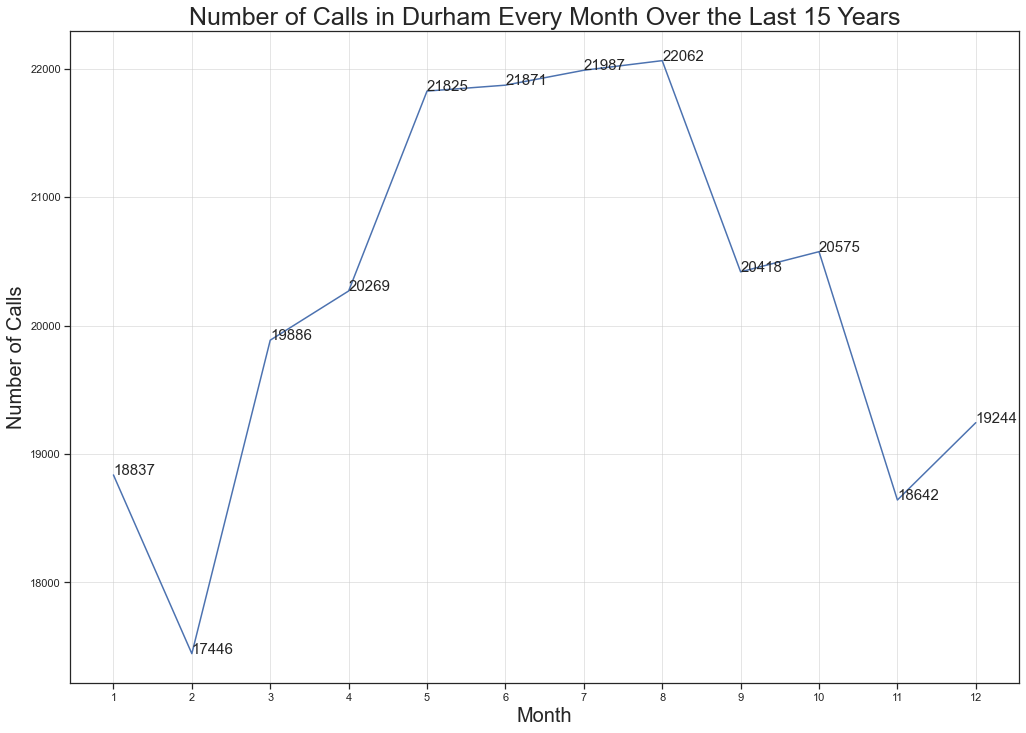

In [53]:
ax = pd.value_counts(dpdcallscombined[dpdcallscombined.MONTH != 24]['MONTH']).sort_index().plot(figsize=(17,12))
ax.set_title("Number of Calls in Durham Every Month Over the Last 15 Years", fontsize=25)
ax.set_xlabel('Month', fontsize=20)
ax.set_ylabel('Number of Calls', fontsize=20)
ticks=dpdcallscombined[dpdcallscombined.MONTH != 24]['MONTH'].unique()
ax.set_xticks(ticks)
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
for i,j in pd.value_counts(dpdcallscombined[dpdcallscombined.MONTH != 24]['MONTH']).sort_index().items():
    ax.annotate(str(j), xy=(i, j), fontsize=15)

In [136]:
callssummedbymonths = dpdcallscombined.groupby(['MONTH']).size().to_frame(name = 'monthcount').reset_index()
callssummedbymonths['monthcountavg']= callssummedbymonths['monthcount'] / 16
callssummedbymonths['monthcountavg'] = callssummedbymonths['monthcountavg'].astype(int)
callssummedbymonths

MONTH  monthcount  monthcountavg
0       1       18837           1177
1       2       17446           1090
2       3       19886           1242
3       4       20269           1266
4       5       21825           1364
5       6       21871           1366
6       7       21987           1374
7       8       22062           1378
8       9       20418           1276
9      10       20575           1285
10     11       18642           1165
11     12       19244           1202

In [137]:
map_dict = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun", 7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}

callssummedbymonths["MONTH"] = callssummedbymonths["MONTH"].map(map_dict)


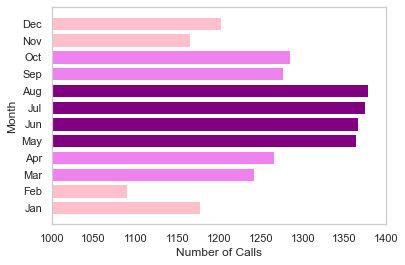

In [138]:
y_axis = callssummedbymonths['MONTH']
x_axis = callssummedbymonths['monthcountavg']

plt.barh(y_axis,x_axis, color=['pink','pink', 'violet','violet', 'purple','purple', 'purple','purple','violet', 'violet', 'pink', 'pink'])
#plt.title('Average Number of Calls in Durham Every Month', fontsize = 15)
plt.ylabel('Month')
plt.xlabel('Number of Calls')
plt.xlim(1000, 1400)
plt.grid(False)
plt.show()

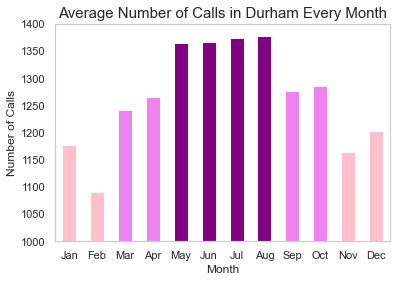

In [140]:
colors = ['pink','pink', 'violet','violet', 'purple','purple', 'purple','purple','violet', 'violet', 'pink', 'pink']

callssummedbymonths.plot.bar(y = 'monthcountavg', x = 'MONTH', color=colors, legend=False, grid=False)

plt.xticks(rotation=0, horizontalalignment="center")

plt.title("Average Number of Calls in Durham Every Month", fontsize = 15)

plt.ylim(1000, 1400)

plt.xlabel('Month')

plt.ylabel('Number of Calls')

plt.show()

In [115]:
assist_list = ['ASSIST PERSON']
dpdcallscombinedassist = dpdcallscombined[dpdcallscombined['Nature'].isin(assist_list)].copy()


In [119]:
assistcallssummedbymonths = dpdcallscombinedassist.groupby(['MONTH']).size().to_frame(name = 'assistcalls').reset_index()
assistcallssummedbymonths['assistcallscount']= assistcallssummedbymonths['assistcalls'] / 16
assistcallssummedbymonths['assistcallscount'] = assistcallssummedbymonths['assistcallscount'].astype(int)
assistcallssummedbymonths["MONTH"] = assistcallssummedbymonths["MONTH"].map(map_dict)
assistcallssummedbymonths

MONTH  assistcalls  assistcallscount
0    Jan        11786               736
1    Feb        10826               676
2    Mar        12195               762
3    Apr        12003               750
4    May        12582               786
5    Jun        12492               780
6    Jul        12467               779
7    Aug        12769               798
8    Sep        11653               728
9    Oct        11916               744
10   Nov        11026               689
11   Dec        11673               729

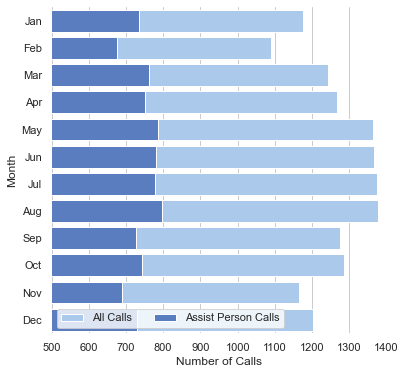

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 6))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="monthcountavg", y="MONTH", data=callssummedbymonths,
            label="All Calls", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="assistcallscount", y="MONTH", data=assistcallssummedbymonths,
            label="Assist Person Calls", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower left", frameon=True)
ax.set(xlim=(500, 1400), ylabel="Month",
       xlabel="Number of Calls")
sns.despine(left=True, bottom=True)

In [123]:
suicide_list = ['SUICIDE THREAT']
dpdcallscombinedsuicide = dpdcallscombined[dpdcallscombined['Nature'].isin(suicide_list)].copy()
crisis_list = ['CRISIS']
dpdcallscombinedcrisis = dpdcallscombined[dpdcallscombined['Nature'].isin(crisis_list)].copy()

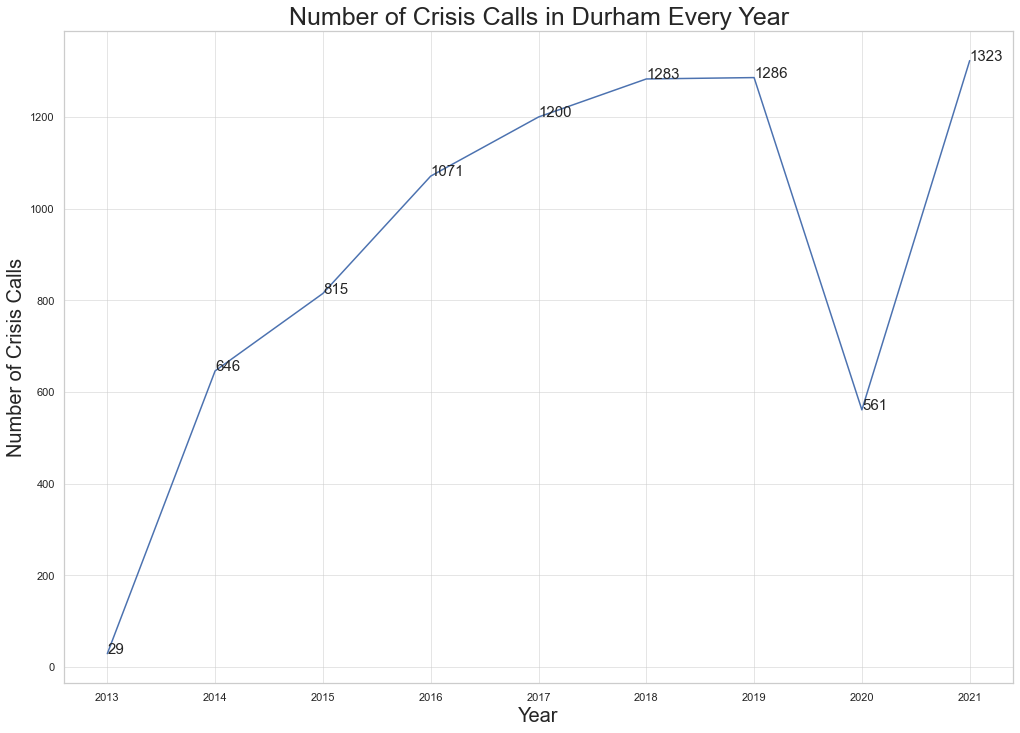

In [124]:
ax = pd.value_counts(dpdcallscombinedcrisis[dpdcallscombinedcrisis.YEAR != 24]['YEAR']).sort_index().plot(figsize=(17,12))
ax.set_title("Number of Crisis Calls in Durham Every Year", fontsize=25)
ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Number of Crisis Calls', fontsize=20)
ticks=dpdcallscombinedcrisis[dpdcallscombinedcrisis.YEAR != 24]['YEAR'].unique()
ax.set_xticks(ticks)
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
for i,j in pd.value_counts(dpdcallscombinedcrisis[dpdcallscombinedcrisis.YEAR != 24]['YEAR']).sort_index().items():
    ax.annotate(str(j), xy=(i, j), fontsize=15)

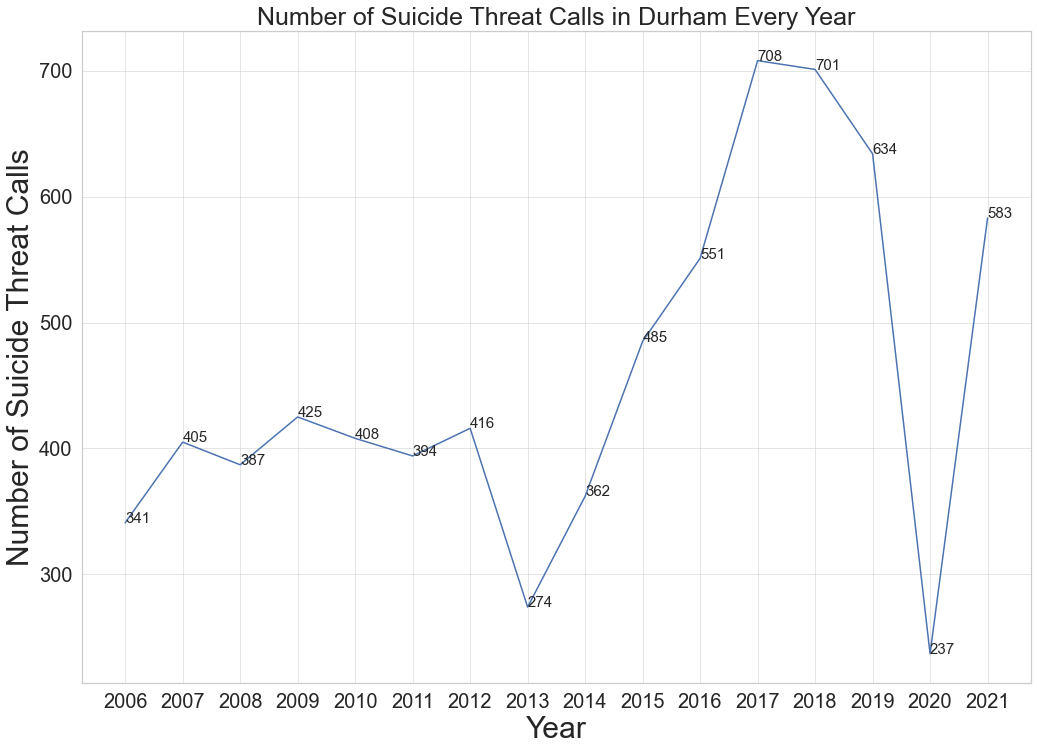

In [141]:
ax = pd.value_counts(dpdcallscombinedsuicide[dpdcallscombinedsuicide.YEAR != 24]['YEAR']).sort_index().plot(figsize=(17,12))
ax.set_title("Number of Suicide Threat Calls in Durham Every Year", fontsize=25)
ax.set_xlabel('Year', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.set_ylabel('Number of Suicide Threat Calls', fontsize=30)
ticks=dpdcallscombinedsuicide[dpdcallscombinedsuicide.YEAR != 24]['YEAR'].unique()
ax.set_xticks(ticks)
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
for i,j in pd.value_counts(dpdcallscombinedsuicide[dpdcallscombinedsuicide.YEAR != 24]['YEAR']).sort_index().items():
    ax.annotate(str(j), xy=(i, j), fontsize=15)

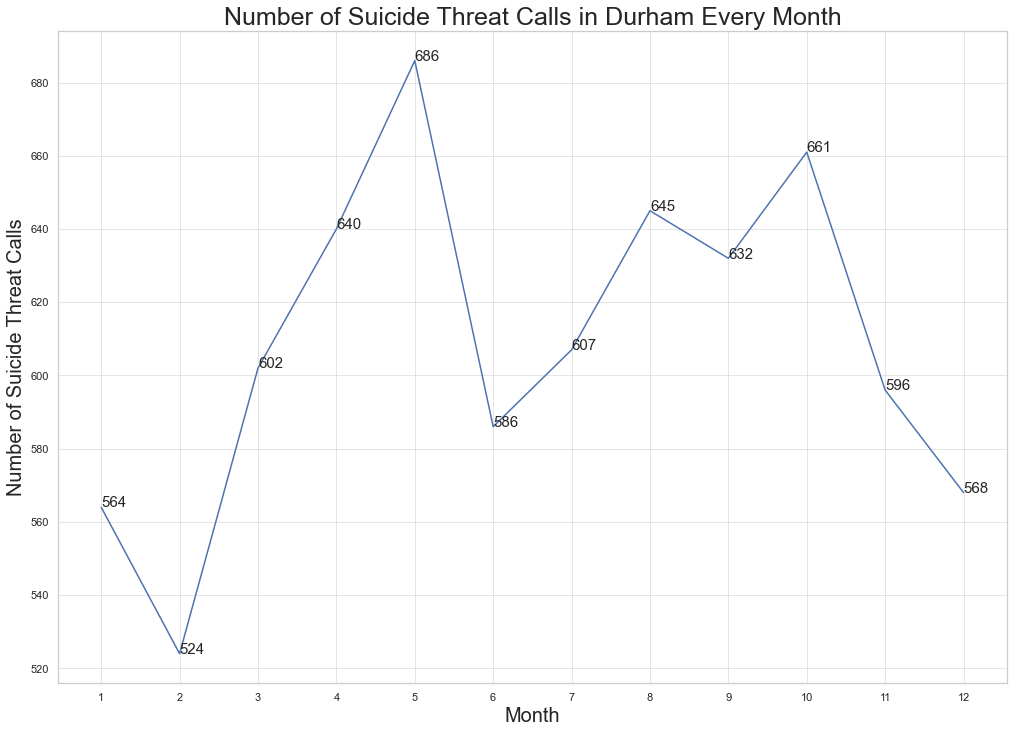

In [130]:
ax = pd.value_counts(dpdcallscombinedsuicide[dpdcallscombinedsuicide.YEAR != 24]['MONTH']).sort_index().plot(figsize=(17,12))
ax.set_title("Number of Suicide Threat Calls in Durham Every Month", fontsize=25)
ax.set_xlabel('Month', fontsize=20)
ax.set_ylabel('Number of Suicide Threat Calls', fontsize=20)
ticks=dpdcallscombinedsuicide[dpdcallscombinedsuicide.YEAR != 24]['MONTH'].unique()
ax.set_xticks(ticks)
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
for i,j in pd.value_counts(dpdcallscombinedsuicide[dpdcallscombinedsuicide.YEAR != 24]['MONTH']).sort_index().items():
    ax.annotate(str(j), xy=(i, j), fontsize=15)

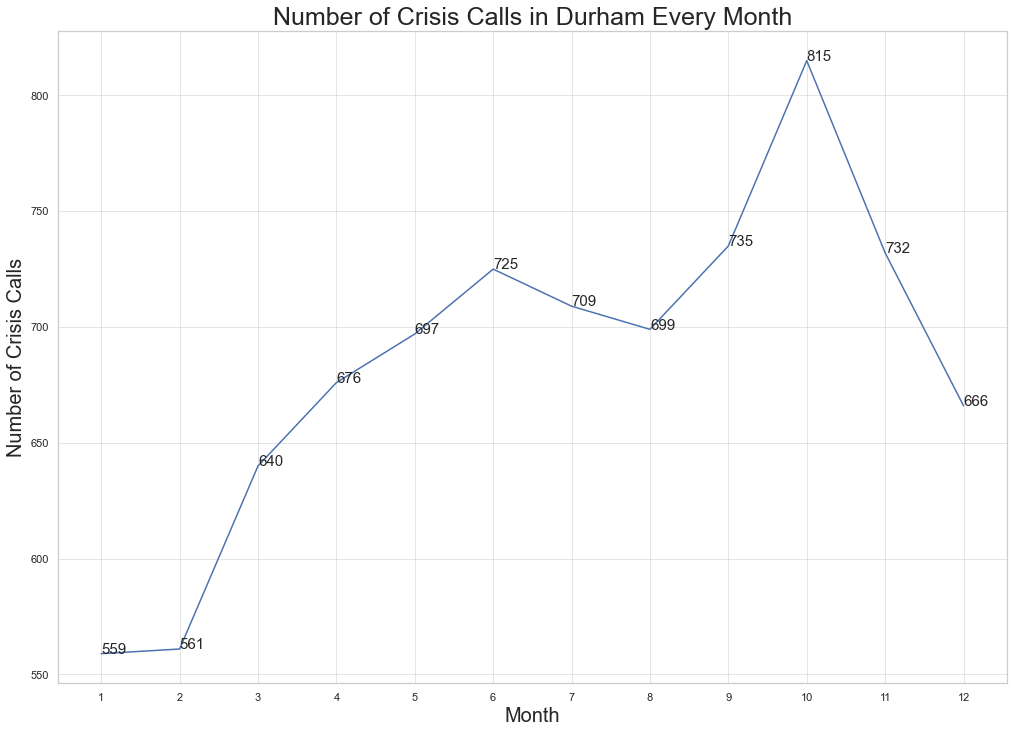

In [143]:
ax = pd.value_counts(dpdcallscombinedcrisis[dpdcallscombinedcrisis.YEAR != 24]['MONTH']).sort_index().plot(figsize=(17,12))
ax.set_title("Number of Crisis Calls in Durham Every Month", fontsize=25)
ax.set_xlabel('Month', fontsize=20)
ax.set_ylabel('Number of Crisis Calls', fontsize=20)
ticks=dpdcallscombinedcrisis[dpdcallscombinedcrisis.YEAR != 24]['MONTH'].unique()
ax.set_xticks(ticks)
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
for i,j in pd.value_counts(dpdcallscombinedcrisis[dpdcallscombinedcrisis.YEAR != 24]['MONTH']).sort_index().items():
    ax.annotate(str(j), xy=(i, j), fontsize=15)

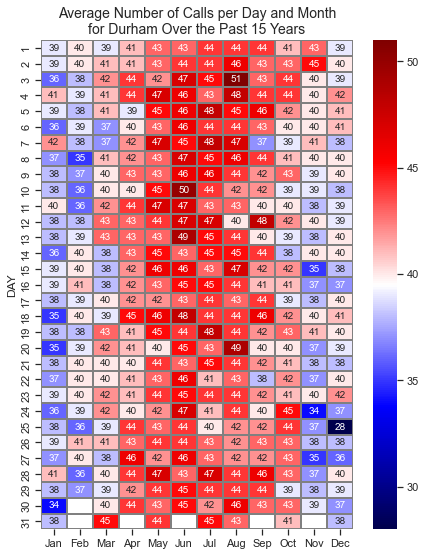

In [996]:
calls_pivot_table = dpdcallscombined[(dpdcallscombined['DATE'] != '2005-06-15')].pivot_table(values='YEAR', index='DAY', columns='MONTH', aggfunc=len)
calls_pivot_table_year_count = dpdcallscombined[(dpdcallscombined['DATE'] != '2005-06-15')].pivot_table(values='YEAR', index='DAY', columns='MONTH', aggfunc=lambda x: len(x.unique()))
calls_average = calls_pivot_table/calls_pivot_table_year_count
calls_average.columns = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

# Using seaborn heatmap
plt.figure(figsize=(7,9))
plt.title('Average Number of Calls per Day and Month\nfor Durham Over the Past 15 Years', fontsize=14)
sns.heatmap(calls_average.round(), cmap='seismic', linecolor='grey',linewidths=0.1, cbar=True, annot=True, fmt=".0f");

In [129]:
dpdcallscombined

Event Numb Case Numbe   Call Date  Call Time             Source  \
0        20090196        NaN   10/3/2020  5:55:18PM         Phone Call   
2        20090198        NaN   10/3/2020  6:03:31PM         Phone Call   
13       20090210        NaN   10/3/2020  6:27:24PM         Phone Call   
26       20090225        NaN   10/3/2020  6:40:56PM         Phone Call   
30       20090237        NaN   10/3/2020  6:49:12PM         Phone Call   
...           ...        ...         ...        ...                ...   
278107   21478051       None  12/31/2021        NaN              E-911   
278116   21478064       None  12/31/2021        NaN  Wireless 911 Call   
278155   21478122       None  12/31/2021        NaN         Phone Call   
278215   21478215       None  12/31/2021        NaN  Wireless 911 Call   
278271   21478336       None  12/31/2021        NaN  Wireless 911 Call   

       Priority                Nature                Address        X       Y  \
0             4         WELFARE CHECK         400 E PILOT ST  2027210  805972   
2             4         ASSIST PERSON       7800 LEONARDO DR  2012737  783053   
13            4         ASSIST PERSON        3800 BOOKER AVE  2027572  801043   
26            4         WELFARE CHECK       1000 W CLUB BLVD  2026731  825554   
30            4         WELFARE CHECK         1700 FOREST RD  2024703  827871   
...         ...                   ...                    ...      ...     ...   
278107        3  TRESPASS OR UNWANTED   3400 HILLSBOROUGH RD  2015445  826468   
278116        3  TRESPASS OR UNWANTED         700 LINDLEY DR  2045812  810608   
278155        2  URGENT WELFARE CHECK   600 W CHAPEL HILL ST  2026386  817495   
278215        2        SUICIDE THREAT    200 N BUCHANAN BLVD  2026005  820358   
278271        3  TRESPASS OR UNWANTED  1600 T W ALEXANDER DR  2045831  791379   

       District Beat               Dispositio  Cancelled  \
0            D4  412  Resolved Without Report          0   
2            D3  324  Resolved Without Report          0   
13           D4  415  Resolved Without Report          0   
26           D2  212  Resolved Without Report          0   
30           D2  212  Resolved Without Report          0   
...         ...  ...                      ...        ...   
278107       D2  221  Resolved Without Report          0   
278116       D1  114  Resolved Without Report          0   
278155       D5  511  Resolved Without Report          0   
278215       D2  212  Resolved Without Report          0   
278271       D4  423                Unfounded          0   

                          geometry       DATE        time  YEAR  MONTH  DAY  \
0       POINT (-78.90805 35.96446) 2020-03-10         NaN  2020      3   10   
2       POINT (-78.95699 35.90152) 2020-03-10         NaN  2020      3   10   
13      POINT (-78.90684 35.95091) 2020-03-10         NaN  2020      3   10   
26      POINT (-78.90961 36.01825) 2020-03-10         NaN  2020      3   10   
30      POINT (-78.91646 36.02462) 2020-03-10         NaN  2020      3   10   
...                            ...        ...         ...   ...    ...  ...   
278107  POINT (-78.94777 36.02078) 2021-12-31   8:29:54PM  2021     12   31   
278116  POINT (-78.84517 35.97713) 2021-12-31   8:36:46PM  2021     12   31   
278155  POINT (-78.91080 35.99611) 2021-12-31   9:21:17PM  2021     12   31   
278215  POINT (-78.91208 36.00398) 2021-12-31  10:36:21PM  2021     12   31   
278271  POINT (-78.84520 35.92430) 2021-12-31  11:51:01PM  2021     12   31   

        DAY_OF_WEEK  
0                 1  
2                 1  
13                1  
26                1  
30                1  
...             ...  
278107            4  
278116            4  
278155            4  
278215            4  
278271            4  

[243062 rows x 21 columns]

In [131]:
import plotly.express as px
fig = px.line(dpdcallscombined, x='YEAR', y='lifeExp', color='Nature', symbol="Nature")
fig.show()

ValueError: Value of 'y' is not the name of a column in 'data_frame'. Expected one of ['Event Numb', 'Case Numbe', 'Call Date', 'Call Time', 'Source', 'Priority', 'Nature', 'Address', 'X', 'Y', 'District', 'Beat', 'Dispositio', 'Cancelled', 'geometry', 'DATE', 'time', 'YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK'] but received: lifeExp

In [605]:
callsperaddress = dpdcalls.groupby( ["Address"] ).size().to_frame(name = 'dpdcalls_count').reset_index()
callsperaddress.sort_values(by='dpdcalls_count', inplace=True, ascending=False)

In [104]:
policebeats = gpd.read_file('/Users/erikrobertsson/Documents/dataplus/Police_Beats/Police_Beats.shp')
policebeats = policebeats.to_crs("4326")
policebeats = policebeats.dissolve(by="LAWBEAT")
policebeats["Beat"] = policebeats.index
policebeats = policebeats.reset_index()
policebeats["id"] = policebeats.index
policebeats

LAWBEAT                                           geometry  OBJECTID  \
0       111  POLYGON ((-78.89039 36.01517, -78.89038 36.015...        50   
1       112  POLYGON ((-78.88787 36.01473, -78.88734 36.014...        51   
2       113  POLYGON ((-78.87372 35.99369, -78.87458 35.991...        62   
3       114  MULTIPOLYGON (((-78.84053 35.95436, -78.84021 ...        65   
4       121  MULTIPOLYGON (((-78.80746 35.99706, -78.80746 ...        38   
..      ...                                                ...       ...   
32      423  MULTIPOLYGON (((-78.83466 35.94599, -78.83463 ...        95   
33      511  POLYGON ((-78.92318 36.01031, -78.92260 36.010...        53   
34      512  POLYGON ((-78.90313 36.00376, -78.90298 36.003...        57   
35      513  POLYGON ((-78.89561 35.99710, -78.89553 35.997...        61   
36      999  MULTIPOLYGON (((-78.94297 35.89150, -78.94296 ...         4   

        PERIMETER STATUS CONTIGUOUS LAWDIST  CAD GIS_DataA1    ShapeSTAre  \
0    28608.800781      I        yes      D1  111       None  2.010252e+07   
1    26265.849609      I        yes      D1  112       None  2.079934e+07   
2    20667.539062      I        yes      D1  113       None  2.159195e+07   
3    53321.980469      I        yes      D1  114       None  6.103382e+07   
4    14495.120117      I         no      D1  121       None  7.008533e+06   
..            ...    ...        ...     ...  ...        ...           ...   
32  151917.093750      I        yes      D4  423       None  2.561465e+08   
33   32615.019531      I        yes      D5  511       None  2.129644e+07   
34   16338.889648      I        yes      D5  512       None  9.305014e+06   
35   20647.179688      I        yes      D5  513       None  9.114313e+06   
36    1308.963013   None       None     DSO  DSO       None  6.932677e+04   

       ShapeSTLen  Beat  id  
0    28608.799743   111   0  
1    26265.852604   112   1  
2    20667.538873   113   2  
3    53321.974873   114   3  
4    14495.120026   121   4  
..            ...   ...  ..  
32  151917.121852   423  32  
33   32615.017763   511  33  
34   16338.888321   512  34  
35   20647.175971   513  35  
36    1308.962953   999  36  

[37 rows x 13 columns]

In [607]:
hispanicdata = pd.read_csv('/Users/erikrobertsson/Documents/dataplus/hispanic data/hispanicdata.csv', skiprows =1)
hispanicdata['GEOID20'] = hispanicdata['id'].str[-15:]
hispanicdata.drop('id', axis=1, inplace=True)
hispanicdata.drop(hispanicdata.iloc[:, 4:74], inplace = True, axis = 1)
hispanicdata.columns = hispanicdata.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
hispanicdata.columns = hispanicdata.columns.str.replace('[#,@,&,!]', '')
hispanicdata.columns = hispanicdata.columns.str.replace('[:]', '_')
hispanicdata.rename(columns = {'total_':'total', 'total_not_hispanic_or_latino_':'total_not_hispanic_or_latino'}, inplace = True)
hispanicdata

geographic_area_name  total  \
0     Block 1000, Block Group 1, Census Tract 1.01, ...    108   
1     Block 1001, Block Group 1, Census Tract 1.01, ...     35   
2     Block 1002, Block Group 1, Census Tract 1.01, ...     38   
3     Block 1003, Block Group 1, Census Tract 1.01, ...     43   
4     Block 1004, Block Group 1, Census Tract 1.01, ...     31   
...                                                 ...    ...   
4396  Block 1068, Block Group 1, Census Tract 9801, ...      0   
4397  Block 1069, Block Group 1, Census Tract 9801, ...      0   
4398  Block 1070, Block Group 1, Census Tract 9801, ...      0   
4399  Block 1071, Block Group 1, Census Tract 9801, ...      0   
4400  Block 1072, Block Group 1, Census Tract 9801, ...      0   

      total_hispanic_or_latino  total_not_hispanic_or_latino          geoid20  
0                           25                            83  370630001011000  
1                           12                            23  370630001011001  
2                            8                            30  370630001011002  
3                            0                            43  370630001011003  
4                            7                            24  370630001011004  
...                        ...                           ...              ...  
4396                         0                             0  370639801001068  
4397                         0                             0  370639801001069  
4398                         0                             0  370639801001070  
4399                         0                             0  370639801001071  
4400                         0                             0  370639801001072  

[4401 rows x 5 columns]

In [608]:
ncblockmap = gpd.read_file('/Users/erikrobertsson/Downloads/Northcarolinablocksshapefiles/tl_2021_37_tabblock20.shp')
ncblockmap = ncblockmap.to_crs("EPSG:4326")
durhamblockmap = ncblockmap[ncblockmap["COUNTYFP20"]=="063"]

In [609]:
durhamhispanicmap = pd.merge(hispanicdata, durhamblockmap, left_on ='geoid20', right_on='GEOID20')
durhamhispanicmap.drop(['MTFCC20', 'UATYPE20', 'FUNCSTAT20', 'ALAND20', 'AWATER20', 'BLOCKCE20', 'TRACTCE20', 'UR20', 'UACE20', 'geoid20', 'STATEFP20', 'NAME20'], axis=1, inplace=True)
durhamhispanicmap

geographic_area_name  total  \
0     Block 1000, Block Group 1, Census Tract 1.01, ...    108   
1     Block 1001, Block Group 1, Census Tract 1.01, ...     35   
2     Block 1002, Block Group 1, Census Tract 1.01, ...     38   
3     Block 1003, Block Group 1, Census Tract 1.01, ...     43   
4     Block 1004, Block Group 1, Census Tract 1.01, ...     31   
...                                                 ...    ...   
4396  Block 1068, Block Group 1, Census Tract 9801, ...      0   
4397  Block 1069, Block Group 1, Census Tract 9801, ...      0   
4398  Block 1070, Block Group 1, Census Tract 9801, ...      0   
4399  Block 1071, Block Group 1, Census Tract 9801, ...      0   
4400  Block 1072, Block Group 1, Census Tract 9801, ...      0   

      total_hispanic_or_latino  total_not_hispanic_or_latino COUNTYFP20  \
0                           25                            83        063   
1                           12                            23        063   
2                            8                            30        063   
3                            0                            43        063   
4                            7                            24        063   
...                        ...                           ...        ...   
4396                         0                             0        063   
4397                         0                             0        063   
4398                         0                             0        063   
4399                         0                             0        063   
4400                         0                             0        063   

              GEOID20   INTPTLAT20    INTPTLON20  \
0     370630001011000  +36.0194814  -078.8821382   
1     370630001011001  +36.0205516  -078.8893121   
2     370630001011002  +36.0205916  -078.8869754   
3     370630001011003  +36.0205318  -078.8880959   
4     370630001011004  +36.0221289  -078.8796703   
...               ...          ...           ...   
4396  370639801001068  +35.8697575  -078.8648679   
4397  370639801001069  +35.8691012  -078.8652956   
4398  370639801001070  +35.8687255  -078.8673419   
4399  370639801001071  +35.8957583  -078.8703320   
4400  370639801001072  +35.9385678  -078.8788750   

                                               geometry  
0     POLYGON ((-78.88999 36.01852, -78.88995 36.019...  
1     POLYGON ((-78.88993 36.02006, -78.88990 36.021...  
2     POLYGON ((-78.88749 36.02015, -78.88746 36.021...  
3     POLYGON ((-78.88872 36.01988, -78.88867 36.021...  
4     POLYGON ((-78.88098 36.02211, -78.87993 36.022...  
...                                                 ...  
4396  POLYGON ((-78.86527 35.87076, -78.86499 35.870...  
4397  POLYGON ((-78.86569 35.87062, -78.86540 35.870...  
4398  POLYGON ((-78.87004 35.86799, -78.86978 35.868...  
4399  POLYGON ((-78.87243 35.89600, -78.87216 35.896...  
4400  POLYGON ((-78.87930 35.93618, -78.87928 35.937...  

[4401 rows x 9 columns]

In [610]:
#Assign each census block to a police beat with for loop
cblockIndexToBeat = {}
sIndex = policebeats.sindex

for cblock_ind in durhamblockmap.index:
    cblock_geom = durhamblockmap.loc[cblock_ind]["geometry"]
    possibleBeatMatches = list(sIndex.intersection(cblock_geom.bounds))
    matched = False

    if len(possibleBeatMatches) > 0:
        possibleMatches = policebeats.iloc[possibleBeatMatches]
        intersectingAreas = possibleMatches.intersection(cblock_geom).area
        intersectingAreas /= cblock_geom.area
        police_beat_index = intersectingAreas.idxmax()
        maxIntersection = intersectingAreas.max()
    ##########
        if maxIntersection < 0.1:
            continue
    ##########
        if maxIntersection > 0:
            cblockIndexToBeat[cblock_ind] = policebeats.loc[police_beat_index]['LAWBEAT']
            matched = True

cblockDurhamBeats = ncblockmap[ncblockmap.index.isin(cblockIndexToBeat)]
cblockDurhamBeats['Beat'] = cblockDurhamBeats.index.map(lambda ii: cblockIndexToBeat[ii])

warnings.filterwarnings('ignore')

In [611]:
cblockcommsafebeats = cblockDurhamBeats.copy()
commsafe_list = [511, 512, 513, 411, 113, 112, 214, 223]
cblockcommsafebeats = cblockDurhamBeats.loc[cblockDurhamBeats['Beat'].isin(commsafe_list)].copy()
cblockcommsafebeats

STATEFP20 COUNTYFP20 TRACTCE20 BLOCKCE20          GEOID20      NAME20  \
874           37        063    001709      3001  370630017093001  Block 3001   
3649          37        063    001801      6041  370630018016041  Block 6041   
10725         37        063    001001      1004  370630010011004  Block 1004   
10944         37        063    000101      1028  370630001011028  Block 1028   
11876         37        063    001801      6033  370630018016033  Block 6033   
...          ...        ...       ...       ...              ...         ...   
235109        37        063    002200      2031  370630022002031  Block 2031   
235830        37        063    002300      1027  370630023001027  Block 1027   
236139        37        063    002200      2048  370630022002048  Block 2048   
236183        37        063    002200      1012  370630022001012  Block 1012   
236438        37        063    001301      1001  370630013011001  Block 1001   

       MTFCC20 UR20 UACE20 UATYPE20 FUNCSTAT20  ALAND20  AWATER20  \
874      G5040    R   None     None          S   918860      1497   
3649     G5040    R   None     None          S   212123      9487   
10725    G5040    R   None     None          S    66462      1025   
10944    G5040    R   None     None          S   435000      2847   
11876    G5040    R   None     None          S   131608      6435   
...        ...  ...    ...      ...        ...      ...       ...   
235109   G5040    R   None     None          S    14546         0   
235830   G5040    R   None     None          S    57219         0   
236139   G5040    R   None     None          S    10849         0   
236183   G5040    R   None     None          S    11653         0   
236438   G5040    R   None     None          S    40022         0   

         INTPTLAT20    INTPTLON20  \
874     +36.0511955  -078.8989718   
3649    +36.0155379  -078.8706505   
10725   +35.9935665  -078.8850882   
10944   +36.0161756  -078.8795383   
11876   +36.0263370  -078.8611270   
...             ...           ...   
235109  +35.9983414  -078.8990835   
235830  +35.9854948  -078.9077482   
236139  +35.9949422  -078.8981501   
236183  +36.0007075  -078.9093748   
236438  +35.9810471  -078.8944621   

                                                 geometry  Beat  
874     POLYGON ((-78.90312 36.05133, -78.90294 36.051...   223  
3649    POLYGON ((-78.87550 36.01421, -78.87371 36.014...   214  
10725   POLYGON ((-78.88599 35.99352, -78.88596 35.994...   113  
10944   POLYGON ((-78.88806 36.01514, -78.88790 36.015...   214  
11876   POLYGON ((-78.86503 36.02665, -78.86499 36.026...   214  
...                                                   ...   ...  
235109  POLYGON ((-78.89994 35.99915, -78.89961 35.998...   512  
235830  POLYGON ((-78.90906 35.98449, -78.90900 35.984...   411  
236139  POLYGON ((-78.89883 35.99520, -78.89876 35.995...   512  
236183  POLYGON ((-78.90950 36.00138, -78.90934 36.001...   511  
236438  POLYGON ((-78.89541 35.98186, -78.89539 35.981...   411  

[526 rows x 17 columns]

In [612]:
durhamhispanicmap = durhamblockmap.set_index('GEOID20').join(hispanicdata.set_index('geoid20'))
durhamhispanicmap.drop(['MTFCC20', 'UATYPE20', 'FUNCSTAT20', 'ALAND20', 'AWATER20', 'BLOCKCE20', 'TRACTCE20', 'UR20', 'UACE20', 'STATEFP20', 'NAME20'], axis=1, inplace=True)
durhamhispanicmap.head(3)

COUNTYFP20   INTPTLAT20    INTPTLON20  \
GEOID20                                                 
370630018064007        063  +36.0127651  -078.8227713   
370630018017028        063  +36.0696478  -078.7923950   
370630021004022        063  +36.1529771  -078.8218382   

                                                          geometry  \
GEOID20                                                              
370630018064007  POLYGON ((-78.82464 36.01317, -78.82456 36.013...   
370630018017028  POLYGON ((-78.80507 36.06321, -78.80468 36.063...   
370630021004022  POLYGON ((-78.83005 36.15073, -78.83001 36.150...   

                                              geographic_area_name  total  \
GEOID20                                                                     
370630018064007  Block 4007, Block Group 4, Census Tract 18.06,...     80   
370630018017028  Block 7028, Block Group 7, Census Tract 18.01,...      0   
370630021004022  Block 4022, Block Group 4, Census Tract 21, Du...     88   

                 total_hispanic_or_latino  total_not_hispanic_or_latino  
GEOID20                                                                  
370630018064007                        33                            47  
370630018017028                         0                             0  
370630021004022                         0                            88

In [613]:
blockswithhispanics = gpd.sjoin(durhamhispanicmap, cblockcommsafebeats)
blockswithhispanics['prophispanic']= blockswithhispanics['total_hispanic_or_latino'] / blockswithhispanics['total']
blockswithhispanics.head(3)

COUNTYFP20_left INTPTLAT20_left INTPTLON20_left  \
GEOID20                                                           
370630018017041             063     +36.0558254    -078.8296616   
370630018016014             063     +36.0496473    -078.8467110   
370630018016009             063     +36.0426464    -078.8352676   

                                                          geometry  \
GEOID20                                                              
370630018017041  POLYGON ((-78.83393 36.05431, -78.83344 36.055...   
370630018016014  POLYGON ((-78.85572 36.04408, -78.85557 36.044...   
370630018016009  POLYGON ((-78.84667 36.03546, -78.84547 36.037...   

                                              geographic_area_name  total  \
GEOID20                                                                     
370630018017041  Block 7041, Block Group 7, Census Tract 18.01,...      9   
370630018016014  Block 6014, Block Group 6, Census Tract 18.01,...    195   
370630018016009  Block 6009, Block Group 6, Census Tract 18.01,...     97   

                 total_hispanic_or_latino  total_not_hispanic_or_latino  \
GEOID20                                                                   
370630018017041                         3                             6   
370630018016014                        79                           116   
370630018016009                        27                            70   

                 index_right STATEFP20 COUNTYFP20_right TRACTCE20 BLOCKCE20  \
GEOID20                                                                       
370630018017041       225453        37              063    001801      6008   
370630018016014       225453        37              063    001801      6008   
370630018016009       225453        37              063    001801      6008   

                         GEOID20      NAME20 MTFCC20 UR20 UACE20 UATYPE20  \
GEOID20                                                                     
370630018017041  370630018016008  Block 6008   G5040    R   None     None   
370630018016014  370630018016008  Block 6008   G5040    R   None     None   
370630018016009  370630018016008  Block 6008   G5040    R   None     None   

                FUNCSTAT20  ALAND20  AWATER20 INTPTLAT20_right  \
GEOID20                                                          
370630018017041          S   100889         0      +36.0519717   
370630018016014          S   100889         0      +36.0519717   
370630018016009          S   100889         0      +36.0519717   

                INTPTLON20_right  Beat  prophispanic  
GEOID20                                               
370630018017041     -078.8336224   214      0.333333  
370630018016014     -078.8336224   214      0.405128  
370630018016009     -078.8336224   214      0.278351

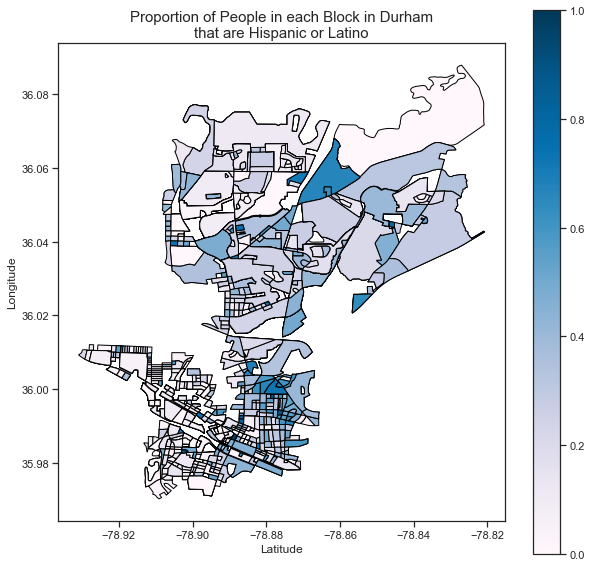

In [614]:
#Plot chloropleth map with merged data
fig, ax = plt.subplots(figsize = (10,10))
blockswithhispanics.plot(column='prophispanic',
                                legend=True,
                                cmap="PuBu", ax=ax, aspect=1, edgecolor = 'black');

# ax.set(title='Number of Calls by Police Beat')
plt.title("Proportion of People in each Block in Durham\nthat are Hispanic or Latino", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

start of checking how callcountperperson correlates with a beats popdensity

In [615]:
beatswithhispanics = pd.merge(cblockDurhamBeats, hispanicdata, left_on ='GEOID20', right_on='geoid20')
#beatswithhispanics = gpd.sjoin(cblockDurhamBeats, durhamhispanicmap)
popsumbybeat = beatswithhispanics.groupby('Beat', as_index=False).sum()
popsumbybeat

Beat   ALAND20  AWATER20  total  total_hispanic_or_latino  \
0    111   1885019         0   3949                      1130   
1    112   1863048         0   3083                      1366   
2    113   2056983      1025   4094                      1038   
3    114   5975063     40919   5631                      1756   
4    121  12440369    123268   8025                      1803   
..   ...       ...       ...    ...                       ...   
32   423  25160283    240192  15092                      1231   
33   511   2044774         0   5505                       385   
34   512    882799         0   1646                       119   
35   513    797193         0   1677                       180   
36   999   2187405     14257    194                        43   

    total_not_hispanic_or_latino  
0                           2819  
1                           1717  
2                           3056  
3                           3875  
4                           6222  
..                           ...  
32                         13861  
33                          5120  
34                          1527  
35                          1497  
36                           151  

[37 rows x 6 columns]

In [616]:
popsumbybeat['total'].sum()


284780

In [136]:
beatswithcalls2006 = gpd.sjoin(policebeats, dpdcalls2006)
callssummedinbeats2006 = beatswithcalls2006.groupby(['LAWBEAT']).size().to_frame(name = '2006calls_count').reset_index()
callssummedinbeats2006.sort_values(by='2006calls_count', inplace=True, ascending=False)
callssummedinbeats2006['2006propofallcalls']= callssummedinbeats2006['2006calls_count'] / 15487
callssummedinbeats2006.sort_values(by='2006propofallcalls', inplace=True, ascending=False)

#callssummedinbeats2017['year']= '2017'
callssummedinbeats2006.head()

LAWBEAT  2006calls_count  2006propofallcalls
32     511              679            0.043843
24     411              660            0.042616
9      212              618            0.039904
0      111              579            0.037386
10     213              575            0.037128

In [135]:
beatswithcalls2007 = gpd.sjoin(policebeats, dpdcalls2007)
callssummedinbeats2007 = beatswithcalls2007.groupby(['LAWBEAT']).size().to_frame(name = '2007calls_count').reset_index()
callssummedinbeats2007['2007propofallcalls']= callssummedinbeats2007['2007calls_count'] / 15235
callssummedinbeats2007.sort_values(by='2007propofallcalls', inplace=True, ascending=False)

#callssummedinbeats2017['year']= '2017'
callssummedinbeats2007.head()

LAWBEAT  2007calls_count  2007propofallcalls
32     511              642            0.042140
24     411              624            0.040958
17     312              607            0.039842
1      112              566            0.037151
10     213              563            0.036954

In [134]:
beatswithcalls2008 = gpd.sjoin(policebeats, dpdcalls2008)
callssummedinbeats2008 = beatswithcalls2008.groupby(['LAWBEAT']).size().to_frame(name = '2008calls_count').reset_index()
callssummedinbeats2008.sort_values(by='2008calls_count', inplace=True, ascending=False)
callssummedinbeats2008['2008propofallcalls']= callssummedinbeats2008['2008calls_count'] / 15779
callssummedinbeats2008.sort_values(by='2008propofallcalls', inplace=True, ascending=False)

#callssummedinbeats2017['year']= '2017'
callssummedinbeats2008.head()

LAWBEAT  2008calls_count  2008propofallcalls
32     511              675            0.042778
24     411              624            0.039546
1      112              586            0.037138
2      113              582            0.036884
0      111              581            0.036821

In [133]:
beatswithcalls2009 = gpd.sjoin(policebeats, dpdcalls2009)
callssummedinbeats2009 = beatswithcalls2009.groupby(['LAWBEAT']).size().to_frame(name = '2009calls_count').reset_index()
callssummedinbeats2009.sort_values(by='2009calls_count', inplace=True, ascending=False)
callssummedinbeats2009['2009propofallcalls']= callssummedinbeats2009['2009calls_count'] / 16805
callssummedinbeats2009.sort_values(by='2009propofallcalls', inplace=True, ascending=False)
#callssummedinbeats2017['year']= '2017'
callssummedinbeats2009.head()

LAWBEAT  2009calls_count  2009propofallcalls
33     511              750            0.044630
0      111              618            0.036775
25     411              616            0.036656
1      112              612            0.036418
5      122              602            0.035823

In [132]:
beatswithcalls2010 = gpd.sjoin(policebeats, dpdcalls2010)
callssummedinbeats2010 = beatswithcalls2010.groupby(['LAWBEAT']).size().to_frame(name = '2010calls_count').reset_index()
callssummedinbeats2010.sort_values(by='2010calls_count', inplace=True, ascending=False)
callssummedinbeats2010['2010propofallcalls']= callssummedinbeats2010['2010calls_count'] / 16856
callssummedinbeats2010.sort_values(by='2010propofallcalls', inplace=True, ascending=False)

#callssummedinbeats2017['year']= '2017'
callssummedinbeats2010.head()

LAWBEAT  2010calls_count  2010propofallcalls
14     223              609            0.036130
5      122              594            0.035240
32     511              589            0.034943
26     413              589            0.034943
0      111              582            0.034528

In [131]:
beatswithcalls2011 = gpd.sjoin(policebeats, dpdcalls2011)
callssummedinbeats2011 = beatswithcalls2011.groupby(['LAWBEAT']).size().to_frame(name = '2011calls_count').reset_index()
callssummedinbeats2011.sort_values(by='2011calls_count', inplace=True, ascending=False)
callssummedinbeats2011['2011propofallcalls']= callssummedinbeats2011['2011calls_count'] / 16539
callssummedinbeats2011.sort_values(by='2011propofallcalls', inplace=True, ascending=False)

#callssummedinbeats2017['year']= '2017'
callssummedinbeats2011.head()

LAWBEAT  2011calls_count  2011propofallcalls
32     511              689            0.041659
14     223              612            0.037003
18     313              595            0.035976
25     412              583            0.035250
29     421              582            0.035190

In [128]:
beatswithcalls2012 = gpd.sjoin(policebeats, dpdcalls2012)
callssummedinbeats2012 = beatswithcalls2012.groupby(['LAWBEAT']).size().to_frame(name = '2012calls_count').reset_index()
callssummedinbeats2012.sort_values(by='2012calls_count', inplace=True, ascending=False)
callssummedinbeats2012['2012propofallcalls']= callssummedinbeats2012['2012calls_count'] / 17437
callssummedinbeats2012.sort_values(by='2012propofallcalls', inplace=True, ascending=False)
#callssummedinbeats2017['year']= '2017'
callssummedinbeats2012.head()

LAWBEAT  2012calls_count  2012propofallcalls
32     511              692            0.039686
11     214              657            0.037678
14     223              647            0.037105
18     313              633            0.036302
25     412              613            0.035155

In [127]:
beatswithcalls2013 = gpd.sjoin(policebeats, dpdcalls2013)
callssummedinbeats2013 = beatswithcalls2013.groupby(['LAWBEAT']).size().to_frame(name = '2013calls_count').reset_index()
callssummedinbeats2013['2013propofallcalls']= callssummedinbeats2013['2013calls_count'] / 14906
callssummedinbeats2013.sort_values(by='2013propofallcalls', inplace=True, ascending=False)
#callssummedinbeats2017['year']= '2017'
callssummedinbeats2013.head()

LAWBEAT  2013calls_count  2013propofallcalls
18     313              644            0.043204
32     511              608            0.040789
5      122              577            0.038709
0      111              557            0.037368
25     412              507            0.034013

In [137]:
beatswithcalls2014 = gpd.sjoin(policebeats, dpdcalls2014)
callssummedinbeats2014 = beatswithcalls2014.groupby(['LAWBEAT']).size().to_frame(name = '2014calls_count').reset_index()
#callssummedinbeats2017['year']= '2017'
callssummedinbeats2014['2014propofallcalls']= callssummedinbeats2014['2014calls_count'] / 14227
callssummedinbeats2014.sort_values(by='2014propofallcalls', inplace=True, ascending=False)

callssummedinbeats2014.head()

LAWBEAT  2014calls_count  2014propofallcalls
33     511              587            0.041260
19     313              539            0.037886
0      111              538            0.037815
5      122              488            0.034301
2      113              481            0.033809

In [138]:
beatswithcalls2015 = gpd.sjoin(policebeats, dpdcalls2015)
callssummedinbeats2015 = beatswithcalls2015.groupby(['LAWBEAT']).size().to_frame(name = '2015calls_count').reset_index()
#callssummedinbeats2017['year']= '2017'
callssummedinbeats2015['2015propofallcalls']= callssummedinbeats2015['2015calls_count'] / 15273
callssummedinbeats2015.sort_values(by='2015propofallcalls', inplace=True, ascending=False)


callssummedinbeats2015.head()

LAWBEAT  2015calls_count  2015propofallcalls
32     511              616            0.040333
5      122              559            0.036601
2      113              534            0.034964
13     222              521            0.034112
12     221              520            0.034047

In [140]:
beatswithcalls2016 = gpd.sjoin(policebeats, dpdcalls2016)
callssummedinbeats2016 = beatswithcalls2016.groupby(['LAWBEAT']).size().to_frame(name = '2016calls_count').reset_index()
#callssummedinbeats2017['year']= '2017'
callssummedinbeats2016['2016propofallcalls']= callssummedinbeats2016['2016calls_count'] / 15324
callssummedinbeats2016.sort_values(by='2016propofallcalls', inplace=True, ascending=False)

callssummedinbeats2016.head()

LAWBEAT  2016calls_count  2016propofallcalls
33     511              729            0.047572
5      122              605            0.039481
8      211              552            0.036022
35     513              550            0.035891
12     221              531            0.034652

In [141]:
beatswithcalls2017 = gpd.sjoin(policebeats, dpdcalls2017)
callssummedinbeats2017 = beatswithcalls2017.groupby(['LAWBEAT']).size().to_frame(name = '2017calls_count').reset_index()
#callssummedinbeats2017['year']= '2017'
callssummedinbeats2017['2017propofallcalls']= callssummedinbeats2017['2017calls_count'] / 14772
callssummedinbeats2017.sort_values(by='2017propofallcalls', inplace=True, ascending=False)

callssummedinbeats2017.head()

LAWBEAT  2017calls_count  2017propofallcalls
24     411              608            0.041159
32     511              608            0.041159
2      113              590            0.039940
8      211              546            0.036962
14     223              542            0.036691

In [142]:
beatswithcalls2018 = gpd.sjoin(policebeats, dpdcalls2018)
callssummedinbeats2018 = beatswithcalls2018.groupby(['LAWBEAT']).size().to_frame(name = '2018calls_count').reset_index()
#callssummedinbeats2018['year']= '2018'
callssummedinbeats2018['2018propofallcalls']= callssummedinbeats2018['2018calls_count'] / 13708
callssummedinbeats2018.sort_values(by='2018propofallcalls', inplace=True, ascending=False)

callssummedinbeats2018.head()

LAWBEAT  2018calls_count  2018propofallcalls
32     511              569            0.041509
8      211              550            0.040123
24     411              518            0.037788
14     223              499            0.036402
1      112              496            0.036183

In [143]:
beatswithcalls2019 = gpd.sjoin(policebeats, dpdcalls2019)
callssummedinbeats2019 = beatswithcalls2019.groupby(['LAWBEAT']).size().to_frame(name = '2019calls_count').reset_index()
#callssummedinbeats2019['year']= '2019'
callssummedinbeats2019['2019propofallcalls']= callssummedinbeats2019['2019calls_count'] / 13891
callssummedinbeats2019.sort_values(by='2019propofallcalls', inplace=True, ascending=False)

callssummedinbeats2019.head()

LAWBEAT  2019calls_count  2019propofallcalls
32     511              656            0.047225
34     513              544            0.039162
24     411              531            0.038226
1      112              529            0.038082
30     422              526            0.037866

In [144]:
beatswithcalls2020 = gpd.sjoin(policebeats, dpdcalls2020)
callssummedinbeats2020 = beatswithcalls2020.groupby(['LAWBEAT']).size().to_frame(name = '2020calls_count').reset_index()
#callssummedinbeats2020['year']= '2020'
callssummedinbeats2020['2020propofallcalls']= callssummedinbeats2020['2020calls_count'] / 12066
callssummedinbeats2020.sort_values(by='2020propofallcalls', inplace=True, ascending=False)

beatswithcalls2020 = pd.merge(policebeats, callssummedinbeats2020, on ='LAWBEAT')
beatswithcalls2020['year']= '2020'
beatswithcalls2020
callssummedinbeats2020.head()

LAWBEAT  2020calls_count  2020propofallcalls
12     221              598            0.049561
8      211              496            0.041107
14     223              480            0.039781
30     422              464            0.038455
1      112              459            0.038041

In [145]:
beatswithcalls2021 = gpd.sjoin(policebeats, dpdcalls)
callssummedinbeats2021 = beatswithcalls2021.groupby(['LAWBEAT']).size().to_frame(name = '2021calls_count').reset_index()
#callssummedinbeats2021['year']= '2021'
callssummedinbeats2021['2021propofallcalls']= callssummedinbeats2021['2021calls_count'] / 14757
callssummedinbeats2021.sort_values(by='2021propofallcalls', inplace=True, ascending=False)

#callssummedinbeats2021 = pd.merge(callssummedinbeats2021, callssummedinbeats2020, on ='LAWBEAT')
beatswithcalls2021 = pd.merge(policebeats, callssummedinbeats2021, on ='LAWBEAT')
beatswithcalls2021['year']= '2021'
beatswithcalls2021['LAWBEAT']= beatswithcalls2021['LAWBEAT'].map(str)
beatswithcalls2021['year'] = beatswithcalls2021['year'].astype(str)
callssummedinbeats2021.head()

LAWBEAT  2021calls_count  2021propofallcalls
8      211              746            0.050552
14     223              630            0.042692
12     221              623            0.042217
31     423              568            0.038490
11     214              563            0.038151

<AxesSubplot:>

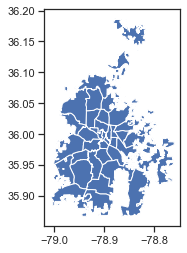

In [635]:
policebeats.plot()

In [122]:
merged = policebeats.set_index('LAWBEAT').join(callssummedinbeats2021.set_index('LAWBEAT'))
merged.head()

geometry  OBJECTID  \
LAWBEAT                                                                
111      POLYGON ((-78.89039 36.01517, -78.89038 36.015...        50   
112      POLYGON ((-78.88787 36.01473, -78.88734 36.014...        51   
113      POLYGON ((-78.87372 35.99369, -78.87458 35.991...        62   
114      MULTIPOLYGON (((-78.84053 35.95436, -78.84021 ...        65   
121      MULTIPOLYGON (((-78.80746 35.99706, -78.80746 ...        38   

            PERIMETER STATUS CONTIGUOUS LAWDIST  CAD GIS_DataA1    ShapeSTAre  \
LAWBEAT                                                                         
111      28608.800781      I        yes      D1  111       None  2.010252e+07   
112      26265.849609      I        yes      D1  112       None  2.079934e+07   
113      20667.539062      I        yes      D1  113       None  2.159195e+07   
114      53321.980469      I        yes      D1  114       None  6.103382e+07   
121      14495.120117      I         no      D1  121       None  7.008533e+06   

           ShapeSTLen  Beat  id  2021calls_count  2021propofallcalls  
LAWBEAT                                                               
111      28608.799743   111   0            376.0            0.025479  
112      26265.852604   112   1            365.0            0.024734  
113      20667.538873   113   2            470.0            0.031849  
114      53321.974873   114   3            343.0            0.023243  
121      14495.120026   121   4            261.0            0.017687

In [123]:
callssummedinbeats2021.dtypes

LAWBEAT                 int64
2021calls_count         int64
2021propofallcalls    float64
dtype: object

In [638]:
callssummedinbeats2020.dtypes

LAWBEAT            int64
2020calls_count    int64
dtype: object

In [639]:
callssummedinbeats2008.dtypes

LAWBEAT            int64
2008calls_count    int64
dtype: object

In [124]:
beatsforallyears = pd.merge(callssummedinbeats2021, callssummedinbeats2020, on ='LAWBEAT')
beatsforallyears = pd.merge(beatsforallyears, callssummedinbeats2019, on ='LAWBEAT')
beatsforallyears = pd.merge(beatsforallyears, callssummedinbeats2018, on ='LAWBEAT')
beatsforallyears = pd.merge(beatsforallyears, callssummedinbeats2017, on ='LAWBEAT')
beatsforallyears = pd.merge(beatsforallyears, callssummedinbeats2016, on ='LAWBEAT')
beatsforallyears = pd.merge(beatsforallyears, callssummedinbeats2015, on ='LAWBEAT')
beatsforallyears = pd.merge(beatsforallyears, callssummedinbeats2014, on ='LAWBEAT')
beatsforallyears = pd.merge(beatsforallyears, callssummedinbeats2013, on ='LAWBEAT')
beatsforallyears = pd.merge(beatsforallyears, callssummedinbeats2012, on ='LAWBEAT')
beatsforallyears = pd.merge(beatsforallyears, callssummedinbeats2011, on ='LAWBEAT')
beatsforallyears = pd.merge(beatsforallyears, callssummedinbeats2010, on ='LAWBEAT')
beatsforallyears = pd.merge(beatsforallyears, callssummedinbeats2009, on ='LAWBEAT')
beatsforallyears = pd.merge(beatsforallyears, callssummedinbeats2008, on ='LAWBEAT')
beatsforallyears = pd.merge(beatsforallyears, callssummedinbeats2007, on ='LAWBEAT')
beatsforallyears = pd.merge(beatsforallyears, callssummedinbeats2006, on ='LAWBEAT')
beatsforallyears['LAWBEAT']= beatsforallyears['LAWBEAT'].map(str)
policebeats['LAWBEAT']= policebeats['LAWBEAT'].map(str)
beatsforallyears = pd.merge(policebeats, beatsforallyears, on ='LAWBEAT')
beatsforallyears

LAWBEAT                                           geometry  OBJECTID  \
0      111  POLYGON ((-78.89039 36.01517, -78.89038 36.015...        50   
1      112  POLYGON ((-78.88787 36.01473, -78.88734 36.014...        51   
2      113  POLYGON ((-78.87372 35.99369, -78.87458 35.991...        62   
3      114  MULTIPOLYGON (((-78.84053 35.95436, -78.84021 ...        65   
4      121  MULTIPOLYGON (((-78.80746 35.99706, -78.80746 ...        38   
..     ...                                                ...       ...   
31     423  MULTIPOLYGON (((-78.83466 35.94599, -78.83463 ...        95   
32     511  POLYGON ((-78.92318 36.01031, -78.92260 36.010...        53   
33     512  POLYGON ((-78.90313 36.00376, -78.90298 36.003...        57   
34     513  POLYGON ((-78.89561 35.99710, -78.89553 35.997...        61   
35     999  MULTIPOLYGON (((-78.94297 35.89150, -78.94296 ...         4   

        PERIMETER STATUS CONTIGUOUS LAWDIST  CAD GIS_DataA1    ShapeSTAre  \
0    28608.800781      I        yes      D1  111       None  2.010252e+07   
1    26265.849609      I        yes      D1  112       None  2.079934e+07   
2    20667.539062      I        yes      D1  113       None  2.159195e+07   
3    53321.980469      I        yes      D1  114       None  6.103382e+07   
4    14495.120117      I         no      D1  121       None  7.008533e+06   
..            ...    ...        ...     ...  ...        ...           ...   
31  151917.093750      I        yes      D4  423       None  2.561465e+08   
32   32615.019531      I        yes      D5  511       None  2.129644e+07   
33   16338.889648      I        yes      D5  512       None  9.305014e+06   
34   20647.179688      I        yes      D5  513       None  9.114313e+06   
35    1308.963013   None       None     DSO  DSO       None  6.932677e+04   

       ShapeSTLen  Beat  id  2021calls_count  2021propofallcalls  \
0    28608.799743   111   0              376            0.025479   
1    26265.852604   112   1              365            0.024734   
2    20667.538873   113   2              470            0.031849   
3    53321.974873   114   3              343            0.023243   
4    14495.120026   121   4              261            0.017687   
..            ...   ...  ..              ...                 ...   
31  151917.121852   423  32              568            0.038490   
32   32615.017763   511  33              437            0.029613   
33   16338.888321   512  34              420            0.028461   
34   20647.175971   513  35              533            0.036118   
35    1308.962953   999  36                5            0.000339   

    2020calls_count  2020propofallcalls  2019calls_count  2019propofallcalls  \
0               315            0.026106              327            0.023540   
1               459            0.038041              529            0.038082   
2               424            0.035140              458            0.032971   
3               332            0.027515              397            0.028580   
4               218            0.018067              233            0.016773   
..              ...                 ...              ...                 ...   
31              449            0.037212              429            0.030883   
32              400            0.033151              656            0.047225   
33              346            0.028676              522            0.037578   
34              400            0.033151              544            0.039162   
35                1            0.000083                2            0.000144   

    2018calls_count  2018propofallcalls  2017calls_count  2017propofallcalls  \
0               360            0.026262              408            0.027620   
1               496            0.036183              492            0.033306   
2               481            0.035089              590            0.039940   
3               411            0.029982              384            0.025995   

In [645]:
# save all the maps in the charts folder
output_path = "/Users/erikrobertsson/Documents/dataplus/maps"

# counter for the for loop
i = 0

# list of years (which are the column names at the moment)
list_of_years = ['2021calls_count','2020calls_count','2019calls_count','2018calls_count','2017calls_count','2016calls_count','2015calls_count','2014calls_count','2013calls_count','2012calls_count','2011calls_count','2010calls_count','2009calls_count','2008calls_count','2007calls_count','2006calls_count']


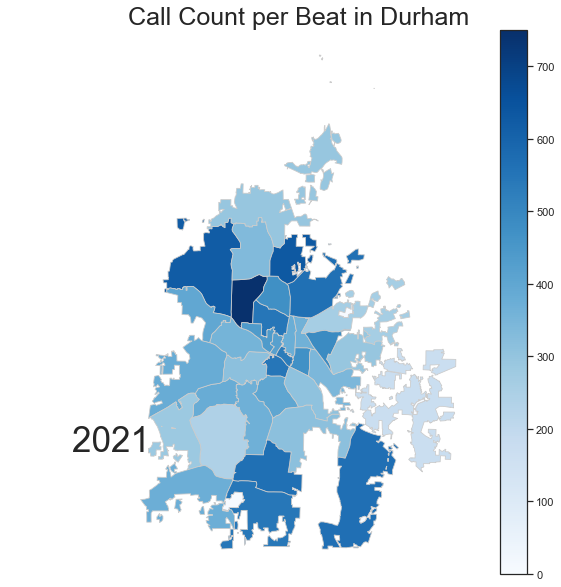

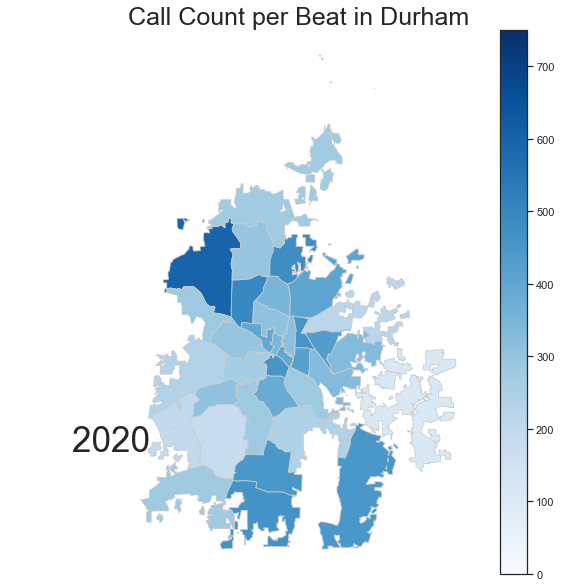

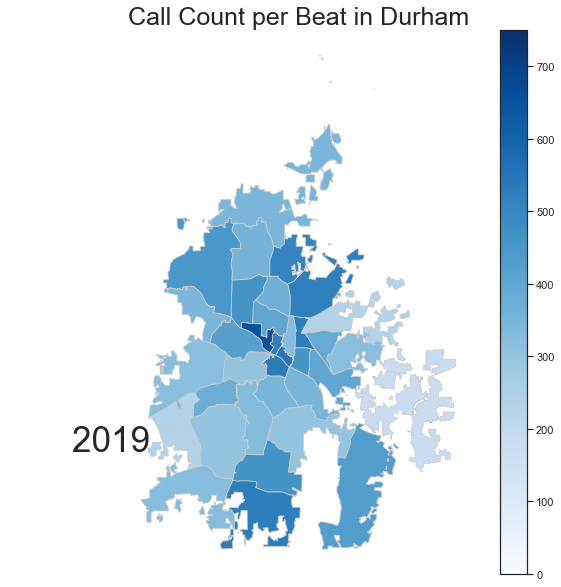

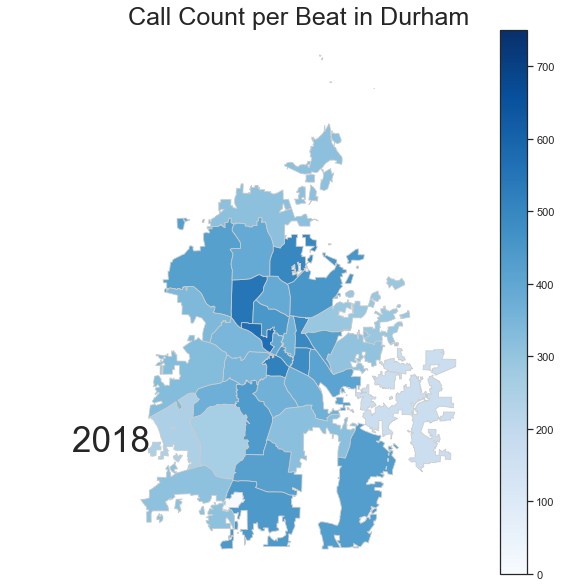

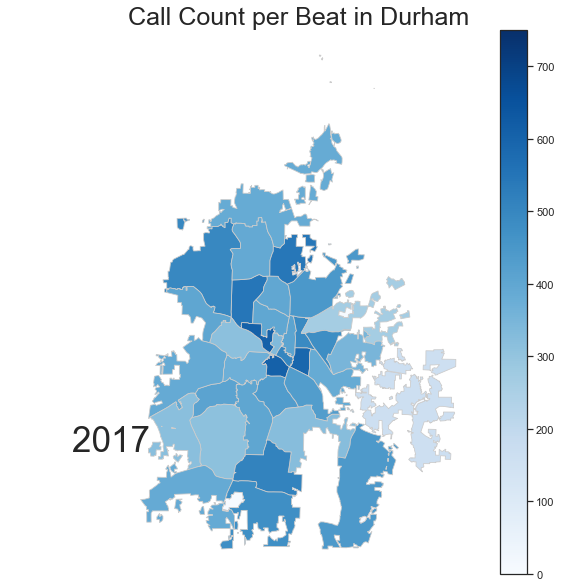

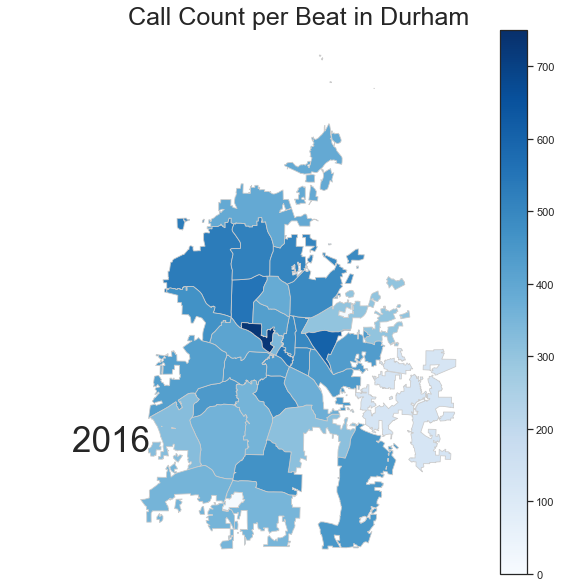

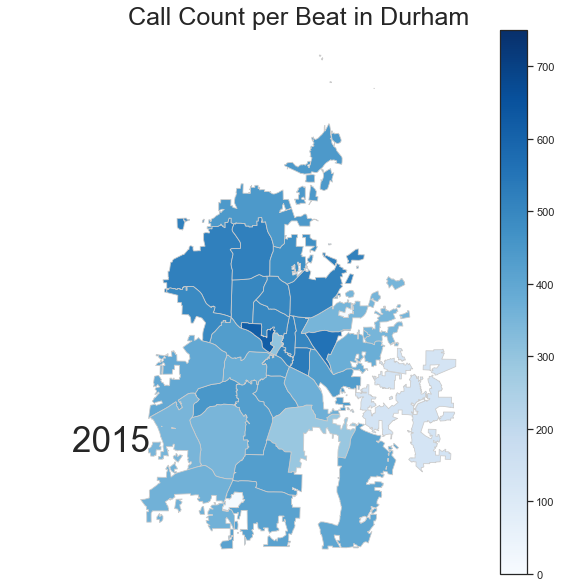

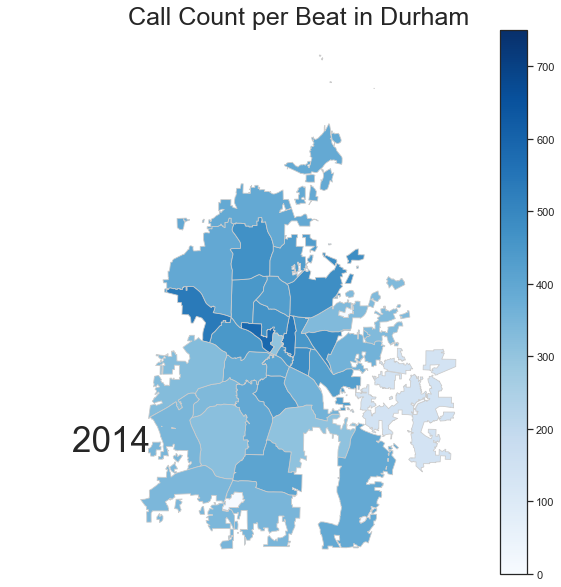

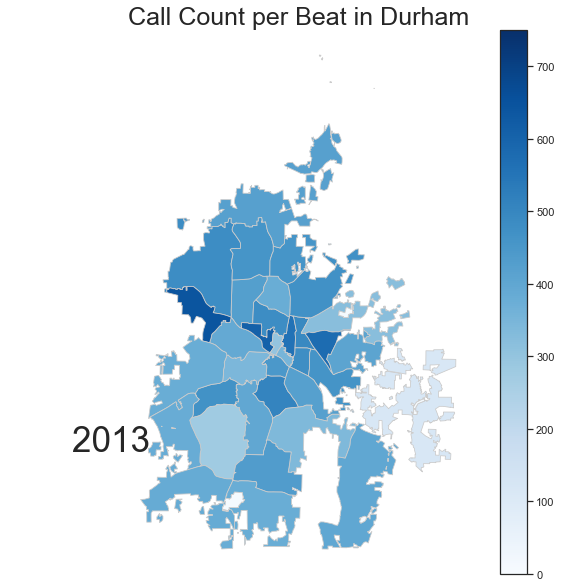

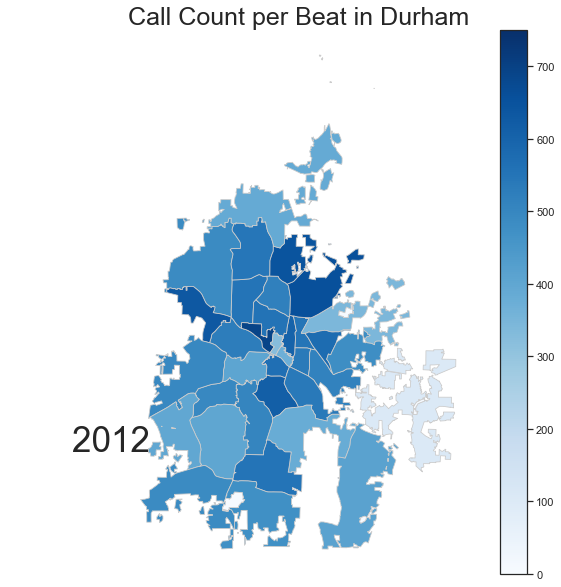

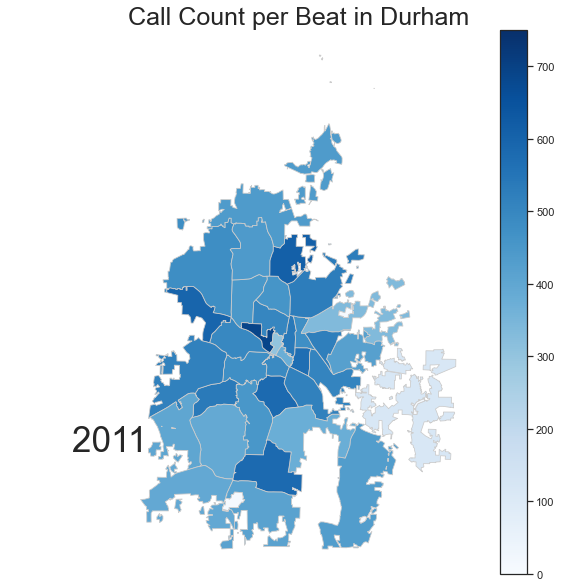

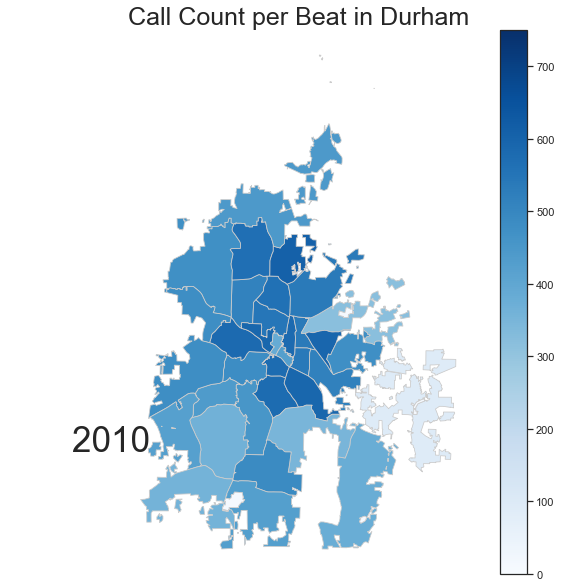

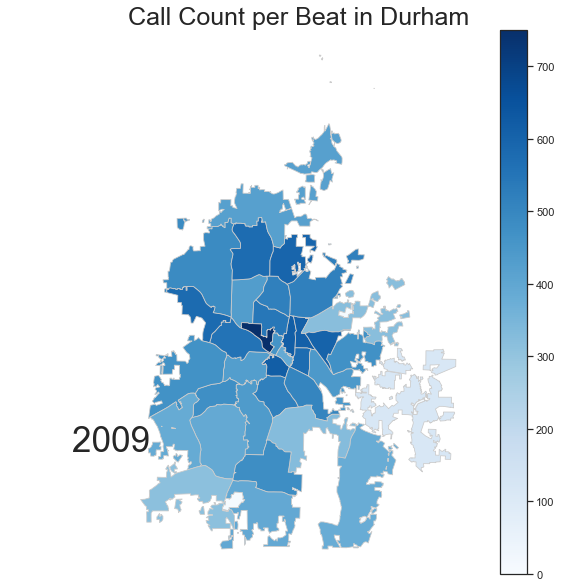

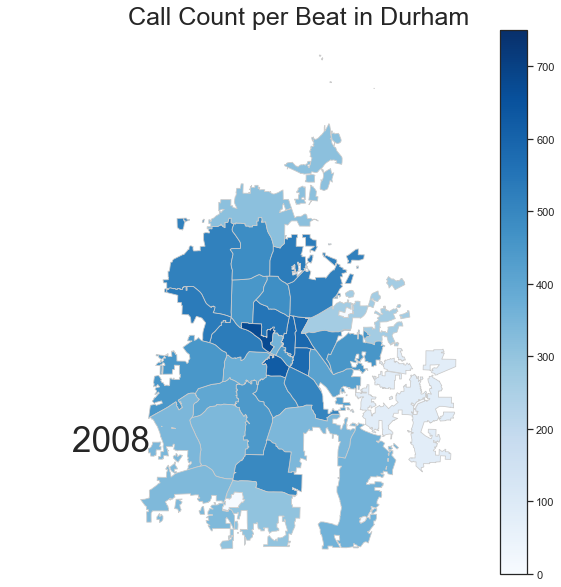

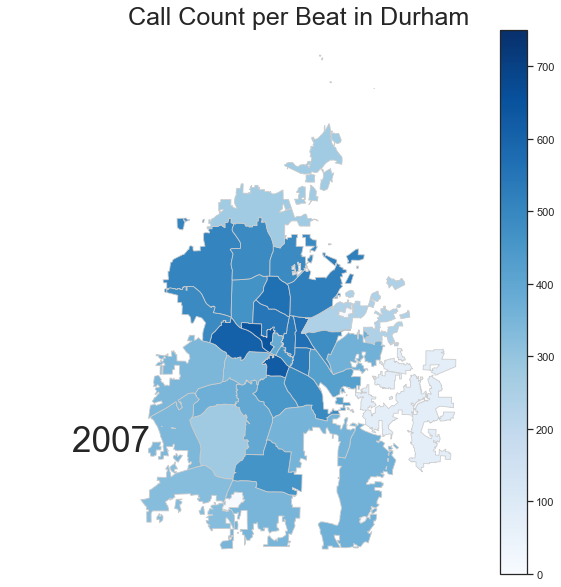

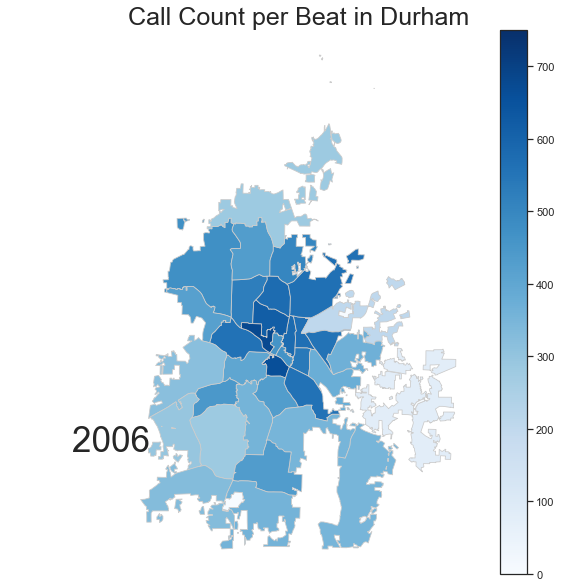

In [646]:
beatsforallyears['coords'] = beatsforallyears['geometry'].apply(lambda x: x.representative_point().coords[:])
beatsforallyears['coords'] = [coords[0] for coords in beatsforallyears['coords']]

# set the min and max range for the choropleth map
vmin, vmax = 0, 750

# start the for loop to create one map per year
for year in list_of_years:
    
    # create map, UDPATE: added plt.Normalize to keep the legend range the same for all maps
    fig = beatsforallyears.plot(column=year, cmap='Blues', figsize=(10,10), linewidth=0.8, edgecolor='0.8', vmin=vmin, vmax=vmax,
legend=True, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    
    # remove axis of chart
    fig.axis('off')
    
    # add a title
    fig.set_title('Call Count per Beat in Durham', \
              fontdict={'fontsize': '25',
                         'fontweight' : '3'})
    
    # create an annotation for the year by grabbing the first 4 digits
    only_year = year[:4]
    # position the annotation to the bottom left
    fig.annotate(only_year,
            xy=(0.1, .225), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=35)
    
    # this will save the figure as a high-res png in the output path. you can also save as svg if you prefer.
    filepath = os.path.join(output_path, only_year+'_violence.jpg')
    chart = fig.get_figure()
    chart.savefig(filepath, dpi=300)    

In [146]:
# save all the maps in the charts folder
output_path = "/Users/erikrobertsson/Documents/dataplus/maps"

# counter for the for loop
i = 0

# list of years (which are the column names at the moment)
list_of_years = ['2021propofallcalls','2020propofallcalls','2019propofallcalls','2018propofallcalls','2017propofallcalls','2016propofallcalls','2015propofallcalls','2014propofallcalls','2013propofallcalls','2012propofallcalls','2011propofallcalls','2010propofallcalls','2009propofallcalls','2008propofallcalls','2007propofallcalls','2006propofallcalls']


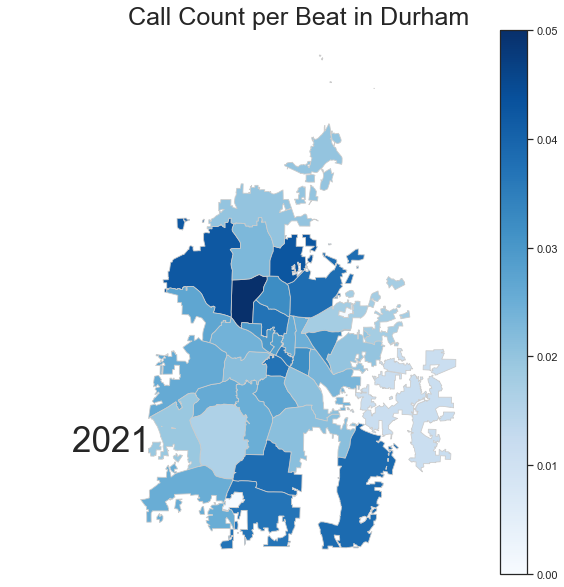

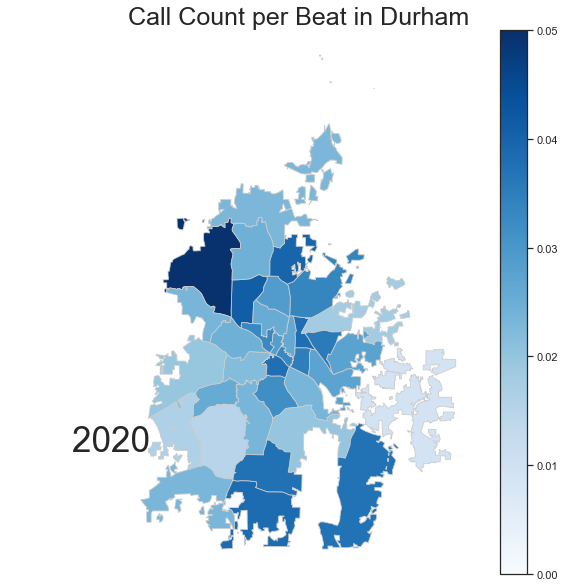

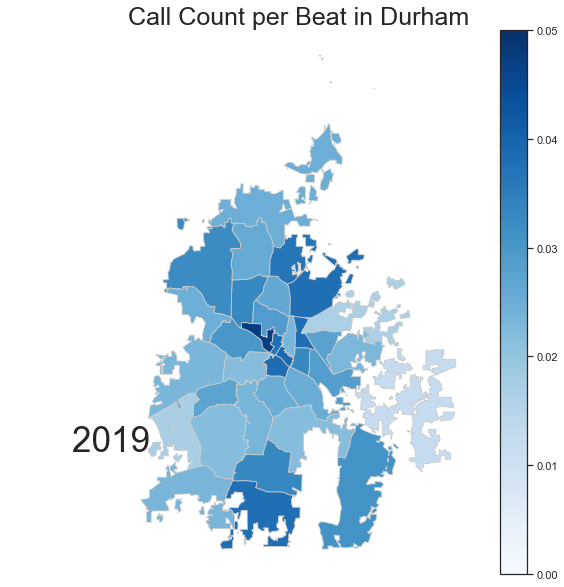

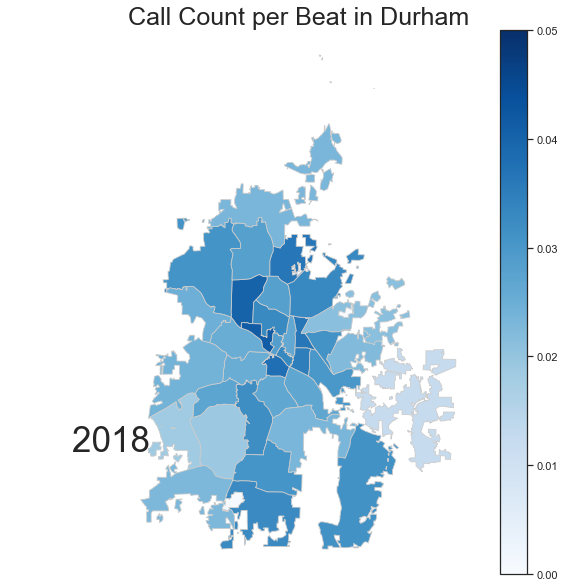

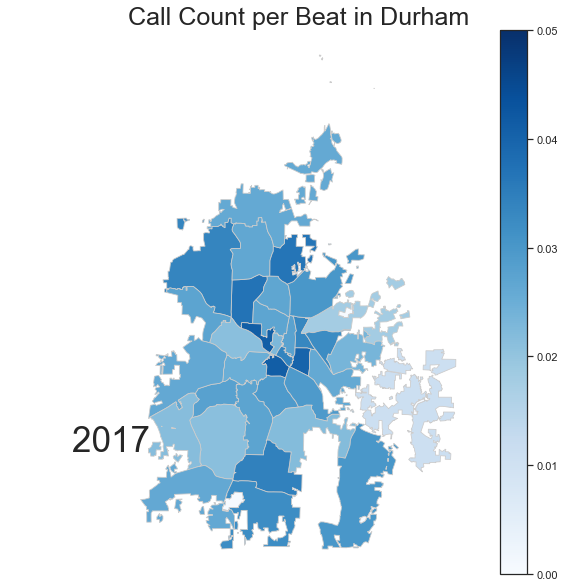

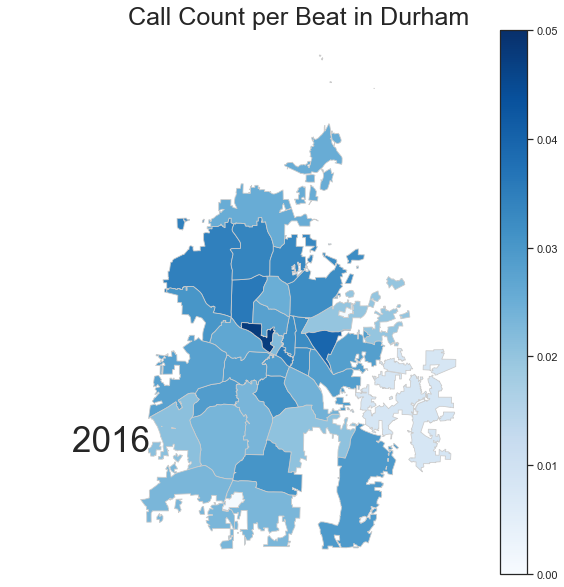

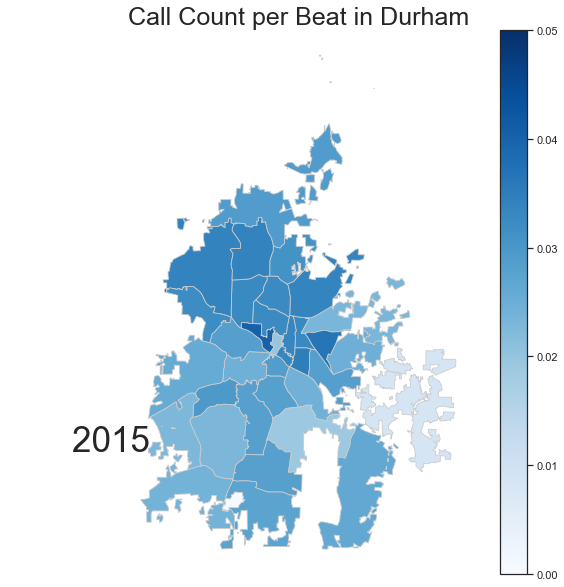

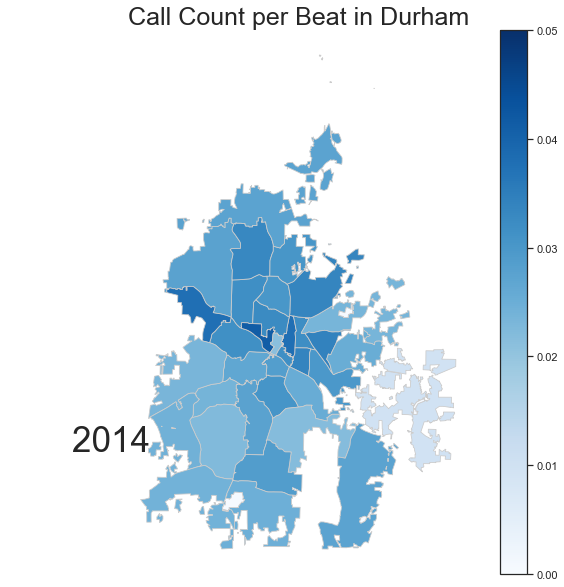

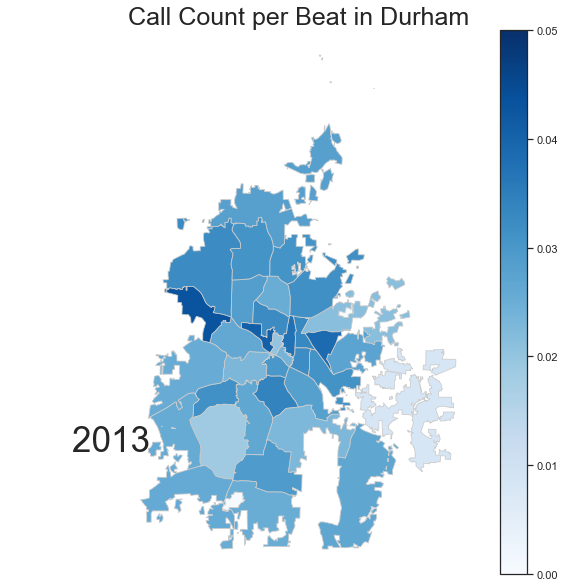

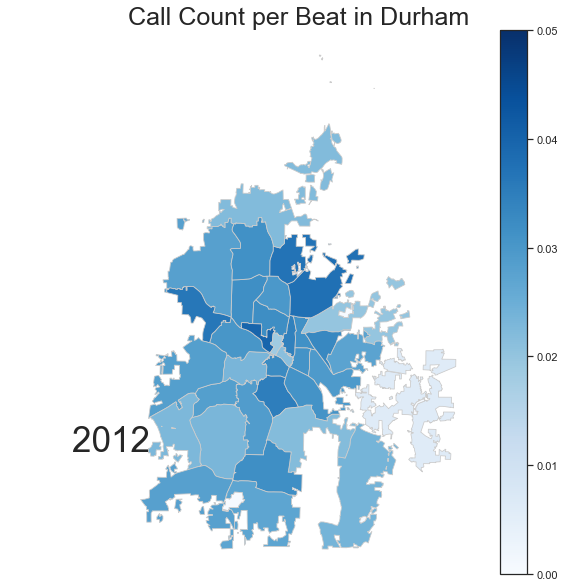

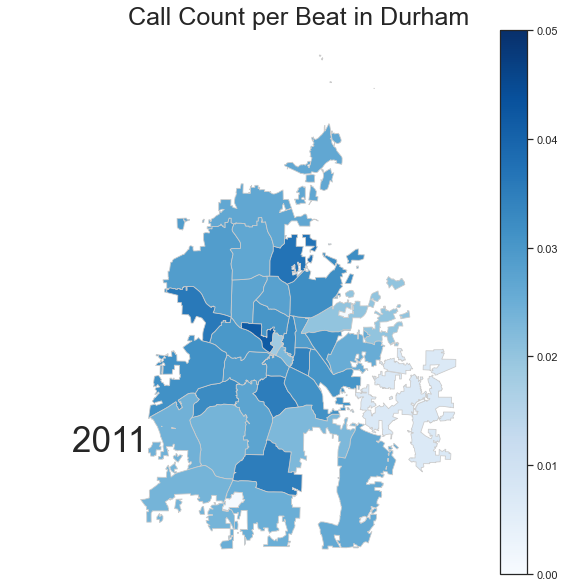

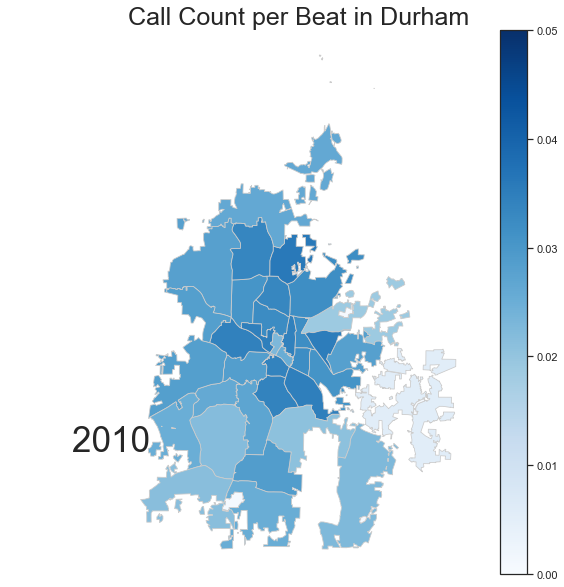

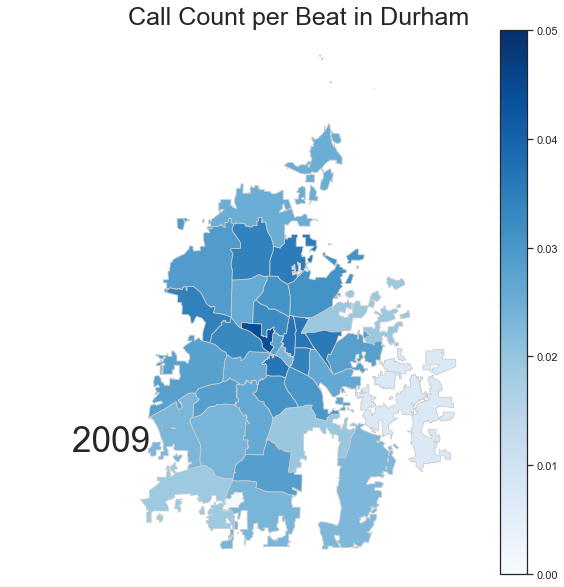

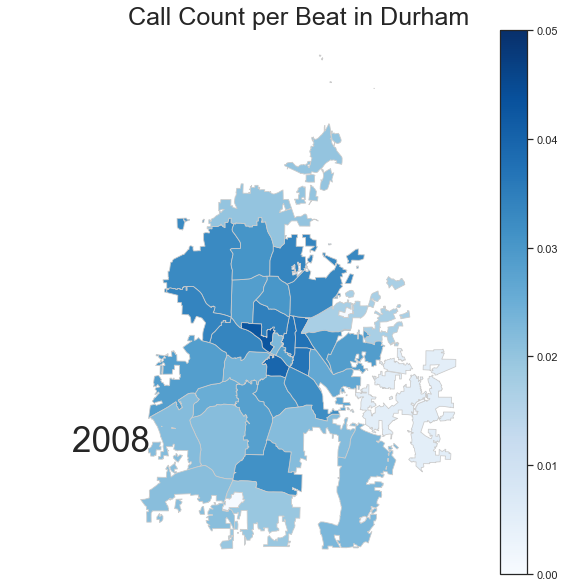

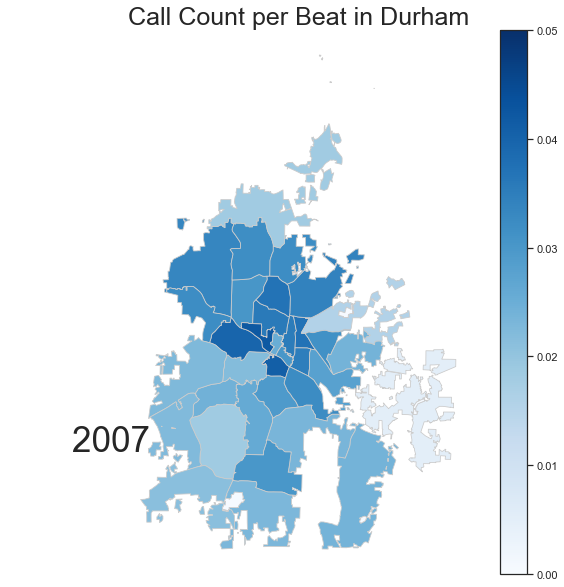

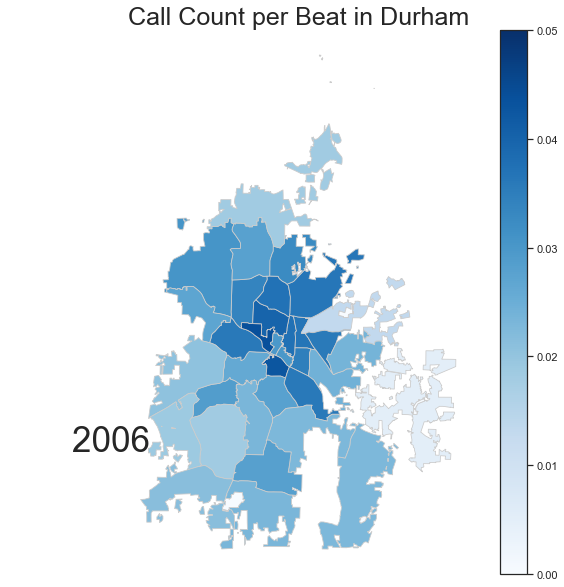

In [147]:
beatsforallyears['coords'] = beatsforallyears['geometry'].apply(lambda x: x.representative_point().coords[:])
beatsforallyears['coords'] = [coords[0] for coords in beatsforallyears['coords']]

# set the min and max range for the choropleth map
vmin, vmax = 0, 0.05

# start the for loop to create one map per year
for year in list_of_years:
    
    # create map, UDPATE: added plt.Normalize to keep the legend range the same for all maps
    fig = beatsforallyears.plot(column=year, cmap='Blues', figsize=(10,10), linewidth=0.8, edgecolor='0.8', vmin=vmin, vmax=vmax,
legend=True, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    
    # remove axis of chart
    fig.axis('off')
    
    # add a title
    fig.set_title('Call Count per Beat in Durham', \
              fontdict={'fontsize': '25',
                         'fontweight' : '3'})
    
    # create an annotation for the year by grabbing the first 4 digits
    only_year = year[:4]
    # position the annotation to the bottom left
    fig.annotate(only_year,
            xy=(0.1, .225), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=35)
    
    # this will save the figure as a high-res png in the output path. you can also save as svg if you prefer.
    filepath = os.path.join(output_path, only_year+'_violence2.jpg')
    chart = fig.get_figure()
    chart.savefig(filepath, dpi=300)    

In [647]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import geopandas as gpd

In [648]:
#read the file stored in variable fp
map_df = policebeats
#check data type so we can see that this is a GEOdataframe
map_df.head()

LAWBEAT                                           geometry  OBJECTID  \
0     111  POLYGON ((-78.89039 36.01517, -78.89038 36.015...        50   
1     112  POLYGON ((-78.88787 36.01473, -78.88734 36.014...        51   
2     113  POLYGON ((-78.87372 35.99369, -78.87458 35.991...        62   
3     114  MULTIPOLYGON (((-78.84053 35.95436, -78.84021 ...        65   
4     121  MULTIPOLYGON (((-78.80746 35.99706, -78.80746 ...        38   

      PERIMETER STATUS CONTIGUOUS LAWDIST  CAD GIS_DataA1    ShapeSTAre  \
0  28608.800781      I        yes      D1  111       None  2.010252e+07   
1  26265.849609      I        yes      D1  112       None  2.079934e+07   
2  20667.539062      I        yes      D1  113       None  2.159195e+07   
3  53321.980469      I        yes      D1  114       None  6.103382e+07   
4  14495.120117      I         no      D1  121       None  7.008533e+06   

     ShapeSTLen  Beat  id  
0  28608.799743   111   0  
1  26265.852604   112   1  
2  20667.538873   113   2  
3  53321.974873   114   3  
4  14495.120026   121   4

In [649]:
df = dpdcalls
df.head()

Event Numb Case Numbe Call Date        time             Source Priority  \
70     21000113       None  1/1/2021  12:41:03AM  Wireless 911 Call        2   
71     21000114       None  1/1/2021  12:41:53AM  Wireless 911 Call        3   
74     21000119       None  1/1/2021  12:44:24AM              E-911        3   
114    21000186       None  1/1/2021   1:19:04AM              E-911        3   
189    21000338       None  1/1/2021   4:26:38AM  Wireless 911 Call        3   

                   Nature            Address        X       Y District Beat  \
70   TRESPASS OR UNWANTED      2300 GUESS RD  2022916  828272       D2  211   
71                 CRISIS         0 HAYTI LN  2030397  813534       D4  411   
74          WELFARE CHECK      500 E MAIN ST  2031074  816191       D5  513   
114  TRESPASS OR UNWANTED  2100 N ROXBORO ST  2032434  825627       D2  213   
189                CRISIS    200 N DRIVER ST  2036165  814339       D1  113   

                  Dispositio  Cancelled                    geometry  
70   Resolved Without Report          0  POINT (-78.92250 36.02572)  
71   Resolved Without Report          0  POINT (-78.89725 35.98522)  
74   Resolved Without Report          0  POINT (-78.89496 35.99252)  
114  Resolved Without Report          0  POINT (-78.89032 36.01843)  
189  Resolved Without Report          0  POINT (-78.87775 35.98741)

In [650]:
#Get district wise installation count
df_district = df['Beat'].value_counts().to_frame()
df_district.reset_index(inplace=True)
df_district.columns = ['Beat','count']
df_district.head()

Beat  count
0  211    756
1  223    626
2  221    619
3  423    575
4  513    565

In [651]:
#Merge the districts df with the geopandas df
merged = map_df.set_index('LAWBEAT').join(df_district.set_index('Beat'))
merged.head()

geometry  OBJECTID  \
LAWBEAT                                                                
111      POLYGON ((-78.89039 36.01517, -78.89038 36.015...        50   
112      POLYGON ((-78.88787 36.01473, -78.88734 36.014...        51   
113      POLYGON ((-78.87372 35.99369, -78.87458 35.991...        62   
114      MULTIPOLYGON (((-78.84053 35.95436, -78.84021 ...        65   
121      MULTIPOLYGON (((-78.80746 35.99706, -78.80746 ...        38   

            PERIMETER STATUS CONTIGUOUS LAWDIST  CAD GIS_DataA1    ShapeSTAre  \
LAWBEAT                                                                         
111      28608.800781      I        yes      D1  111       None  2.010252e+07   
112      26265.849609      I        yes      D1  112       None  2.079934e+07   
113      20667.539062      I        yes      D1  113       None  2.159195e+07   
114      53321.980469      I        yes      D1  114       None  6.103382e+07   
121      14495.120117      I         no      D1  121       None  7.008533e+06   

           ShapeSTLen  Beat  id  count  
LAWBEAT                                 
111      28608.799743   111   0  361.0  
112      26265.852604   112   1  384.0  
113      20667.538873   113   2  439.0  
114      53321.974873   114   3  335.0  
121      14495.120026   121   4  263.0

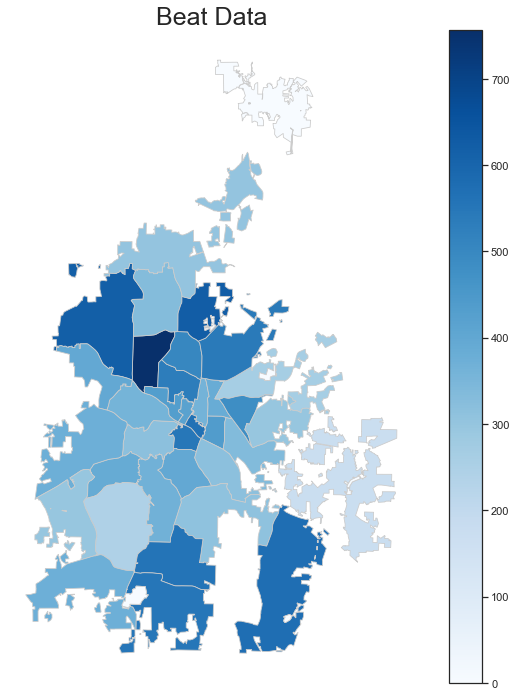

In [658]:
#Fill NA values
merged['count'].fillna(0,inplace=True)
#Get max count
max_installs = merged['count'].max()

#Generate the choropleth map
fig, ax = plt.subplots(1, figsize=(12, 12))
merged.plot(column='count', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')

# remove the axis
ax.axis('off')
# add a title
ax.set_title('Beat Data', fontdict={'fontsize': '25', 'fontweight' : '3'})

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=max_installs))
# add the colorbar to the figure
cbar = fig.colorbar(sm)

beatswithcalls2021['coords'] = beatswithcalls2021['geometry'].apply(lambda x: x.representative_point().coords[:])
beatswithcalls2021['coords'] = [coords[0] for coords in beatswithcalls2021['coords']]

texts =[ax.text(row.coords[0], row.coords[1], s=row["LAWBEAT"], horizontalalignment='center') for idx, row in beatswithcalls2021.iterrows()]

In [660]:
blocks_w_dpd = gpd.sjoin(cblockcommsafebeats, dpdcalls)
callssummedinblocks = blocks_w_dpd.groupby(['NAME20']).size().to_frame(name = 'calls_count').reset_index()
callssummedinblocks

NAME20  calls_count
0    Block 1000          284
1    Block 1001           36
2    Block 1002           55
3    Block 1003          207
4    Block 1004           91
..          ...          ...
163  Block 7032            2
164  Block 7035            1
165  Block 7036            3
166  Block 7042            1
167  Block 7043            3

[168 rows x 2 columns]

In [661]:
blocks_calls_w_callcount = pd.merge(blocks_w_dpd, callssummedinblocks, left_on ='NAME20', right_on='NAME20')
blocks_calls_w_callcount = blocks_calls_w_callcount.groupby('NAME20', as_index=False).mean()
blocks_calls_w_callcount.sort_values(by='calls_count', inplace=True, ascending=False)
blocks_calls_w_callcount

NAME20        ALAND20  AWATER20   Beat_left    index_right  \
0    Block 1000  591435.112676       0.0  226.401408  146000.408451   
6    Block 1006  133090.661905       0.0  175.504762  164062.628571   
3    Block 1003   28054.830918       0.0  218.864734  138539.265700   
10   Block 1010   20970.720000       0.0  468.840000  127989.270000   
157  Block 7000  479174.000000       0.0  223.000000  152203.673469   
..          ...            ...       ...         ...            ...   
74   Block 2028   12621.000000       0.0  512.000000  106049.000000   
147  Block 6017   10967.000000       0.0  223.000000  184343.000000   
132  Block 5003   15548.000000       0.0  223.000000   20797.000000   
135  Block 5008   39778.000000       0.0  223.000000  238215.000000   
145  Block 6012  183443.000000       0.0  223.000000  201107.000000   

       Event Numb             X              Y  Cancelled  calls_count  
0    2.124294e+07  2.032623e+06  824531.105634        0.0        284.0  
6    2.127483e+07  2.033640e+06  819638.242857        0.0        210.0  
3    2.123070e+07  2.032088e+06  814787.608696        0.0        207.0  
10   2.121227e+07  2.031450e+06  815850.250000        0.0        100.0  
157  2.125393e+07  2.031490e+06  833218.551020        0.0         98.0  
..            ...           ...            ...        ...          ...  
74   2.117067e+07  2.029128e+06  818835.000000        0.0          1.0  
147  2.130621e+07  2.034647e+06  833882.000000        0.0          1.0  
132  2.103315e+07  2.032037e+06  836417.000000        0.0          1.0  
135  2.140485e+07  2.030243e+06  834264.000000        0.0          1.0  
145  2.133720e+07  2.033071e+06  835537.000000        0.0          1.0  

[168 rows x 10 columns]

In [662]:
mappingdatasetforblocks_w_calls = pd.merge(cblockcommsafebeats, blocks_calls_w_callcount, on ='NAME20')
mappingdatasetforblocks_w_calls = mappingdatasetforblocks_w_calls.to_crs("4326")
mappingdatasetforblocks_w_calls = mappingdatasetforblocks_w_calls.dissolve(by="NAME20")
mappingdatasetforblocks_w_calls['area'] = mappingdatasetforblocks_w_calls.area
mappingdatasetforblocks_w_calls['callsperarea'] = mappingdatasetforblocks_w_calls['calls_count'] / mappingdatasetforblocks_w_calls['area']
mappingdatasetforblocks_w_calls.sort_values(by='calls_count', inplace=True, ascending=False)
#block_list = ['1002', '2000', '1000', '1006', '7000']
#mappingdatasetforblocks_w_calls = mappingdatasetforblocks_w_calls.loc[mappingdatasetforblocks_w_calls['BLOCKCE20'].isin(block_list)].copy()
#mappingdatasetforblocks_w_calls.to_file("/Users/erikrobertsson/Documents/dataplus/blockdataforcommsafebeats.shp")
mappingdatasetforblocks_w_calls

geometry STATEFP20  \
NAME20                                                                    
Block 1000  MULTIPOLYGON (((-78.90063 35.97796, -78.90043 ...        37   
Block 1006  MULTIPOLYGON (((-78.89615 35.97974, -78.89644 ...        37   
Block 1003  MULTIPOLYGON (((-78.89879 35.98284, -78.89871 ...        37   
Block 1010  MULTIPOLYGON (((-78.89243 35.97789, -78.89404 ...        37   
Block 7000  POLYGON ((-78.89929 36.04016, -78.89916 36.040...        37   
...                                                       ...       ...   
Block 2028  MULTIPOLYGON (((-78.87884 35.97983, -78.87797 ...        37   
Block 6017  MULTIPOLYGON (((-78.88178 36.04225, -78.88178 ...        37   
Block 5003  POLYGON ((-78.89199 36.04855, -78.89185 36.048...        37   
Block 5008  POLYGON ((-78.89929 36.04322, -78.89906 36.043...        37   
Block 6012  MULTIPOLYGON (((-78.83773 36.04539, -78.83737 ...        37   

           COUNTYFP20 TRACTCE20 BLOCKCE20          GEOID20 MTFCC20 UR20  \
NAME20                                                                    
Block 1000        063    000101      1000  370630001011000   G5040    R   
Block 1006        063    001301      1006  370630013011006   G5040    R   
Block 1003        063    001100      1003  370630011001003   G5040    R   
Block 1010        063    001709      1010  370630017091010   G5040    R   
Block 7000        063    001709      7000  370630017097000   G5040    R   
...               ...       ...       ...              ...     ...  ...   
Block 2028        063    001001      2028  370630010012028   G5040    R   
Block 6017        063    001801      6017  370630018016017   G5040    R   
Block 5003        063    001709      5003  370630017095003   G5040    R   
Block 5008        063    001709      5008  370630017095008   G5040    R   
Block 6012        063    001709      6012  370630017096012   G5040    R   

           UACE20 UATYPE20 FUNCSTAT20  ALAND20_x  AWATER20_x   INTPTLAT20  \
NAME20                                                                      
Block 1000   None     None          S     655575           0  +36.0194814   
Block 1006   None     None          S       9723           0  +35.9802719   
Block 1003   None     None          S      16549           0  +35.9876120   
Block 1010   None     None          S      75173           0  +36.0357036   
Block 7000   None     None          S     479174           0  +36.0390725   
...           ...      ...        ...        ...         ...          ...   
Block 2028   None     None          S       5039           0  +35.9792907   
Block 6017   None     None          S      13779        2737  +36.0497272   
Block 5003   None     None          S      15548           0  +36.0481907   
Block 5008   None     None          S      39778           0  +36.0421224   
Block 6012   None     None          S     183443           0  +36.0501448   

              INTPTLON20  Beat      ALAND20_y  AWATER20_y   Beat_left  \
NAME20                                                                  
Block 1000  -078.8821382   214  591435.112676         0.0  226.401408   
Block 1006  -078.8965798   411  133090.661905         0.0  175.504762   
Block 1003  -078.8870162   113   28054.830918         0.0  218.864734   
Block 1010  -078.8733440   214   20970.720000         0.0  468.840000   
Block 7000  -078.8935405   223  479174.000000         0.0  223.000000   
...                  ...   ...            ...         ...         ...   
Block 2028  -078.8777887   113   12621.000000         0.0  512.000000   
Block 6017  -078.8536272   214   10967.000000         0.0  223.000000   
Block 5003  -078.8909954   223   15548.000000         0.0  223.000000   
Block 5008  -078.8979995   223   39778.000000         0.0  223.000000   
Block 6012  -078.8756916   223  183443.000000         0.0  223.000000   

              index_right    Event Numb             X              Y  \
NAME20                                                                 
Block

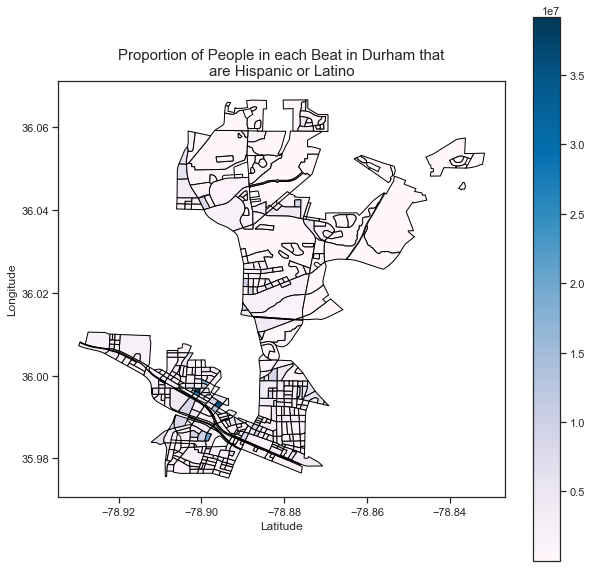

In [663]:
#Plot chloropleth map with merged data
fig, ax = plt.subplots(figsize = (10,10))
mappingdatasetforblocks_w_calls.plot(column='callsperarea',
                                legend=True,
                                cmap="PuBu", ax=ax, aspect=1, edgecolor = 'black');

# ax.set(title='Number of Calls by Police Beat')
plt.title("Proportion of People in each Beat in Durham that\nare Hispanic or Latino", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [664]:
policebeats_w_dpd = gpd.sjoin(policebeats, dpdcalls)
callssummedinbeats = policebeats_w_dpd.groupby(['LAWBEAT']).size().to_frame(name = 'calls_count').reset_index()
callssummedinbeats

LAWBEAT  calls_count
0      111          376
1      112          365
2      113          470
3      114          343
4      121          261
..     ...          ...
31     423          568
32     511          437
33     512          420
34     513          533
35     999            5

[36 rows x 2 columns]

In [669]:
policebeats_calls_w_callcount = pd.merge(policebeats_w_dpd, callssummedinbeats, left_on ='LAWBEAT', right_on='LAWBEAT')
policebeats_calls_w_callcount['area'] = policebeats_calls_w_callcount.area
policebeats_calls_w_callcount = policebeats_calls_w_callcount.groupby('LAWBEAT', as_index=False).mean()
policebeats_calls_w_callcount

LAWBEAT  OBJECTID      PERIMETER    ShapeSTAre     ShapeSTLen  Beat_left  \
0      111      50.0   28608.800781  2.010252e+07   28608.799743      111.0   
1      112      51.0   26265.849609  2.079934e+07   26265.852604      112.0   
2      113      62.0   20667.539062  2.159195e+07   20667.538873      113.0   
3      114      65.0   53321.980469  6.103382e+07   53321.974873      114.0   
4      121      38.0   14495.120117  7.008533e+06   14495.120026      121.0   
..     ...       ...            ...           ...            ...        ...   
31     423      95.0  151917.093750  2.561465e+08  151917.121852      423.0   
32     511      53.0   32615.019531  2.129644e+07   32615.017763      511.0   
33     512      57.0   16338.889648  9.305014e+06   16338.888321      512.0   
34     513      61.0   20647.179688  9.114313e+06   20647.175971      513.0   
35     999       4.0    1308.963013  6.932677e+04    1308.962953      999.0   

      id    index_right    Event Numb             X              Y  Cancelled  \
0    0.0  138122.938830  2.122898e+07  2.032588e+06  817220.396277        0.0   
1    1.0  158277.419178  2.126486e+07  2.035117e+06  818966.142466        0.0   
2    2.0  136544.927660  2.122672e+07  2.034771e+06  814367.727660        0.0   
3    3.0  136054.364431  2.122669e+07  2.039702e+06  812959.107872        0.0   
4    4.0  144309.904215  2.124058e+07  2.044614e+06  823994.272031        0.0   
..   ...            ...           ...           ...            ...        ...   
31  32.0  149586.792254  2.124912e+07  2.048046e+06  782717.906690        0.0   
32  33.0  137519.151030  2.122905e+07  2.025700e+06  819510.860412        0.0   
33  34.0  148823.707143  2.124809e+07  2.029196e+06  817701.585714        0.0   
34  35.0  141478.864916  2.123570e+07  2.031472e+06  815243.120075        0.0   
35  36.0   88250.200000  2.114509e+07  2.036873e+06  822897.000000        0.0   

    calls_count      area  
0         376.0  0.000187  
1         365.0  0.000193  
2         470.0  0.000200  
3         343.0  0.000616  
4         261.0  0.001061  
..          ...       ...  
31        568.0  0.002382  
32        437.0  0.000198  
33        420.0  0.000086  
34        533.0  0.000085  
35          5.0  0.000248  

[36 rows x 14 columns]

In [673]:
policebeats['LAWBEAT'] = policebeats['LAWBEAT'].astype(int)

In [674]:
beats_callcount_popdata = pd.merge(policebeats_calls_w_callcount, popsumbybeat, left_on ='LAWBEAT', right_on='Beat')
beats_callcount_popdata['popdensity']= beats_callcount_popdata['total'] / beats_callcount_popdata['area']
beats_callcount_popdata['callcountperperson']= beats_callcount_popdata['calls_count'] / beats_callcount_popdata['total']
beats_callcount_popdata['prophisp']= beats_callcount_popdata['total_hispanic_or_latino'] / beats_callcount_popdata['total']
beats_callcount_popdata

LAWBEAT  OBJECTID      PERIMETER    ShapeSTAre     ShapeSTLen  Beat_left  \
0       111      50.0   28608.800781  2.010252e+07   28608.799743      111.0   
1       112      51.0   26265.849609  2.079934e+07   26265.852604      112.0   
2       113      62.0   20667.539062  2.159195e+07   20667.538873      113.0   
3       114      65.0   53321.980469  6.103382e+07   53321.974873      114.0   
4       121      38.0   14495.120117  7.008533e+06   14495.120026      121.0   
..      ...       ...            ...           ...            ...        ...   
31      423      95.0  151917.093750  2.561465e+08  151917.121852      423.0   
32      511      53.0   32615.019531  2.129644e+07   32615.017763      511.0   
33      512      57.0   16338.889648  9.305014e+06   16338.888321      512.0   
34      513      61.0   20647.179688  9.114313e+06   20647.175971      513.0   
35      999       4.0    1308.963013  6.932677e+04    1308.962953      999.0   

      id    index_right    Event Numb             X              Y  Cancelled  \
0    0.0  138122.938830  2.122898e+07  2.032588e+06  817220.396277        0.0   
1    1.0  158277.419178  2.126486e+07  2.035117e+06  818966.142466        0.0   
2    2.0  136544.927660  2.122672e+07  2.034771e+06  814367.727660        0.0   
3    3.0  136054.364431  2.122669e+07  2.039702e+06  812959.107872        0.0   
4    4.0  144309.904215  2.124058e+07  2.044614e+06  823994.272031        0.0   
..   ...            ...           ...           ...            ...        ...   
31  32.0  149586.792254  2.124912e+07  2.048046e+06  782717.906690        0.0   
32  33.0  137519.151030  2.122905e+07  2.025700e+06  819510.860412        0.0   
33  34.0  148823.707143  2.124809e+07  2.029196e+06  817701.585714        0.0   
34  35.0  141478.864916  2.123570e+07  2.031472e+06  815243.120075        0.0   
35  36.0   88250.200000  2.114509e+07  2.036873e+06  822897.000000        0.0   

    calls_count      area  Beat   ALAND20  AWATER20  total  \
0         376.0  0.000187   111   1885019         0   3949   
1         365.0  0.000193   112   1863048         0   3083   
2         470.0  0.000200   113   2056983      1025   4094   
3         343.0  0.000616   114   5975063     40919   5631   
4         261.0  0.001061   121  12440369    123268   8025   
..          ...       ...   ...       ...       ...    ...   
31        568.0  0.002382   423  25160283    240192  15092   
32        437.0  0.000198   511   2044774         0   5505   
33        420.0  0.000086   512    882799         0   1646   
34        533.0  0.000085   513    797193         0   1677   
35          5.0  0.000248   999   2187405     14257    194   

    total_hispanic_or_latino  total_not_hispanic_or_latino    popdensity  \
0                       1130                          2819  2.115229e+07   
1                       1366                          1717  1.595999e+07   
2                       1038                          3056  2.041984e+07   
3                       1756                          3875  9.142323e+06   
4                       1803                          6222  7.560240e+06   
..                       ...                           ...           ...   
31                      1231                         13861  6.336461e+06   
32                       385                          5120  2.783313e+07   
33                       119                          1527  1.904815e+07   
34                       180                          1497  1.981489e+07   
35                        43                           151  7.809575e+05   

    callcountperperson  prophisp  
0             0.095214  0.286148  
1             0.118391  0.443075  
2             0.114802  0.253542  
3             0.060913  0.311845  
4             0.032523  0.224673  
..                 ...       ...  
31            0.037636  0.081566  
32            0.079382  0.069936  
33            0.255164  0.072296  
34            0.317829  0.107335  
35            0.025773  0.2

In [675]:
column_1 = beats_callcount_popdata["popdensity"]
column_2 = beats_callcount_popdata["callcountperperson"]
correlation = column_1.corr(column_2)
correlation

0.4897603461609283

In [676]:
#create a dataset for mapping
mappingdatasetforpolicebeats = pd.merge(policebeats, beats_callcount_popdata, on ='LAWBEAT')
mappingdatasetforpolicebeats

LAWBEAT                                           geometry  OBJECTID_x  \
0       111  POLYGON ((-78.89039 36.01517, -78.89038 36.015...          50   
1       112  POLYGON ((-78.88787 36.01473, -78.88734 36.014...          51   
2       113  POLYGON ((-78.87372 35.99369, -78.87458 35.991...          62   
3       114  MULTIPOLYGON (((-78.84053 35.95436, -78.84021 ...          65   
4       121  MULTIPOLYGON (((-78.80746 35.99706, -78.80746 ...          38   
..      ...                                                ...         ...   
31      423  MULTIPOLYGON (((-78.83466 35.94599, -78.83463 ...          95   
32      511  POLYGON ((-78.92318 36.01031, -78.92260 36.010...          53   
33      512  POLYGON ((-78.90313 36.00376, -78.90298 36.003...          57   
34      513  POLYGON ((-78.89561 35.99710, -78.89553 35.997...          61   
35      999  MULTIPOLYGON (((-78.94297 35.89150, -78.94296 ...           4   

      PERIMETER_x STATUS CONTIGUOUS LAWDIST  CAD GIS_DataA1  ShapeSTAre_x  \
0    28608.800781      I        yes      D1  111       None  2.010252e+07   
1    26265.849609      I        yes      D1  112       None  2.079934e+07   
2    20667.539062      I        yes      D1  113       None  2.159195e+07   
3    53321.980469      I        yes      D1  114       None  6.103382e+07   
4    14495.120117      I         no      D1  121       None  7.008533e+06   
..            ...    ...        ...     ...  ...        ...           ...   
31  151917.093750      I        yes      D4  423       None  2.561465e+08   
32   32615.019531      I        yes      D5  511       None  2.129644e+07   
33   16338.889648      I        yes      D5  512       None  9.305014e+06   
34   20647.179688      I        yes      D5  513       None  9.114313e+06   
35    1308.963013   None       None     DSO  DSO       None  6.932677e+04   

     ShapeSTLen_x  Beat_x  id_x  OBJECTID_y    PERIMETER_y  ShapeSTAre_y  \
0    28608.799743     111     0        50.0   28608.800781  2.010252e+07   
1    26265.852604     112     1        51.0   26265.849609  2.079934e+07   
2    20667.538873     113     2        62.0   20667.539062  2.159195e+07   
3    53321.974873     114     3        65.0   53321.980469  6.103382e+07   
4    14495.120026     121     4        38.0   14495.120117  7.008533e+06   
..            ...     ...   ...         ...            ...           ...   
31  151917.121852     423    32        95.0  151917.093750  2.561465e+08   
32   32615.017763     511    33        53.0   32615.019531  2.129644e+07   
33   16338.888321     512    34        57.0   16338.889648  9.305014e+06   
34   20647.175971     513    35        61.0   20647.179688  9.114313e+06   
35    1308.962953     999    36         4.0    1308.963013  6.932677e+04   

     ShapeSTLen_y  Beat_left  id_y    index_right    Event Numb             X  \
0    28608.799743      111.0   0.0  138122.938830  2.122898e+07  2.032588e+06   
1    26265.852604      112.0   1.0  158277.419178  2.126486e+07  2.035117e+06   
2    20667.538873      113.0   2.0  136544.927660  2.122672e+07  2.034771e+06   
3    53321.974873      114.0   3.0  136054.364431  2.122669e+07  2.039702e+06   
4    14495.120026      121.0   4.0  144309.904215  2.124058e+07  2.044614e+06   
..            ...        ...   ...            ...           ...           ...   
31  151917.121852      423.0  32.0  149586.792254  2.124912e+07  2.048046e+06   
32   32615.017763      511.0  33.0  137519.151030  2.122905e+07  2.025700e+06   
33   16338.888321      512.0  34.0  148823.707143  2.124809e+07  2.029196e+06   
34   20647.175971      513.0  35.0  141478.864916  2.123570e+07  2.031472e+06   
35    1308.962953      999.0  36.0   88250.200000  2.114509e+07  2.036873e+06   

                Y  Cancelled  calls_count      area  Beat_y   ALAND20  \
0   817220.396277        0.0        376.0  0.000187     111   1885019   
1   818966.142466        0.0        365.0  0.000193     112   1863048   
2   814367.727660        0.0        4

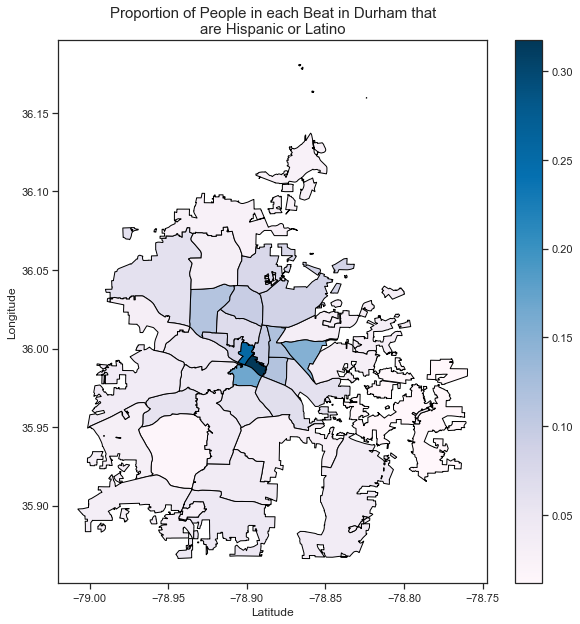

In [677]:
#Plot chloropleth map with merged data
fig, ax = plt.subplots(figsize = (10,10))
mappingdatasetforpolicebeats.plot(column='callcountperperson',
                                legend=True,
                                cmap="PuBu", ax=ax, aspect=1, edgecolor = 'black');

# ax.set(title='Number of Calls by Police Beat')
plt.title("Proportion of People in each Beat in Durham that\nare Hispanic or Latino", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

end of checking how callcountperperson correlates with a beats popdensity

In [678]:
#putting race data into the police beat and block data
beatswithhispanics = gpd.sjoin(cblockDurhamBeats, durhamhispanicmap)
popsumbybeat = beatswithhispanics.groupby('Beat', as_index=False).sum()
hispanicsineachbeat = pd.merge(popsumbybeat, policebeats, left_on='Beat', right_on='LAWBEAT')
hispanicsineachbeat = hispanicsineachbeat.to_crs("EPSG:4326")
hispanicsineachbeat['prophispanic']= hispanicsineachbeat['total_hispanic_or_latino'] / hispanicsineachbeat['total']
hispanicsineachbeat

Beat_x    ALAND20  AWATER20   total  total_hispanic_or_latino  \
0      111   17579442         0   32720                      8601   
1      112   17718915         0   27224                     12345   
2      113   20482283     13325   35128                      9451   
3      114   56673958    441791   53897                     17371   
4      121  154087358   1453287   66559                     16154   
..     ...        ...       ...     ...                       ...   
32     423  295488212   3422861  146011                     10933   
33     511   29227231         0   44560                      3245   
34     512    7656325         0   15694                      1336   
35     513    7140807         0   18901                      2016   
36     999   15400563    125985    9616                       715   

    total_not_hispanic_or_latino  LAWBEAT  \
0                          24119      111   
1                          14879      112   
2                          25677      113   
3                          36526      114   
4                          50405      121   
..                           ...      ...   
32                        135078      423   
33                         41315      511   
34                         14358      512   
35                         16885      513   
36                          8901      999   

                                             geometry  OBJECTID  \
0   POLYGON ((-78.89039 36.01517, -78.89038 36.015...        50   
1   POLYGON ((-78.88787 36.01473, -78.88734 36.014...        51   
2   POLYGON ((-78.87372 35.99369, -78.87458 35.991...        62   
3   MULTIPOLYGON (((-78.84053 35.95436, -78.84021 ...        65   
4   MULTIPOLYGON (((-78.80746 35.99706, -78.80746 ...        38   
..                                                ...       ...   
32  MULTIPOLYGON (((-78.83466 35.94599, -78.83463 ...        95   
33  POLYGON ((-78.92318 36.01031, -78.92260 36.010...        53   
34  POLYGON ((-78.90313 36.00376, -78.90298 36.003...        57   
35  POLYGON ((-78.89561 35.99710, -78.89553 35.997...        61   
36  MULTIPOLYGON (((-78.94297 35.89150, -78.94296 ...         4   

        PERIMETER STATUS CONTIGUOUS LAWDIST  CAD GIS_DataA1    ShapeSTAre  \
0    28608.800781      I        yes      D1  111       None  2.010252e+07   
1    26265.849609      I        yes      D1  112       None  2.079934e+07   
2    20667.539062      I        yes      D1  113       None  2.159195e+07   
3    53321.980469      I        yes      D1  114       None  6.103382e+07   
4    14495.120117      I         no      D1  121       None  7.008533e+06   
..            ...    ...        ...     ...  ...        ...           ...   
32  151917.093750      I        yes      D4  423       None  2.561465e+08   
33   32615.019531      I        yes      D5  511       None  2.129644e+07   
34   16338.889648      I        yes      D5  512       None  9.305014e+06   
35   20647.179688      I        yes      D5  513       None  9.114313e+06   
36    1308.963013   None       None     DSO  DSO       None  6.932677e+04   

       ShapeSTLen  Beat_y  id  prophispanic  
0    28608.799743     111   0      0.262867  
1    26265.852604     112   1      0.453460  
2    20667.538873     113   2      0.269045  
3    53321.974873     114   3      0.322300  
4    14495.120026     121   4      0.242702  
..            ...     ...  ..           ...  
32  151917.121852     423  32      0.074878  
33   32615.017763     511  33      0.072823  
34   16338.888321     512  34      0.085128  
35   20647.175971     513  35      0.106661  
36    1308.962953     999  36      0.074355  

[37 rows x 20 columns]

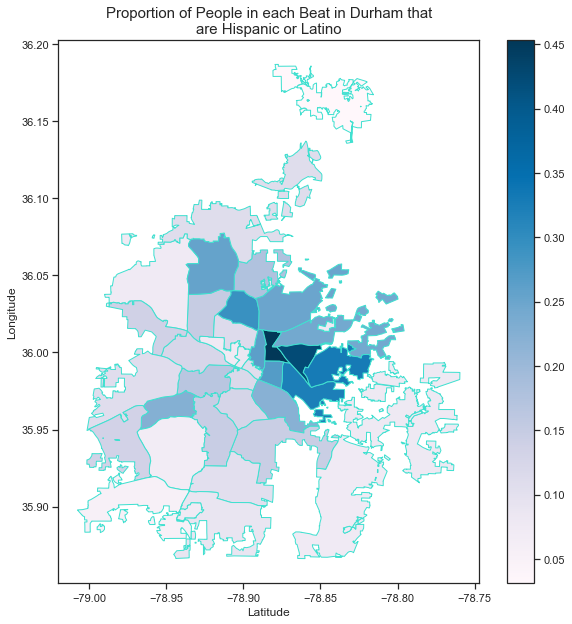

In [679]:
#Plot chloropleth map with merged data
fig, ax = plt.subplots(figsize = (10,10))
hispanicsineachbeat.plot(column='prophispanic',
                                legend=True,
                                cmap="PuBu", ax=ax, aspect=1, edgecolor = 'turquoise');

# ax.set(title='Number of Calls by Police Beat')
plt.title("Proportion of People in each Beat in Durham that\nare Hispanic or Latino", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [680]:
commsafebeatswithhispanics = gpd.sjoin(cblockcommsafebeats, durhamhispanicmap)
commsafepopsumbybeat = commsafebeatswithhispanics.groupby('Beat', as_index=False).sum()
commsafehispanicsineachbeat = pd.merge(commsafepopsumbybeat, policebeats, left_on='Beat', right_on='LAWBEAT')
commsafehispanicsineachbeat = commsafehispanicsineachbeat.to_crs("EPSG:4326")
commsafehispanicsineachbeat['prophispanic']= commsafehispanicsineachbeat['total_hispanic_or_latino'] / commsafehispanicsineachbeat['total']

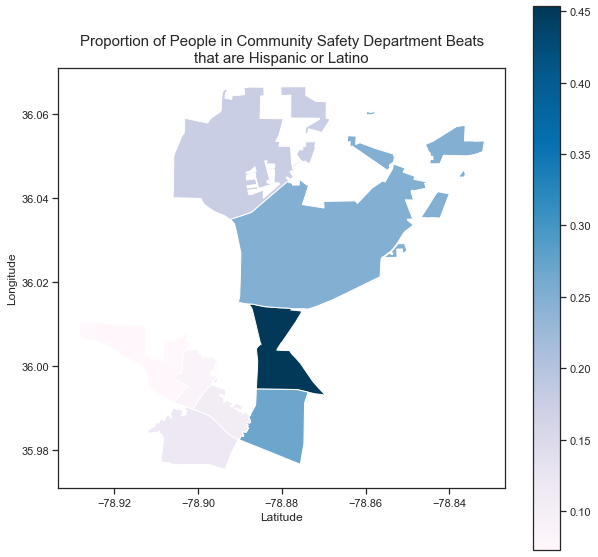

In [681]:
#Plot chloropleth map with merged data
fig, ax = plt.subplots(figsize = (10,10))
commsafehispanicsineachbeat.plot(column='prophispanic',
                                legend=True,
                                cmap="PuBu", ax=ax, aspect=1);

# ax.set(title='Number of Calls by Police Beat')
plt.title("Proportion of People in Community Safety Department Beats\nthat are Hispanic or Latino", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

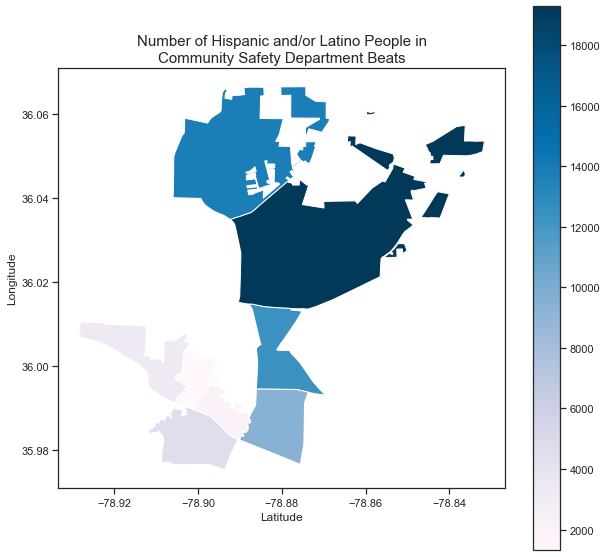

In [682]:
#Plot chloropleth map with merged data
fig, ax = plt.subplots(figsize = (10,10))
commsafehispanicsineachbeat.plot(column='total_hispanic_or_latino',
                                legend=True,
                                cmap="PuBu", ax=ax, aspect=1);

# ax.set(title='Number of Calls by Police Beat')
plt.title("Number of Hispanic and/or Latino People in\nCommunity Safety Department Beats", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

commsafehispanicsineachbeat = hispanics by police beat but only including the beats that the community safety department is currently working in
hispanicsineachbeat = hispanics by police beat for all police beats in durham
blockswithhispanics = hispanics by census block but only the blocks in beats that the community safety department is currently working in

In [683]:
commsafe_list = [511, 512, 513, 411, 113, 112, 214, 223]
hispanicsinnoncommsafebeat = hispanicsineachbeat[~hispanicsineachbeat.Beat_x.isin(commsafe_list)]
hispanicsinnoncommsafebeat.head()

Beat_x    ALAND20  AWATER20  total  total_hispanic_or_latino  \
0     111   17579442         0  32720                      8601   
3     114   56673958    441791  53897                     17371   
4     121  154087358   1453287  66559                     16154   
5     122   34177498     14796  42111                     17801   
6     123  102491731   1285915  92956                     30606   

   total_not_hispanic_or_latino  LAWBEAT  \
0                         24119      111   
3                         36526      114   
4                         50405      121   
5                         24310      122   
6                         62350      123   

                                            geometry  OBJECTID     PERIMETER  \
0  POLYGON ((-78.89039 36.01517, -78.89038 36.015...        50  28608.800781   
3  MULTIPOLYGON (((-78.84053 35.95436, -78.84021 ...        65  53321.980469   
4  MULTIPOLYGON (((-78.80746 35.99706, -78.80746 ...        38  14495.120117   
5  POLYGON ((-78.84694 36.00614, -78.84634 36.006...        54  36686.679688   
6  MULTIPOLYGON (((-78.83723 36.00399, -78.83722 ...        55  74375.859375   

  STATUS CONTIGUOUS LAWDIST  CAD GIS_DataA1    ShapeSTAre    ShapeSTLen  \
0      I        yes      D1  111       None  2.010252e+07  28608.799743   
3      I        yes      D1  114       None  6.103382e+07  53321.974873   
4      I         no      D1  121       None  7.008533e+06  14495.120026   
5      I        yes      D1  122       None  3.436298e+07  36686.681354   
6      I        yes      D1  123       None  7.495698e+07  74375.856455   

   Beat_y  id  prophispanic  
0     111   0      0.262867  
3     114   3      0.322300  
4     121   4      0.242702  
5     122   5      0.422716  
6     123   6      0.329253

In [684]:
meanpropofhispanicsnotincommsafe = hispanicsinnoncommsafebeat[["prophispanic"]].mean()
meanpropofhispanicsnotincommsafe

prophispanic    0.161424
dtype: float64

In [685]:
meanpropofhispanicsincommsafe = commsafehispanicsineachbeat[["prophispanic"]].mean()
meanpropofhispanicsincommsafe

prophispanic    0.191455
dtype: float64

In [686]:
meanpropofhispanicsinallbeats = hispanicsineachbeat[["prophispanic"]].mean()
meanpropofhispanicsinallbeats

prophispanic    0.167917
dtype: float64

start looking at pop data change by block oer past 10 years

In [687]:
hispanicdata2010 = pd.read_csv('/Users/erikrobertsson/Documents/dataplus/hispanicdata2010/hispanicdata2010.csv', skiprows =1)
hispanicdata2010['GEOID20'] = hispanicdata2010['id'].str[-15:]
hispanicdata2010.drop('id', axis=1, inplace=True)
hispanicdata2010.drop(hispanicdata2010.iloc[:, 0:25], inplace = True, axis = 1)
hispanicdata2010.drop(hispanicdata2010.iloc[:, 1:48], inplace = True, axis = 1)
#hispanicdata2010.columns = hispanicdata2010.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
hispanicdata2010.rename(columns = {'Total':'total2010'}, inplace = True)

In [688]:
hispanicpopforbothyears = pd.merge(hispanicdata2010, hispanicdata, left_on='GEOID20', right_on='geoid20')
hispanicpopforbothyears['total2010'] = hispanicpopforbothyears['total2010'].astype(int)
hispanicpopforbothyears['percentpopgrowth']= hispanicpopforbothyears['total'] / hispanicpopforbothyears['total2010']

In [689]:
hispanicpopforbothyears.columns

Index(['total2010', 'Geographic Area Name', 'GEOID20', 'geographic_area_name',
       'total', 'total_hispanic_or_latino', 'total_not_hispanic_or_latino',
       'geoid20', 'percentpopgrowth'],
      dtype='object')

In [690]:
percentgrowth = hispanicpopforbothyears[['GEOID20','percentpopgrowth']]
percentgrowth.head()

GEOID20  percentpopgrowth
0  370630001011000          1.113402
1  370630001011001          0.686275
2  370630001011002          1.000000
3  370630001011003          0.914894
4  370630001011004          0.607843

start looking at age

In [691]:
sexbyagedata = pd.read_csv('/Users/erikrobertsson/Documents/dataplus/sexbyagedata/sexbyage.csv', skiprows =1)
sexbyagedata['GEOID10'] = sexbyagedata['id'].str[-15:]
sexbyagedata.drop('id', axis=1, inplace=True)
sexbyagedata.rename(columns = {'Total':'popcount2010'}, inplace = True)
sexbyagedata.rename(columns = {'Total!!Male':'popcountmale'}, inplace = True)
sexbyagedata.rename(columns = {'Total!!Female':'popcountfemale'}, inplace = True)
sexbyagedata.columns = sexbyagedata.columns.str.lstrip('Total!!Male!!')
sexbyagedata.columns = sexbyagedata.columns.str.lstrip('Total!!Female!!')

In [692]:
#Add duplicate column names together
sexbyagedata = sexbyagedata.sum(axis=1, level=0, skipna=False)
sexbyagedata["GEOID10"] = sexbyagedata["GEOID10"].map(str)
sexbyagedata['GEOID10'] = sexbyagedata['GEOID10'].str[:-2]

In [693]:
#Merge sexbyage with percentgrowth on geoid
#sexbyage2020 = pd.merge(percentgrowth, sexbyagedata, on = 'GEOID20')
#sexbyage2020

In [694]:
#cols_s = sexbyage2020.columns[sexbyage2020.columns.str.endswith('s')]

#for col_s in cols_s:
        #sexbyage2020['2020 ' + col_s] = sexbyage2020['percentpopgrowth'] * sexbyage2020[col_s]

#sexbyage2020['popcount2010'] = sexbyage2020['popcount2010'].astype(float)
#sexbyage2020['popcount2020'] = sexbyage2020['popcount2010'] * sexbyage2020['percentpopgrowth']
#sexbyage2020.head(1)


In [695]:
sexbyagedata['14 years and under'] = sexbyagedata['Under 5 years'] + sexbyagedata['5 to 9 years'] + sexbyagedata['10 to 14 years']
sexbyagedata['15 to 24 years'] = sexbyagedata['15 to 17 years'] + sexbyagedata['18 and 19 years'] + sexbyagedata['20 years'] + sexbyagedata['21 years'] + sexbyagedata['22 to 24 years']
sexbyagedata['25 to 39 years'] = sexbyagedata['25 to 29 years'] + sexbyagedata['30 to 34 years'] + sexbyagedata['35 to 39 years']
sexbyagedata['40 to 64 years'] = sexbyagedata['40 to 44 years'] + sexbyagedata['45 to 49 years'] + sexbyagedata['50 to 54 years'] + sexbyagedata['55 to 59 years'] + sexbyagedata['60 and 61 years'] + sexbyagedata['62 to 64 years']
sexbyagedata['65 years and over'] = sexbyagedata['65 and 66 years'] + sexbyagedata['67 to 69 years'] + sexbyagedata['70 to 74 years'] + sexbyagedata['75 to 79 years'] + sexbyagedata['80 to 84 years'] + sexbyagedata['85 years and over']

In [696]:
sexbyagedata.drop(sexbyagedata.iloc[:, 2:25], inplace = True, axis = 1)
sexbyagedata.columns

Index(['popcount2010', 'popcountmale', 'popcountfemale',
       'Geographic Area Name', 'GEOID10', '14 years and under',
       '15 to 24 years', '25 to 39 years', '40 to 64 years',
       '65 years and over'],
      dtype='object')

In [697]:
durhamagemap = pd.merge(sexbyagedata, durhamblockmap, left_on ='GEOID10', right_on='GEOID20')
durhamagemap.drop(['MTFCC20', 'UATYPE20', 'FUNCSTAT20', 'ALAND20', 'AWATER20', 'BLOCKCE20', 'TRACTCE20', 'UR20', 'UACE20', 'STATEFP20', 'NAME20'], axis=1, inplace=True)
durhamagemap['popcount2010'] = durhamagemap['popcountmale'] + durhamagemap['popcountfemale']
durhamagemap['propadults']= durhamagemap['25 to 39 years'] / durhamagemap['popcount2010']
durhamagemap['propboomers']= durhamagemap['40 to 64 years'] / durhamagemap['popcount2010']
durhamagemap['propyouth']= durhamagemap['15 to 24 years'] / durhamagemap['popcount2010']
durhamagemap['propchildren']= durhamagemap['14 years and under'] / durhamagemap['popcount2010']
durhamagemap['propseniors']= durhamagemap['65 years and over'] / durhamagemap['popcount2010']

In [698]:
meanadultprop = durhamagemap[["propadults"]].mean()
meanadultprop

propadults    0.238455
dtype: float64

In [699]:
meanboomerprop = durhamagemap[["propboomers"]].mean()
meanboomerprop

propboomers    0.343124
dtype: float64

In [700]:
meanyouthprop = durhamagemap[["propyouth"]].mean()
meanyouthprop

propyouth    0.118396
dtype: float64

In [701]:
meanchildrenprop = durhamagemap[["propchildren"]].mean()
meanchildrenprop

propchildren    0.177689
dtype: float64

In [702]:
meanseniorprop = durhamagemap[["propseniors"]].mean()
meanseniorprop

propseniors    0.122337
dtype: float64

In [815]:
durham2000blockmap = gpd.read_file('/Users/erikrobertsson/Documents/dataplus/2000durhamblocksshapefile/fe_2007_37063_tabblock00.shp')
durham2000blockmap = durham2000blockmap.to_crs("EPSG:4326")

In [816]:
#Assign each census block to a police beat with for loop
cblockIndexToBeat = {}
sIndex = policebeats.sindex

for cblock_ind in durham2000blockmap.index:
    cblock_geom = durham2000blockmap.loc[cblock_ind]["geometry"]
    possibleBeatMatches = list(sIndex.intersection(cblock_geom.bounds))
    matched = False

    if len(possibleBeatMatches) > 0:
        possibleMatches = policebeats.iloc[possibleBeatMatches]
        intersectingAreas = possibleMatches.intersection(cblock_geom).area
        intersectingAreas /= cblock_geom.area
        police_beat_index = intersectingAreas.idxmax()
        maxIntersection = intersectingAreas.max()
    ##########
        if maxIntersection < 0.1:
            continue
    ##########
        if maxIntersection > 0:
            cblockIndexToBeat[cblock_ind] = policebeats.loc[police_beat_index]['LAWBEAT']
            matched = True

cblockDurhamBeats2000 = durham2000blockmap[durham2000blockmap.index.isin(cblockIndexToBeat)]
cblockDurhamBeats2000['Beat'] = cblockDurhamBeats2000.index.map(lambda ii: cblockIndexToBeat[ii])
warnings.filterwarnings('ignore')

In [703]:
durham2010blockmap = gpd.read_file('/Users/erikrobertsson/Documents/dataplus/2010durhamblocksshapefile/tl_2010_37063_tabblock10.shp')
durham2010blockmap = durham2010blockmap.to_crs("EPSG:4326")

In [704]:
#Assign each census block to a police beat with for loop
cblockIndexToBeat = {}
sIndex = policebeats.sindex

for cblock_ind in durham2010blockmap.index:
    cblock_geom = durham2010blockmap.loc[cblock_ind]["geometry"]
    possibleBeatMatches = list(sIndex.intersection(cblock_geom.bounds))
    matched = False

    if len(possibleBeatMatches) > 0:
        possibleMatches = policebeats.iloc[possibleBeatMatches]
        intersectingAreas = possibleMatches.intersection(cblock_geom).area
        intersectingAreas /= cblock_geom.area
        police_beat_index = intersectingAreas.idxmax()
        maxIntersection = intersectingAreas.max()
    ##########
        if maxIntersection < 0.1:
            continue
    ##########
        if maxIntersection > 0:
            cblockIndexToBeat[cblock_ind] = policebeats.loc[police_beat_index]['LAWBEAT']
            matched = True

cblockDurhamBeats2010 = durham2010blockmap[durham2010blockmap.index.isin(cblockIndexToBeat)]
cblockDurhamBeats2010['Beat'] = cblockDurhamBeats2010.index.map(lambda ii: cblockIndexToBeat[ii])
warnings.filterwarnings('ignore')

start of checking how callcountperperson correlates with proportion of people that are "youth"

In [705]:
agedataindurhambyblocks = pd.merge(cblockDurhamBeats2010, sexbyagedata, on ='GEOID10')
agesumbybeat = agedataindurhambyblocks.groupby('Beat', as_index=False).sum()
agesumbybeat['popcount2010'] = agesumbybeat['popcountmale'] + agesumbybeat['popcountfemale']
agesumbybeat['propfemale'] = agesumbybeat['popcountfemale'] / agesumbybeat['popcount2010']
agesumbybeat['propmale'] = agesumbybeat['popcountmale'] / agesumbybeat['popcount2010']
agesumbybeat.drop('popcountmale', axis=1, inplace=True)
agesumbybeat.drop('popcountfemale', axis=1, inplace=True)
agesumbybeat.drop('AWATER10', axis=1, inplace=True)
agesumbybeat.drop('ALAND10', axis=1, inplace=True)

In [706]:
agesumbybeat['popcount2010'].sum()

234898

In [707]:
#agesumbybeat = agesumbybeat.set_crs("EPSG:4326")
#agesumbybeat = agesumbybeat.to_crs("EPSG:4326")

In [708]:
beats_callcount_agedata = pd.merge(beats_callcount_popdata, agesumbybeat, left_on ='LAWBEAT', right_on='Beat')
beats_callcount_agedata['callcountperperson']= beats_callcount_agedata['calls_count'] / beats_callcount_agedata['total']
beats_callcount_agedata['propadults']= beats_callcount_agedata['25 to 39 years'] / beats_callcount_agedata['popcount2010']
beats_callcount_agedata['propboomers']= beats_callcount_agedata['40 to 64 years'] / beats_callcount_agedata['popcount2010']
beats_callcount_agedata['propyouth']= beats_callcount_agedata['15 to 24 years'] / beats_callcount_agedata['popcount2010']
beats_callcount_agedata['propchildren']= beats_callcount_agedata['14 years and under'] / beats_callcount_agedata['popcount2010']
beats_callcount_agedata['propseniors']= beats_callcount_agedata['65 years and over'] / beats_callcount_agedata['popcount2010']

In [709]:
column_1 = beats_callcount_agedata["propseniors"]
column_2 = beats_callcount_agedata["callcountperperson"]
correlation = column_1.corr(column_2)
correlation

-0.08644345338058662

end of checking how callcountperperson correlates with proportion of people that are "youth"

In [710]:
isolating3columns = beats_callcount_agedata[['propyouth', 'propseniors']]
filtered_df = isolating3columns[isolating3columns['propyouth'].notnull()]
filtered_df = filtered_df[filtered_df['propseniors'].notnull()]
filtered_df

propyouth  propseniors
0    0.148442     0.076862
1    0.144272     0.065064
2    0.159611     0.057385
3    0.147254     0.071692
4    0.127660     0.047348
..        ...          ...
31   0.113032     0.041198
32   0.591384     0.051746
33   0.277344     0.015625
34   0.129730     0.128829
35   0.069343     0.259124

[36 rows x 2 columns]

In [711]:
X = filtered_df.iloc[:, 0].values.reshape(-1, 1)
Y = filtered_df.iloc[:, 1].values.reshape(-1, 1)
#lr = LinearRegression()
#lr.fit(X, Y)
#Y_pred = lr.predict(X)

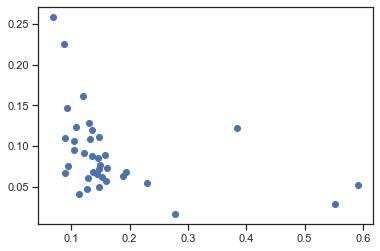

In [712]:
plt.scatter(X, Y)
#plt.plot(X, Y_pred, color = 'red')
plt.show()

In [713]:
X_mean = np.mean(X)
Y_mean = np.mean(Y)

num = 0
den = 0
for i in range(len(X)):
    num += (X[i] - X_mean)*(Y[i] - Y_mean)
    den += (X[i] - X_mean)**2
m = num / den
c = Y_mean - m*X_mean

print(m, c)

[-0.16439592] [0.11826085]


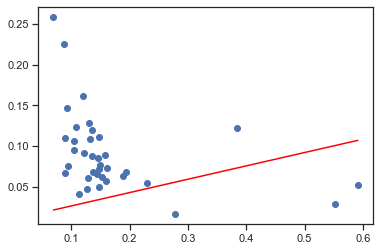

In [714]:
# Making predictions
Y_pred = m*X + c

plt.scatter(X, Y) # actual data
plt.plot([min(X), max(X)], [min(Y_pred), max(Y_pred)], color='red') # predicted
plt.show() 

start looking at household income data

In [715]:
ncblockgroupmap = gpd.read_file('/Users/erikrobertsson/Documents/dataplus/2015blockgroupshapefile/tl_2015_37_bg.shp')
ncblockgroupmap = ncblockgroupmap.to_crs("EPSG:4326")
ncblockgroupmap.head(1)

STATEFP COUNTYFP TRACTCE BLKGRPCE         GEOID       NAMELSAD  MTFCC  \
0      37      021  002401        2  370210024012  Block Group 2  G5030   

  FUNCSTAT     ALAND  AWATER     INTPTLAT      INTPTLON  \
0        S  15365558       0  +35.5219587  -082.7467767   

                                            geometry  
0  POLYGON ((-82.78041 35.52550, -82.78006 35.525...

In [716]:
durhamblockgroupmap = ncblockgroupmap[ncblockgroupmap["COUNTYFP"]=="063"]

In [717]:
#Assign each census block to a police beat with for loop
cblockIndexToBeat = {}
sIndex = policebeats.sindex

for cblock_ind in durhamblockgroupmap.index:
    cblock_geom = durhamblockgroupmap.loc[cblock_ind]["geometry"]
    possibleBeatMatches = list(sIndex.intersection(cblock_geom.bounds))
    matched = False

    if len(possibleBeatMatches) > 0:
        possibleMatches = policebeats.iloc[possibleBeatMatches]
        intersectingAreas = possibleMatches.intersection(cblock_geom).area
        intersectingAreas /= cblock_geom.area
        police_beat_index = intersectingAreas.idxmax()
        maxIntersection = intersectingAreas.max()
    ##########
        if maxIntersection < 0.1:
            continue
    ##########
        if maxIntersection > 0:
            cblockIndexToBeat[cblock_ind] = policebeats.loc[police_beat_index]['LAWBEAT']
            matched = True

cblockDurhamBeatsbg = ncblockgroupmap[ncblockgroupmap.index.isin(cblockIndexToBeat)]
cblockDurhamBeatsbg['Beat'] = cblockDurhamBeatsbg.index.map(lambda ii: cblockIndexToBeat[ii])
warnings.filterwarnings('ignore')

In [718]:
householdincomedata = pd.read_csv('/Users/erikrobertsson/Documents/dataplus/householdincome/ACSDT5Y2020.B19001_data_with_overlays_2022-04-26T111027.csv', skiprows =1)
householdincomedata['GEOID'] = householdincomedata['id'].str[-12:]
householdincomedata.drop('id', axis=1, inplace=True)
householdincomedata = householdincomedata.drop(householdincomedata.filter(regex='Margin').columns, axis=1)
householdincomedata.rename(columns=lambda s: s.replace("Estimate!!Total", "Total"), inplace=True)
householdincomedata.rename(columns=lambda s: s.replace(":!!", " "), inplace=True)
householdincomedata.rename(columns = {'Total:':'Total Households'}, inplace = True)
householdincomedata.columns

Index(['Total Households', 'Total Less than $10,000',
       'Total $10,000 to $14,999', 'Total $15,000 to $19,999',
       'Total $20,000 to $24,999', 'Total $25,000 to $29,999',
       'Total $30,000 to $34,999', 'Total $35,000 to $39,999',
       'Total $40,000 to $44,999', 'Total $45,000 to $49,999',
       'Total $50,000 to $59,999', 'Total $60,000 to $74,999',
       'Total $75,000 to $99,999', 'Total $100,000 to $124,999',
       'Total $125,000 to $149,999', 'Total $150,000 to $199,999',
       'Total $200,000 or more', 'Geographic Area Name', 'GEOID'],
      dtype='object')

In [719]:
incomedataindurhambyblocks = pd.merge(cblockDurhamBeatsbg, householdincomedata, on = 'GEOID')
incomedataindurhambyblocks.drop(['MTFCC', 'BLKGRPCE', 'COUNTYFP', 'FUNCSTAT', 'ALAND', 'AWATER', 'TRACTCE', 'STATEFP'], axis=1, inplace=True)
incomedataindurhambyblocks

GEOID       NAMELSAD     INTPTLAT      INTPTLON  \
0    370630020191  Block Group 1  +35.9028449  -078.9763172   
1    370630020201  Block Group 1  +35.8836714  -078.9598590   
2    370630018082  Block Group 2  +35.9604800  -078.8131335   
3    370630020241  Block Group 1  +35.9367893  -078.9298792   
4    370630020261  Block Group 1  +35.9439653  -078.9103599   
..            ...            ...          ...           ...   
109  370630020252  Block Group 2  +35.9256871  -078.9021591   
110  370630020253  Block Group 3  +35.9230007  -078.8949901   
111  370630023001  Block Group 1  +35.9883606  -078.9039140   
112  370630018024  Block Group 4  +35.9714699  -078.8605758   
113  370630018081  Block Group 1  +35.9724788  -078.8106650   

                                              geometry  Beat  \
0    POLYGON ((-78.98415 35.91174, -78.98394 35.911...   324   
1    POLYGON ((-78.97849 35.86682, -78.97764 35.867...   324   
2    POLYGON ((-78.84685 35.96561, -78.84617 35.965...   124   
3    POLYGON ((-78.94474 35.92757, -78.94472 35.927...   322   
4    POLYGON ((-78.92158 35.94611, -78.92127 35.946...   415   
..                                                 ...   ...   
109  POLYGON ((-78.91093 35.92733, -78.91092 35.927...   421   
110  POLYGON ((-78.90776 35.92102, -78.90768 35.921...   421   
111  POLYGON ((-78.90864 35.98597, -78.90769 35.986...   411   
112  POLYGON ((-78.86928 35.97622, -78.86927 35.976...   114   
113  POLYGON ((-78.82982 35.97118, -78.82974 35.971...   124   

     Total Households  Total Less than $10,000  Total $10,000 to $14,999  \
0                 943                       65                         0   
1                 862                        0                         0   
2                1412                       49                         0   
3                 629                       15                        14   
4                1048                       59                       104   
..                ...                      ...                       ...   
109               711                        0                         0   
110               424                        0                         0   
111               635                       55                       122   
112               223                        0                        16   
113               768                        0                        15   

     Total $15,000 to $19,999  Total $20,000 to $24,999  \
0                           0                        16   
1                           0                         0   
2                           0                        15   
3                           0                        15   
4                          69                        45   
..                        ...                       ...   
109                        26                         0   
110                         9                        23   
111                         9                        33   
112                         0                        35   
113                         0                        13   

     Total $25,000 to $29,999  Total $30,000 to $34,999  \
0                          63                        15   
1                           0                         0   
2                          14                        36   
3                           6                        61   
4                          43                        47   
..                        ...                       ...   
109                       100                        20   
110                         0                        30   
111                         7                         0   
112                         0                        19   
113                        56                        29   

     Total $35,000 to $39,999  Total $40,000 to $44,999  \
0                          68                        66   
1                          18        

In [720]:
incomesumbybeat = incomedataindurhambyblocks.groupby('Beat', as_index=False).sum()
incomesumbybeat['0to25']= incomesumbybeat['Total Less than $10,000'] + incomesumbybeat['Total $10,000 to $14,999'] + incomesumbybeat['Total $15,000 to $19,999'] + incomesumbybeat['Total $20,000 to $24,999']
incomesumbybeat['25to50']= incomesumbybeat['Total $25,000 to $29,999'] + incomesumbybeat['Total $30,000 to $34,999'] + incomesumbybeat['Total $35,000 to $39,999'] + incomesumbybeat['Total $40,000 to $44,999'] + incomesumbybeat['Total $45,000 to $49,999']
incomesumbybeat['50to75']= incomesumbybeat['Total $50,000 to $59,999'] + incomesumbybeat['Total $60,000 to $74,999']
incomesumbybeat['75to100']= incomesumbybeat['Total $75,000 to $99,999']
incomesumbybeat['100plus']= incomesumbybeat['Total $100,000 to $124,999'] + incomesumbybeat['Total $125,000 to $149,999'] + incomesumbybeat['Total $150,000 to $199,999'] + incomesumbybeat['Total $200,000 or more']
incomesumbybeat['prop0to25']= incomesumbybeat['0to25'] / incomesumbybeat['Total Households']
incomesumbybeat['prop25to50']= incomesumbybeat['25to50'] / incomesumbybeat['Total Households']
incomesumbybeat['prop50to75']= incomesumbybeat['50to75'] / incomesumbybeat['Total Households']
incomesumbybeat['prop75to100']= incomesumbybeat['75to100'] / incomesumbybeat['Total Households']
incomesumbybeat['prop100plus']= incomesumbybeat['100plus'] / incomesumbybeat['Total Households']

In [721]:
incomesumbybeat['Total Households'].sum()

62671

In [722]:
beats_callcount_popdata_income = pd.merge(beats_callcount_popdata, incomesumbybeat, left_on ='LAWBEAT', right_on='Beat')

In [723]:
mappingdatasetforpolicebeats_w_income = pd.merge(policebeats, beats_callcount_popdata_income, on ='LAWBEAT')
mappingdatasetforpolicebeats_w_income

LAWBEAT                                           geometry  OBJECTID_x  \
0       111  POLYGON ((-78.89039 36.01517, -78.89038 36.015...          50   
1       112  POLYGON ((-78.88787 36.01473, -78.88734 36.014...          51   
2       113  POLYGON ((-78.87372 35.99369, -78.87458 35.991...          62   
3       114  MULTIPOLYGON (((-78.84053 35.95436, -78.84021 ...          65   
4       121  MULTIPOLYGON (((-78.80746 35.99706, -78.80746 ...          38   
..      ...                                                ...         ...   
29      422  MULTIPOLYGON (((-78.93721 35.87524, -78.93699 ...         108   
30      423  MULTIPOLYGON (((-78.83466 35.94599, -78.83463 ...          95   
31      511  POLYGON ((-78.92318 36.01031, -78.92260 36.010...          53   
32      512  POLYGON ((-78.90313 36.00376, -78.90298 36.003...          57   
33      513  POLYGON ((-78.89561 35.99710, -78.89553 35.997...          61   

      PERIMETER_x STATUS CONTIGUOUS LAWDIST  CAD GIS_DataA1  ShapeSTAre_x  \
0    28608.800781      I        yes      D1  111       None  2.010252e+07   
1    26265.849609      I        yes      D1  112       None  2.079934e+07   
2    20667.539062      I        yes      D1  113       None  2.159195e+07   
3    53321.980469      I        yes      D1  114       None  6.103382e+07   
4    14495.120117      I         no      D1  121       None  7.008533e+06   
..            ...    ...        ...     ...  ...        ...           ...   
29  119968.398438      I        yes      D4  422       None  1.364002e+08   
30  151917.093750      I        yes      D4  423       None  2.561465e+08   
31   32615.019531      I        yes      D5  511       None  2.129644e+07   
32   16338.889648      I        yes      D5  512       None  9.305014e+06   
33   20647.179688      I        yes      D5  513       None  9.114313e+06   

     ShapeSTLen_x  Beat  id_x  OBJECTID_y    PERIMETER_y  ShapeSTAre_y  \
0    28608.799743   111     0        50.0   28608.800781  2.010252e+07   
1    26265.852604   112     1        51.0   26265.849609  2.079934e+07   
2    20667.538873   113     2        62.0   20667.539062  2.159195e+07   
3    53321.974873   114     3        65.0   53321.980469  6.103382e+07   
4    14495.120026   121     4        38.0   14495.120117  7.008533e+06   
..            ...   ...   ...         ...            ...           ...   
29  119968.366828   422    31       108.0  119968.398438  1.364002e+08   
30  151917.121852   423    32        95.0  151917.093750  2.561465e+08   
31   32615.017763   511    33        53.0   32615.019531  2.129644e+07   
32   16338.888321   512    34        57.0   16338.889648  9.305014e+06   
33   20647.175971   513    35        61.0   20647.179688  9.114313e+06   

     ShapeSTLen_y  Beat_left  id_y    index_right    Event Numb             X  \
0    28608.799743      111.0   0.0  138122.938830  2.122898e+07  2.032588e+06   
1    26265.852604      112.0   1.0  158277.419178  2.126486e+07  2.035117e+06   
2    20667.538873      113.0   2.0  136544.927660  2.122672e+07  2.034771e+06   
3    53321.974873      114.0   3.0  136054.364431  2.122669e+07  2.039702e+06   
4    14495.120026      121.0   4.0  144309.904215  2.124058e+07  2.044614e+06   
..            ...        ...   ...            ...           ...           ...   
29  119968.366828      422.0  31.0  152273.064338  2.125396e+07  2.028308e+06   
30  151917.121852      423.0  32.0  149586.792254  2.124912e+07  2.048046e+06   
31   32615.017763      511.0  33.0  137519.151030  2.122905e+07  2.025700e+06   
32   16338.888321      512.0  34.0  148823.707143  2.124809e+07  2.029196e+06   
33   20647.175971      513.0  35.0  141478.864916  2.123570e+07  2.031472e+06   

                Y  Cancelled  calls_count      area  Beat_x   ALAND20  \
0   817220.396277        0.0        376.0  0.000187     111   1885019   
1   818966.142466        0.0        365.0  0.000193     112   1863048   
2   814367.727660        0.0        470.0  0.000200     113  

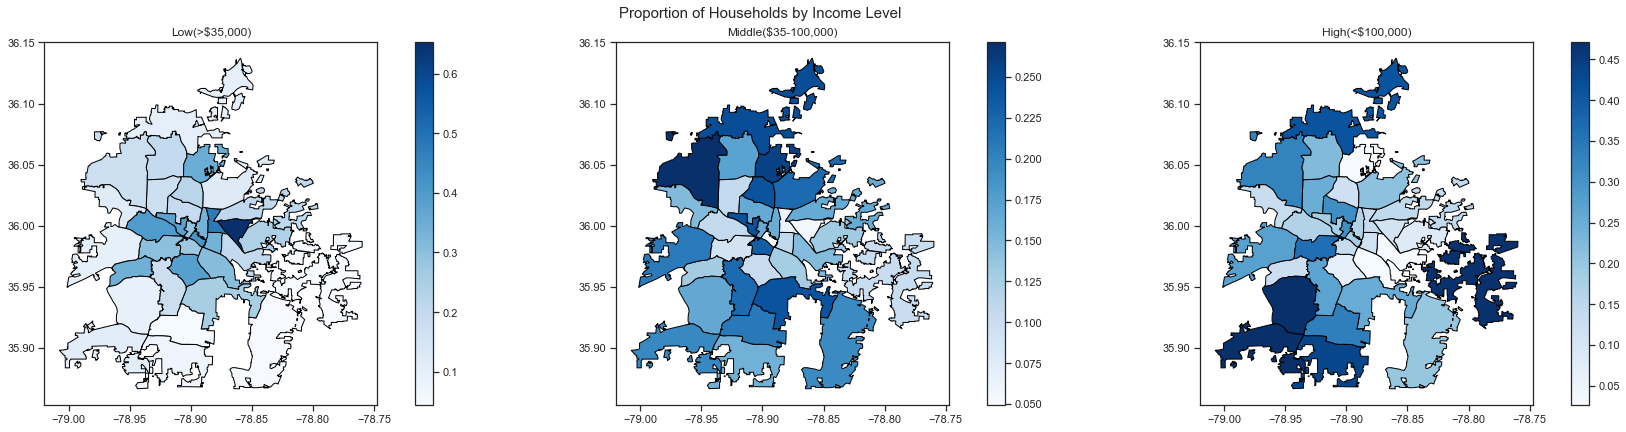

In [724]:
#Plot subplots of income
fig = plt.figure(constrained_layout=True, figsize=(24, 16))

gridspan = fig.add_gridspec(1, 1)
gs = GridSpec(3, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax1.title.set_text('Low(>$35,000)')
ax2.title.set_text('Middle($35-100,000)')
ax3.title.set_text('High(<$100,000)')

# Set figure title
fig.suptitle("Proportion of Households by Income Level", fontsize = 15)

#Plot subplots
mappingdatasetforpolicebeats_w_income.plot(column='prop0to25',
                                legend=True,
                                cmap="Blues", ax=ax1, aspect=1, edgecolor='black');

mappingdatasetforpolicebeats_w_income.plot(column='prop50to75',
                                legend=True,
                                cmap="Blues", ax=ax2, aspect=1, edgecolor='black');

mappingdatasetforpolicebeats_w_income.plot(column='prop100plus',
                                legend=True,
                                cmap="Blues", ax=ax3, aspect=1, edgecolor='black');

plt.show()

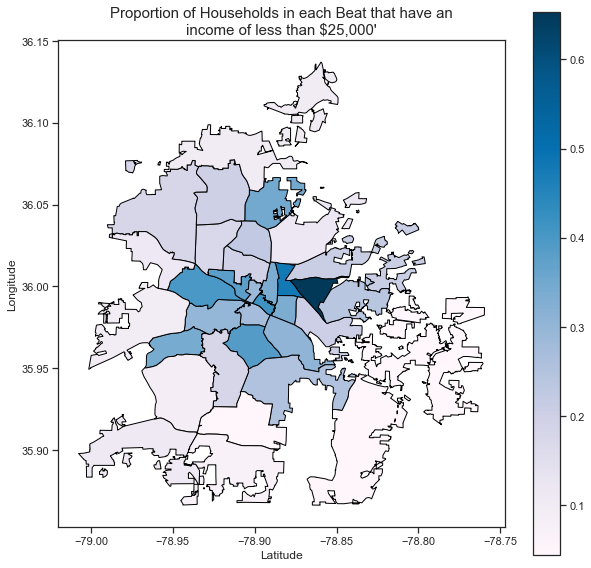

In [725]:
#Plot chloropleth map with merged data
fig, ax = plt.subplots(figsize = (10,10))
mappingdatasetforpolicebeats_w_income.plot(column='prop0to25',
                                legend=True,
                                cmap="PuBu", ax=ax, aspect=1, edgecolor = 'black');

# ax.set(title='Number of Calls by Police Beat')
plt.title("Proportion of Households in each Beat that have an\nincome of less than $25,000'", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

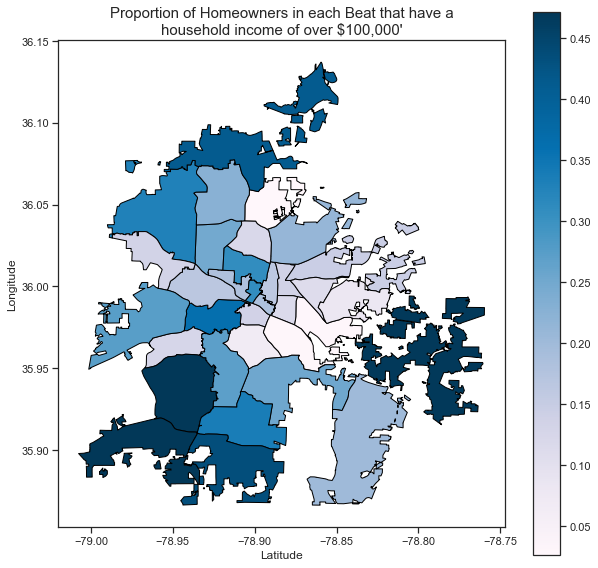

In [726]:
#Plot chloropleth map with merged data
fig, ax = plt.subplots(figsize = (10,10))
mappingdatasetforpolicebeats_w_income.plot(column='prop100plus',
                                legend=True,
                                cmap="PuBu", ax=ax, aspect=1, edgecolor = 'black');

# ax.set(title='Number of Calls by Police Beat')
plt.title("Proportion of Homeowners in each Beat that have a\nhousehold income of over $100,000'", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

end of looking at household income data

start looking at household type data

In [727]:
householdtypedata = pd.read_csv('/Users/erikrobertsson/Documents/dataplus/household_type/householdtypedata.csv', skiprows =1)
householdtypedata['GEOID10'] = householdtypedata['id'].str[-15:]
householdtypedata.drop('id', axis=1, inplace=True)
householdtypedata.rename(columns=lambda s: s.replace("!!", " "), inplace=True)
householdtypedata.rename(columns = {'Total Family households Other family Female householder, no husband present':'Total Single Mother Households'}, inplace = True)
householdtypedata.rename(columns = {'Total Family households Other family Male householder, no wife present':'Total Single Father Households'}, inplace = True)
householdtypedata.rename(columns = {'Total Family households Other family':'Total Single Parent Households'}, inplace = True)
householdtypedata.rename(columns = {'Total':'Total Households'}, inplace = True)
householdtypedata = householdtypedata[['GEOID10', 'Geographic Area Name', 'Total Households', 'Total Family households', 'Total Family households Husband-wife family', 'Total Single Parent Households', 'Total Single Father Households', 'Total Single Mother Households', 'Total Nonfamily households', 'Total Nonfamily households Householder living alone', 'Total Nonfamily households Householder not living alone']]

In [728]:
householddatadurhambyblocks = pd.merge(cblockDurhamBeats2010, householdtypedata, left_on ='GEOID10', right_on='GEOID10')
householddatadurhambyblocks.rename(columns = {'GEOID10':'GEOID20'}, inplace = True)
householddatadurhambyblocks.drop(['MTFCC10', 'TRACTCE10', 'UR10', 'BLOCKCE10', 'UACE10', 'UATYP10', 'COUNTYFP10', 'FUNCSTAT10', 'ALAND10', 'AWATER10', 'STATEFP10'], axis=1, inplace=True)

In [729]:
householdtypesumbybeat = householddatadurhambyblocks.groupby('Beat', as_index=False).sum()

In [730]:
householdtypesumbybeat['Total Households'].sum()

96040

In [731]:
beats_callcount_pop_age_householdtype = pd.merge(beats_callcount_agedata, householdtypesumbybeat, left_on ='LAWBEAT', right_on='Beat')
beats_callcount_pop_age_householdtype['propsingleparent']= beats_callcount_pop_age_householdtype['Total Single Parent Households'] / beats_callcount_pop_age_householdtype['Total Family households']
beats_callcount_pop_age_householdtype['propsinglemom']= beats_callcount_pop_age_householdtype['Total Single Mother Households'] / beats_callcount_pop_age_householdtype['Total Family households']
beats_callcount_pop_age_householdtype['propsinglefather']= beats_callcount_pop_age_householdtype['Total Single Father Households'] / beats_callcount_pop_age_householdtype['Total Family households']
beats_callcount_pop_age_householdtype['propfamilyhouseholds']= beats_callcount_pop_age_householdtype['Total Family households'] / beats_callcount_pop_age_householdtype['Total Households']
beats_callcount_pop_age_householdtype['proptwoparent']= beats_callcount_pop_age_householdtype['Total Family households Husband-wife family'] / beats_callcount_pop_age_householdtype['Total Family households']
beats_callcount_pop_age_householdtype['householdsdensity']= beats_callcount_pop_age_householdtype['Total Households'] / beats_callcount_pop_age_householdtype['area']

In [732]:
#Create a new table for callsperperson for every beat
highestsingleparent = beats_callcount_pop_age_householdtype[['propsingleparent', 'LAWBEAT']].copy()
highestsingleparent.sort_values(by='propsingleparent', inplace=True, ascending=False)
topten_singleparents = highestsingleparent.iloc[0:10].copy()
topten_singleparents

propsingleparent  LAWBEAT
34          0.765766      513
24          0.681818      411
26          0.661164      413
2           0.622875      113
25          0.612245      412
0           0.605744      111
14          0.592086      223
5           0.588757      122
1           0.575175      112
3           0.546485      114

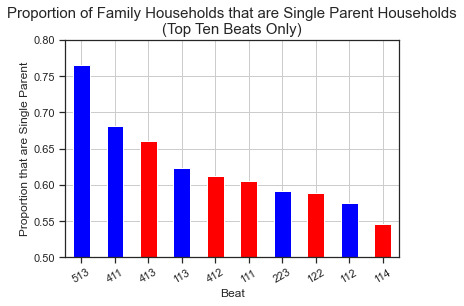

In [733]:
#Create a bar plot with callsperperson
toptennoncommsafe_list = [122, 413, 412, 111, 114]
color = ["red" if i in toptennoncommsafe_list else "blue" for i in topten_singleparents['LAWBEAT']]
topten_singleparents.plot.bar(y = 'propsingleparent', x = 'LAWBEAT', color=color, legend=False, grid=True)

plt.xticks(rotation=30, horizontalalignment="center")

plt.title("Proportion of Family Households that are Single Parent Households\n(Top Ten Beats Only)", fontsize = 15)

plt.ylim(0.5, 0.8)

plt.xlabel("Beat")

plt.ylabel("Proportion that are Single Parent")

plt.show()

In [1025]:
mappingdatasetforpolicebeats_w_householdtype = pd.merge(policebeats, beats_callcount_pop_age_householdtype, on ='LAWBEAT')
mappingdatasetforpolicebeats_w_householdtype.sort_values(by='propsingleparent', inplace=True, ascending=True)
mappingdatasetforpolicebeats_w_householdtype.head(10)

LAWBEAT                                           geometry  OBJECTID_x  \
20      321  MULTIPOLYGON (((-78.95996 35.99931, -78.95996 ...          58   
21      322  POLYGON ((-78.94765 35.95837, -78.94637 35.958...          87   
7       124  MULTIPOLYGON (((-78.77636 35.92139, -78.77722 ...          63   
12      221  MULTIPOLYGON (((-78.93799 36.07698, -78.93629 ...          17   
23      324  MULTIPOLYGON (((-78.99154 35.88848, -78.99154 ...         106   
15      224  MULTIPOLYGON (((-78.91391 36.09652, -78.91391 ...          12   
32      511  POLYGON ((-78.92318 36.01031, -78.92260 36.010...          53   
22      323  MULTIPOLYGON (((-78.98079 35.92612, -78.97989 ...          80   
30      422  MULTIPOLYGON (((-78.93721 35.87524, -78.93699 ...         108   
8       211  POLYGON ((-78.91430 36.04098, -78.91427 36.040...          36   

      PERIMETER_x STATUS CONTIGUOUS LAWDIST  CAD GIS_DataA1  ShapeSTAre_x  \
20  122575.601562      I        yes      D3  321       None  1.593645e+08   
21   60429.371094      I        yes      D3  322       None  1.639988e+08   
7    10708.070312      I         no      D1  124       None  3.022588e+06   
12   87384.078125      I        yes      D2  221       None  2.027947e+08   
23  128371.601562      I        yes      D3  324       None  1.523746e+08   
15   94210.453125      I         no      D2  224       None  7.014559e+07   
32   32615.019531      I        yes      D5  511       None  2.129644e+07   
22   74252.812500      I        yes      D3  323       None  1.066631e+08   
30  119968.398438      I        yes      D4  422       None  1.364002e+08   
8    36748.878906      I        yes      D2  211       None  6.487864e+07   

     ShapeSTLen_x  Beat_x  id_x  OBJECTID_y    PERIMETER_y  ShapeSTAre_y  \
20  122575.571649     321    21        58.0  122575.601562  1.593645e+08   
21   60429.372056     322    22        87.0   60429.371094  1.639988e+08   
7    10708.070450     124     7        63.0   10708.070312  3.022588e+06   
12   87384.076005     221    12        17.0   87384.078125  2.027947e+08   
23  128371.584023     324    24       106.0  128371.601562  1.523746e+08   
15   94210.453140     224    15        12.0   94210.453125  7.014559e+07   
32   32615.017763     511    33        53.0   32615.019531  2.129644e+07   
22   74252.813082     323    23        80.0   74252.812500  1.066631e+08   
30  119968.366828     422    31       108.0  119968.398438  1.364002e+08   
8    36748.875052     211     8        36.0   36748.878906  6.487864e+07   

     ShapeSTLen_y  Beat_left  id_y    index_right    Event Numb             X  \
20  122575.571649      321.0  21.0  139148.671916  2.123133e+07  2.006666e+06   
21   60429.372056      322.0  22.0  129243.879668  2.121472e+07  2.017400e+06   
7    10708.070450      124.0   7.0  135734.582353  2.122548e+07  2.057538e+06   
12   87384.076005      221.0  12.0  149917.109149  2.125000e+07  2.014867e+06   
23  128371.584023      324.0  24.0  138697.633690  2.123079e+07  2.012204e+06   
15   94210.453140      224.0  15.0  141863.540816  2.123597e+07  2.027551e+06   
32   32615.017763      511.0  33.0  137519.151030  2.122905e+07  2.025700e+06   
22   74252.813082      323.0  23.0  152757.031579  2.125483e+07  2.004834e+06   
30  119968.366828      422.0  31.0  152273.064338  2.125396e+07  2.028308e+06   
8    36748.875052      211.0   8.0  139124.752011  2.123098e+07  2.022421e+06   

                Y  Cancelled  calls_count      area  Beat_x   ALAND20  \
20  806437.871391        0.0        381.0  0.001490     321  15209054   
21  793929.307054        0.0        241.0  0.001522     322  15676836   
7   802123.888235        0.0        170.0  0.002269     124  32035320   
12  828912.953451        0.0        623.0  0.001929     221  18543956   
23  784917.778075        0.0        374.0  0.001473     324  15404774   
15  846746.670068        0.0        294.0  0.002107     224  20690360   
32  819510.860412        0.0        437.0  0.000198     5

In [1031]:
policebeats_list_obj = [121, 122, 112, 111, 123, 114, 113, 124, 212, 214, 213, 211, 223, 222, 221, 224, 313, 312, 321, 314, 323, 324, 322, 311, 411, 415, 412, 413, 414, 422, 421, 423, 511, 512, 513]
mappingdatasetforpolicebeats_w_householdtype = mappingdatasetforpolicebeats_w_householdtype[mappingdatasetforpolicebeats_w_householdtype.LAWBEAT.isin(policebeats_list_obj)]

commsafe_list = [112, 113, 214, 223, 411, 511, 512, 513, 122, 222, 111, 213]
mappingdatasetforpolicebeats_w_householdtypecommsafe = mappingdatasetforpolicebeats_w_householdtype[mappingdatasetforpolicebeats_w_householdtype.LAWBEAT.isin(commsafe_list)]


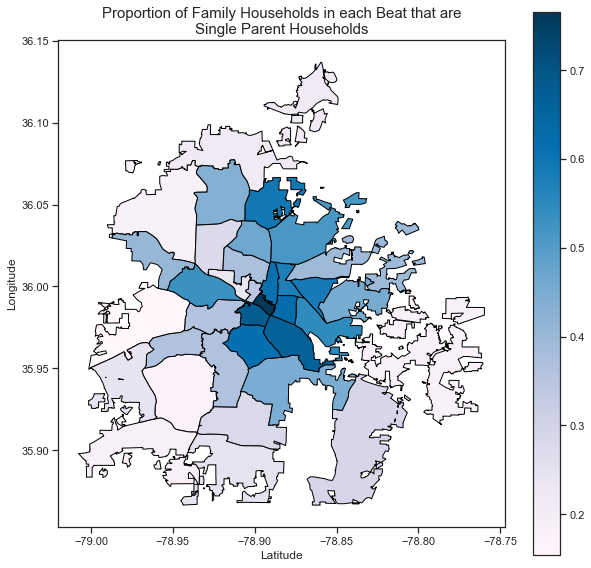

In [1027]:
#Plot chloropleth map with merged data
fig, ax = plt.subplots(figsize = (10,10))
mappingdatasetforpolicebeats_w_householdtype.plot(column='propsingleparent',
                                legend=True,
                                cmap="PuBu", ax=ax, aspect=1, edgecolor = 'black');

# ax.set(title='Number of Calls by Police Beat')
plt.title("Proportion of Family Households in each Beat that are\nSingle Parent Households", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [737]:
#correlation with pvalue
stats.pearsonr(beats_callcount_pop_age_householdtype['callcountperperson'], beats_callcount_pop_age_householdtype['propsingleparent'])


(0.5245220642364854, 0.0010236685393736)

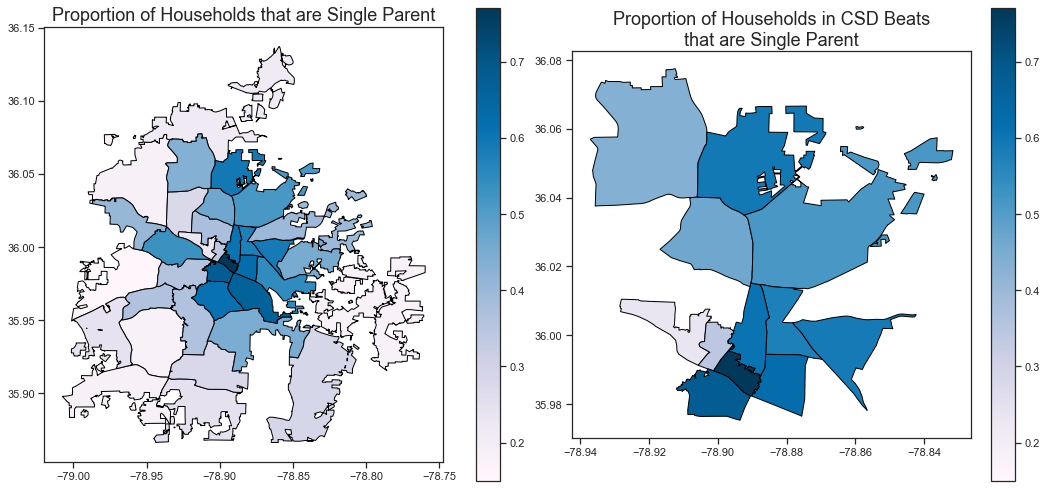

In [1028]:
fig = plt.figure(constrained_layout=True, figsize=(20, 20))

gridspan = fig.add_gridspec(1, 1)

gs = GridSpec(3, 3, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])

ax2 = fig.add_subplot(gs[0, 1])

ax1.set_title('Proportion of Households that are Single Parent', fontdict={'fontsize': '18', 'fontweight' : '3'})

ax2.set_title('Proportion of Households in CSD Beats\nthat are Single Parent', fontdict={'fontsize': '18', 'fontweight' : '3'})


vmin, vmax = 0.15, 0.77

#Plot subplots
mappingdatasetforpolicebeats_w_householdtype.plot(column='propsingleparent',
                                legend=True,
                                vmin = vmin, vmax = vmax, 
                                cmap="PuBu", ax=ax1, aspect=1, edgecolor='black');

mappingdatasetforpolicebeats_w_householdtypecommsafe.plot(column='propsingleparent',
                                legend=True,
                                vmin = vmin, vmax = vmax, 
                                cmap="PuBu", ax=ax2, aspect=1, edgecolor='black');

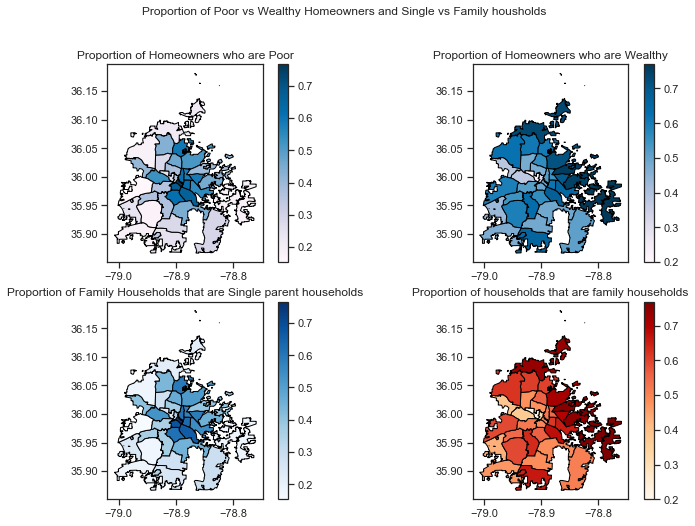

In [739]:
#Plot subplots of racial data
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

ax11 = axs[0][0]
ax12 = axs[0][1]
ax21 = axs[1][0]
ax22 = axs[1][1]
ax11.title.set_text('Proportion of Homeowners who are Poor')
ax12.title.set_text('Proportion of Homeowners who are Wealthy')
ax21.title.set_text('Proportion of Family Households that are Single parent households')
ax22.title.set_text('Proportion of households that are family households')

# Set figure title
fig.suptitle("Proportion of Poor vs Wealthy Homeowners and Single vs Family housholds")

#Plot subplots
mappingdatasetforpolicebeats_w_householdtype.plot(column='propsingleparent',
                                legend=True,
                                cmap="PuBu", ax=ax11, aspect=1, edgecolor='black');

mappingdatasetforpolicebeats_w_householdtype.plot(column='propfamilyhouseholds',
                                legend=True,
                                cmap="PuBu", ax=ax12, aspect=1, edgecolor='black');

mappingdatasetforpolicebeats_w_householdtype.plot(column='propsingleparent',
                                legend=True,
                                cmap="Blues", ax=ax21, aspect=1, edgecolor='black');

mappingdatasetforpolicebeats_w_householdtype.plot(column='propfamilyhouseholds',
                                legend=True,
                                cmap="OrRd", ax=ax22, aspect=1, edgecolor='black');

plt.show()

start looking at race data

In [831]:
racedata = pd.read_csv('/Users/erikrobertsson/Documents/dataplus/Race data files/racedata2020/DECENNIALPL2020.P1_data_with_overlays_2022-06-02T110204.csv', skiprows =1)
racedata['GEOID20'] = racedata['id'].str[-15:]
racedata.drop('id', axis=1, inplace=True)
racedata.columns = racedata.columns.str.replace(' !!T', 'T')
racedata.columns = racedata.columns.str.replace('[#,@,&,!]', '')
racedata.columns = racedata.columns.str.replace('[:]', ' ')
racedata.columns = racedata.columns.str.replace('of one race', 'of')
racedata.rename(columns = {'Total Population of two or more races ':'Total Mixed Races'}, inplace = True)
racedata.rename(columns = {'Total ':'Total Population'}, inplace = True)
racedata.drop('Total Population of ', axis=1, inplace=True)
racedata.drop(racedata.iloc[:, 9:71], inplace = True, axis = 1)
racedata

Geographic Area Name  Total Population  \
0     Block 1000, Block Group 1, Census Tract 1.01, ...               108   
1     Block 1001, Block Group 1, Census Tract 1.01, ...                35   
2     Block 1002, Block Group 1, Census Tract 1.01, ...                38   
3     Block 1003, Block Group 1, Census Tract 1.01, ...                43   
4     Block 1004, Block Group 1, Census Tract 1.01, ...                31   
...                                                 ...               ...   
4396  Block 1068, Block Group 1, Census Tract 9801, ...                 0   
4397  Block 1069, Block Group 1, Census Tract 9801, ...                 0   
4398  Block 1070, Block Group 1, Census Tract 9801, ...                 0   
4399  Block 1071, Block Group 1, Census Tract 9801, ...                 0   
4400  Block 1072, Block Group 1, Census Tract 9801, ...                 0   

      Total Population of White alone  \
0                                  18   
1                                  13   
2                                  17   
3                                  21   
4                                   5   
...                               ...   
4396                                0   
4397                                0   
4398                                0   
4399                                0   
4400                                0   

      Total Population of Black or African American alone  \
0                                                    61     
1                                                     5     
2                                                     9     
3                                                    19     
4                                                    18     
...                                                 ...     
4396                                                  0     
4397                                                  0     
4398                                                  0     
4399                                                  0     
4400                                                  0     

      Total Population of American Indian and Alaska Native alone  \
0                                                     3             
1                                                     0             
2                                                     0             
3                                                     0             
4                                                     0             
...                                                 ...             
4396                                                  0             
4397                                                  0             
4398                                                  0             
4399                                                  0             
4400                                                  0             

      Total Population of Asian alone  \
0                                   0   
1                                   0   
2                                   0   
3                                   0   
4                                   1   
...                               ...   
4396                                0   
4397                                0   
4398                                0   
4399                                0   
4400                                0   

      Total Population of Native Hawaiian and Other Pacific Islander alone  \
0                                                     0                      
1                                                     0                      
2                                                     0                      
3                                                     0                      
4                                                     0                      
...                                                 ...                      
4396            

In [832]:
racedata2020 = racedata.copy()
racedata2020.drop(racedata.iloc[:, 4:9], inplace = True, axis = 1)
racedata2020

Geographic Area Name  Total Population  \
0     Block 1000, Block Group 1, Census Tract 1.01, ...               108   
1     Block 1001, Block Group 1, Census Tract 1.01, ...                35   
2     Block 1002, Block Group 1, Census Tract 1.01, ...                38   
3     Block 1003, Block Group 1, Census Tract 1.01, ...                43   
4     Block 1004, Block Group 1, Census Tract 1.01, ...                31   
...                                                 ...               ...   
4396  Block 1068, Block Group 1, Census Tract 9801, ...                 0   
4397  Block 1069, Block Group 1, Census Tract 9801, ...                 0   
4398  Block 1070, Block Group 1, Census Tract 9801, ...                 0   
4399  Block 1071, Block Group 1, Census Tract 9801, ...                 0   
4400  Block 1072, Block Group 1, Census Tract 9801, ...                 0   

      Total Population of White alone  \
0                                  18   
1                                  13   
2                                  17   
3                                  21   
4                                   5   
...                               ...   
4396                                0   
4397                                0   
4398                                0   
4399                                0   
4400                                0   

      Total Population of Black or African American alone          GEOID20  
0                                                    61    370630001011000  
1                                                     5    370630001011001  
2                                                     9    370630001011002  
3                                                    19    370630001011003  
4                                                    18    370630001011004  
...                                                 ...                ...  
4396                                                  0    370639801001068  
4397                                                  0    370639801001069  
4398                                                  0    370639801001070  
4399                                                  0    370639801001071  
4400                                                  0    370639801001072  

[4401 rows x 5 columns]

In [833]:
racedata2020byblocks = pd.merge(cblockDurhamBeats, racedata2020, left_on ='GEOID20', right_on='GEOID20')
race2020sumbybeat = racedata2020byblocks.groupby('Beat', as_index=False).sum()
race2020sumbybeat['propwhite2020']= race2020sumbybeat['Total Population of White alone'] / race2020sumbybeat['Total Population']
race2020sumbybeat['propblack2020']= race2020sumbybeat['Total Population of Black or African American alone'] / race2020sumbybeat['Total Population']
race2020sumbybeat

Beat   ALAND20  AWATER20  Total Population  \
0    111   1885019         0              3949   
1    112   1863048         0              3083   
2    113   2056983      1025              4094   
3    114   5975063     40919              5631   
4    121  12440369    123268              8025   
..   ...       ...       ...               ...   
32   423  25160283    240192             15092   
33   511   2044774         0              5505   
34   512    882799         0              1646   
35   513    797193         0              1677   
36   999   2187405     14257               194   

    Total Population of White alone  \
0                              1242   
1                               454   
2                               891   
3                               741   
4                              1485   
..                              ...   
32                             6642   
33                             2826   
34                             1076   
35                              405   
36                               86   

    Total Population of Black or African American alone  propwhite2020  \
0                                                1487         0.314510   
1                                                1276         0.147259   
2                                                2046         0.217636   
3                                                2981         0.131593   
4                                                4619         0.185047   
..                                                ...              ...   
32                                               4553         0.440101   
33                                               1733         0.513351   
34                                                336         0.653706   
35                                               1003         0.241503   
36                                                 40         0.443299   

    propblack2020  
0        0.376551  
1        0.413883  
2        0.499756  
3        0.529391  
4        0.575576  
..            ...  
32       0.301683  
33       0.314805  
34       0.204131  
35       0.598092  
36       0.206186  

[37 rows x 8 columns]

In [743]:
racedatadurhambyblocks = pd.merge(cblockDurhamBeats, racedata, left_on ='GEOID20', right_on='GEOID20')
racedatadurhambyblocks.drop(['MTFCC20', 'UR20', 'BLOCKCE20', 'UACE20', 'UATYPE20', 'COUNTYFP20', 'FUNCSTAT20', 'ALAND20', 'AWATER20', 'TRACTCE20', 'STATEFP20'], axis=1, inplace=True)

In [810]:
racesumbybeat = racedatadurhambyblocks.groupby('Beat', as_index=False).sum()

In [745]:
racesumbybeat['Total Population'].sum()

284780

In [746]:
beats_callcount_pop_age_householdtype_race = pd.merge(beats_callcount_pop_age_householdtype, racesumbybeat, left_on ='LAWBEAT', right_on='Beat')
beats_callcount_pop_age_householdtype_race['propwhite']= beats_callcount_pop_age_householdtype_race['Total Population of White alone'] / beats_callcount_pop_age_householdtype_race['Total Population']
beats_callcount_pop_age_householdtype_race['propblack']= beats_callcount_pop_age_householdtype_race['Total Population of Black or African American alone'] / beats_callcount_pop_age_householdtype_race['Total Population']
beats_callcount_pop_age_householdtype_race['propasian']= beats_callcount_pop_age_householdtype_race['Total Population of Asian alone'] / beats_callcount_pop_age_householdtype_race['Total Population']
beats_callcount_pop_age_householdtype_race['propnative']= beats_callcount_pop_age_householdtype_race['Total Population of American Indian and Alaska Native alone'] / beats_callcount_pop_age_householdtype_race['Total Population']
beats_callcount_pop_age_householdtype_race['propmixed']= beats_callcount_pop_age_householdtype_race['Total Mixed Races'] / beats_callcount_pop_age_householdtype_race['Total Population']

In [829]:
racedata2010 = pd.read_csv('/Users/erikrobertsson/Documents/dataplus/Race data files/racedata2010/DECENNIALPL2010.P1_data_with_overlays_2022-07-20T121151.csv', skiprows =1)
racedata2010['GEOID10'] = racedata2010['id'].str[-15:]
racedata2010.drop('id', axis=1, inplace=True)
racedata2010.columns = racedata2010.columns.str.replace(' !!T', 'T')
racedata2010.columns = racedata2010.columns.str.replace('[#,@,&,!]', '')
racedata2010.columns = racedata2010.columns.str.replace(';', ' ')
racedata2010.columns = racedata2010.columns.str.replace('lP', 'l P')
racedata2010.columns = racedata2010.columns.str.replace('of one race', 'of ')
racedata2010.columns = racedata2010.columns.str.replace(' alone', '')
racedata2010 = racedata2010.replace(['18(r47112)'],'18')
racedata2010.drop('Total Population of ', axis=1, inplace=True)
racedata2010.rename(columns = {'Total':'Total Population 2010'}, inplace = True)
racedata2010.drop(racedata2010.iloc[:, 3:70], inplace = True, axis = 1)
racedata2010['Total Population of White'] = racedata2010['Total Population of White'].astype(int) 
racedata2010['Total Population of Black or African American'] = racedata2010['Total Population of Black or African American'].astype(int)
racedata2010['Total Population 2010'] = racedata2010['Total Population 2010'].astype(int)
racedata2010

Total Population 2010  Total Population of White  \
0                        97                         13   
1                        51                         11   
2                        38                         11   
3                        47                          5   
4                        51                         17   
...                     ...                        ...   
5024                      0                          0   
5025                      0                          0   
5026                      0                          0   
5027                      0                          0   
5028                      0                          0   

      Total Population of Black or African American  \
0                                                62   
1                                                23   
2                                                11   
3                                                32   
4                                                 8   
...                                             ...   
5024                                              0   
5025                                              0   
5026                                              0   
5027                                              0   
5028                                              0   

                                   Geographic Area Name          GEOID10  
0     Block 1000, Block Group 1, Census Tract 1.01, ...  370630001011000  
1     Block 1001, Block Group 1, Census Tract 1.01, ...  370630001011001  
2     Block 1002, Block Group 1, Census Tract 1.01, ...  370630001011002  
3     Block 1003, Block Group 1, Census Tract 1.01, ...  370630001011003  
4     Block 1004, Block Group 1, Census Tract 1.01, ...  370630001011004  
...                                                 ...              ...  
5024  Block 1124, Block Group 1, Census Tract 9801, ...  370639801001124  
5025  Block 1125, Block Group 1, Census Tract 9801, ...  370639801001125  
5026  Block 1126, Block Group 1, Census Tract 9801, ...  370639801001126  
5027  Block 1127, Block Group 1, Census Tract 9801, ...  370639801001127  
5028  Block 1128, Block Group 1, Census Tract 9801, ...  370639801001128  

[5029 rows x 5 columns]

In [830]:
racedata2010byblocks = pd.merge(cblockDurhamBeats2010, racedata2010, left_on ='GEOID10', right_on='GEOID10')
race2010sumbybeat = racedata2010byblocks.groupby('Beat', as_index=False).sum()
race2010sumbybeat['propwhite2010']= race2010sumbybeat['Total Population of White'] / race2010sumbybeat['Total Population 2010']
race2010sumbybeat['propblack2010']= race2010sumbybeat['Total Population of Black or African American'] / race2010sumbybeat['Total Population 2010']
race2010sumbybeat

Beat   ALAND10  AWATER10  Total Population 2010  \
0    111   1896763         0                   3786   
1    112   1924624         0                   2828   
2    113   2049536      1025                   3189   
3    114   6903356     47606                   5426   
4    121  12707812    148240                   6674   
..   ...       ...       ...                    ...   
32   423  26115280    303208                   8617   
33   511   2027401         0                   3923   
34   512    880217         0                    768   
35   513    799774         0                   1110   
36   999   3425830     18371                    274   

    Total Population of White  Total Population of Black or African American  \
0                         724                                           2365   
1                         692                                           1369   
2                         555                                           1913   
3                        1071                                           3399   
4                        1484                                           4410   
..                        ...                                            ...   
32                       4164                                           3076   
33                       2574                                            479   
34                        241                                            493   
35                        106                                            911   
36                        125                                            112   

    propwhite2010  propblack2010  
0        0.191231       0.624670  
1        0.244696       0.484088  
2        0.174036       0.599875  
3        0.197383       0.626428  
4        0.222355       0.660773  
..            ...            ...  
32       0.483231       0.356969  
33       0.656131       0.122100  
34       0.313802       0.641927  
35       0.095495       0.820721  
36       0.456204       0.408759  

[37 rows x 8 columns]

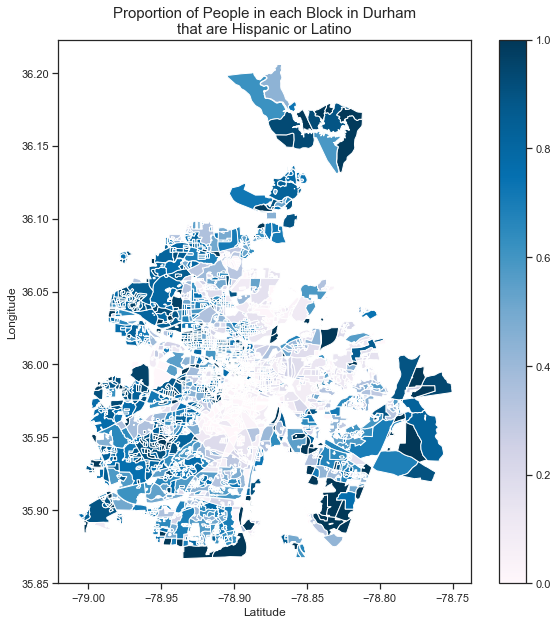

In [808]:
#Plot chloropleth map with merged data
fig, ax = plt.subplots(figsize = (10,10))
racedata2010byblocks.plot(column='propwhite2010',
                                legend=True,
                                cmap="PuBu", ax=ax, aspect=1, edgecolor = 'grey');

# ax.set(title='Number of Calls by Police Beat')
plt.title("Proportion of People in each Block in Durham\nthat are Hispanic or Latino", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [749]:
racedata2000 = pd.read_csv('/Users/erikrobertsson/Documents/dataplus/Race data files/racedata2000/DECENNIALPL2000.PL001_data_with_overlays_2022-07-20T120919.csv', skiprows =1)
racedata2000['GEOID00'] = racedata2000['id'].str[-15:]
racedata2000.drop('id', axis=1, inplace=True)
racedata2000.columns = racedata2000.columns.str.replace('!!', ' ')
racedata2000.drop(racedata2000.iloc[:, 5:72], inplace = True, axis = 1)
racedata2000.columns = racedata2000.columns.str.replace('of one race', 'of')
racedata2000.columns = racedata2000.columns.str.replace(' alone', '')
racedata2000.rename(columns = {'Total':'Total Population 2000'}, inplace = True)
racedata2000.rename(columns = {'Total Population of White':'Total Population of White 2000'}, inplace = True)
racedata2000.rename(columns = {'Total Population of Black or African American':'Total Population of Black or African American 2000'}, inplace = True)
racedata2000.drop('Total Population of', axis=1, inplace=True)
racedata2000

Geographic Area Name  \
0     Block 1000, Block Group 1, Census Tract 1.01, ...   
1     Block 1001, Block Group 1, Census Tract 1.01, ...   
2     Block 1002, Block Group 1, Census Tract 1.01, ...   
3     Block 1003, Block Group 1, Census Tract 1.01, ...   
4     Block 1004, Block Group 1, Census Tract 1.01, ...   
...                                                 ...   
3819  Block 3041, Block Group 3, Census Tract 21, Du...   
3820  Block 3042, Block Group 3, Census Tract 21, Du...   
3821  Block 3043, Block Group 3, Census Tract 21, Du...   
3822  Block 3044, Block Group 3, Census Tract 21, Du...   
3823  Block 3045, Block Group 3, Census Tract 21, Du...   

      Total Population 2000  Total Population of White 2000  \
0                        79                              19   
1                        51                              13   
2                        34                              28   
3                        42                              17   
4                        43                              32   
...                     ...                             ...   
3819                     29                              29   
3820                     98                              92   
3821                     81                              79   
3822                     16                              16   
3823                      0                               0   

      Total Population of Black or African American 2000          GEOID00  
0                                                    60   370630001011000  
1                                                    32   370630001011001  
2                                                     3   370630001011002  
3                                                    20   370630001011003  
4                                                    11   370630001011004  
...                                                 ...               ...  
3819                                                  0   370630021003041  
3820                                                  6   370630021003042  
3821                                                  2   370630021003043  
3822                                                  0   370630021003044  
3823                                                  0   370630021003045  

[3824 rows x 5 columns]

In [828]:
racedata2000byblocks = pd.merge(cblockDurhamBeats2000, racedata2000, left_on ='BLKIDFP00', right_on='GEOID00')
race2000sumbybeat = racedata2000byblocks.groupby('Beat', as_index=False).sum()
race2000sumbybeat['propwhite2000']= race2000sumbybeat['Total Population of White 2000'] / race2000sumbybeat['Total Population 2000']
race2000sumbybeat['propblack2000']= race2000sumbybeat['Total Population of Black or African American 2000'] / race2000sumbybeat['Total Population 2000']
race2000sumbybeat

Beat  Total Population 2000  Total Population of White 2000  \
0    111                   4487                             719   
1    112                   3332                             612   
2    113                   4486                             638   
3    114                   4868                            1312   
4    121                   3749                            2019   
..   ...                    ...                             ...   
32   423                   3132                            2259   
33   511                   2277                            1586   
34   512                    538                              81   
35   513                   1427                             267   
36   999                    220                              47   

    Total Population of Black or African American 2000  propwhite2000  \
0                                                3237        0.160241   
1                                                1912        0.183673   
2                                                3327        0.142220   
3                                                3185        0.269515   
4                                                1577        0.538544   
..                                                ...             ...   
32                                                637        0.721264   
33                                                332        0.696531   
34                                                422        0.150558   
35                                                995        0.187106   
36                                                169        0.213636   

    propblack2000  
0        0.721417  
1        0.573830  
2        0.741641  
3        0.654273  
4        0.420646  
..            ...  
32       0.203384  
33       0.145806  
34       0.784387  
35       0.697267  
36       0.768182  

[37 rows x 6 columns]

In [1097]:
racedatacombined = pd.merge(race2020sumbybeat, race2010sumbybeat, on ='Beat')
racedatacombined = pd.merge(racedatacombined, race2000sumbybeat, on ='Beat')
racedatacombined = pd.merge(policebeats, racedatacombined, left_on ='LAWBEAT', right_on = 'Beat')
racedatacombined.rename(columns = {'Total Population':'Total Population 2020'}, inplace = True)
racedatacombined.sort_values(by='Total Population 2020', inplace=True, ascending=False)
racedatacombined

LAWBEAT                                           geometry  OBJECTID  \
22      322  POLYGON ((-78.94765 35.95837, -78.94637 35.958...        87   
32      423  MULTIPOLYGON (((-78.83466 35.94599, -78.83463 ...        95   
7       124  MULTIPOLYGON (((-78.77636 35.92139, -78.77722 ...        63   
30      421  POLYGON ((-78.90852 35.93573, -78.90823 35.935...        99   
19      313  POLYGON ((-78.98695 36.02959, -78.98696 36.029...        39   
..      ...                                                ...       ...   
1       112  POLYGON ((-78.88787 36.01473, -78.88734 36.014...        51   
35      513  POLYGON ((-78.89561 35.99710, -78.89553 35.997...        61   
34      512  POLYGON ((-78.90313 36.00376, -78.90298 36.003...        57   
16      299  MULTIPOLYGON (((-78.86038 36.15712, -78.86107 ...         1   
36      999  MULTIPOLYGON (((-78.94297 35.89150, -78.94296 ...         4   

        PERIMETER STATUS CONTIGUOUS LAWDIST  CAD GIS_DataA1    ShapeSTAre  \
22   60429.371094      I        yes      D3  322       None  1.639988e+08   
32  151917.093750      I        yes      D4  423       None  2.561465e+08   
7    10708.070312      I         no      D1  124       None  3.022588e+06   
30   58692.320312      I        yes      D4  421       None  1.180636e+08   
19   57403.839844      I        yes      D3  313       None  6.812116e+07   
..            ...    ...        ...     ...  ...        ...           ...   
1    26265.849609      I        yes      D1  112       None  2.079934e+07   
35   20647.179688      I        yes      D5  513       None  9.114313e+06   
34   16338.889648      I        yes      D5  512       None  9.305014e+06   
16   29657.869141   None       None      D2  SSA       None  2.075708e+07   
36    1308.963013   None       None     DSO  DSO       None  6.932677e+04   

       ShapeSTLen  Beat_x  id  Beat_y   ALAND20  AWATER20  \
22   60429.372056     322  22     322  15676836     26434   
32  151917.121852     423  32     423  25160283    240192   
7    10708.070450     124   7     124  32035320    303409   
30   58692.323104     421  30     421  10243290    118655   
19   57403.841356     313  19     313   6394389     17244   
..            ...     ...  ..     ...       ...       ...   
1    26265.852604     112   1     112   1863048         0   
35   20647.175971     513  35     513    797193         0   
34   16338.888321     512  34     512    882799         0   
16   29657.868615     299  16     299  20342184   2127232   
36    1308.962953     999  36     999   2187405     14257   

    Total Population 2020  Total Population of White alone  \
22                  15927                            10592   
32                  15092                             6642   
7                   14913                             7361   
30                  13874                             5987   
19                  12372                             5005   
..                    ...                              ...   
1                    3083                              454   
35                   1677                              405   
34                   1646                             1076   
16                    540                              468   
36                    194                               86   

    Total Population of Black or African American alone  propwhite2020  \
22                                               2893         0.665034   
32                                               4553         0.440101   
7                                                5032         0.493596   
30                                               5085         0.431527   
19                                               3001         0.404543   
..                                                ...              ...   
1                                                1276         0.147259   
35                                               1003         0.241503   
34                    

In [856]:
# save all the maps in the charts folder
output_path = "/Users/erikrobertsson/Documents/dataplus/maps"

# counter for the for loop
i = 0

# list of years (which are the column names at the moment)
list_of_years = ['propblack2020','propblack2010','propblack2000']


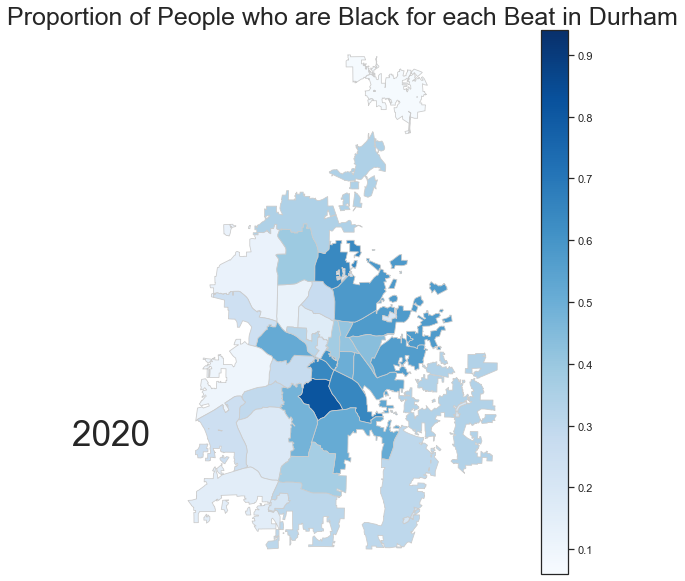

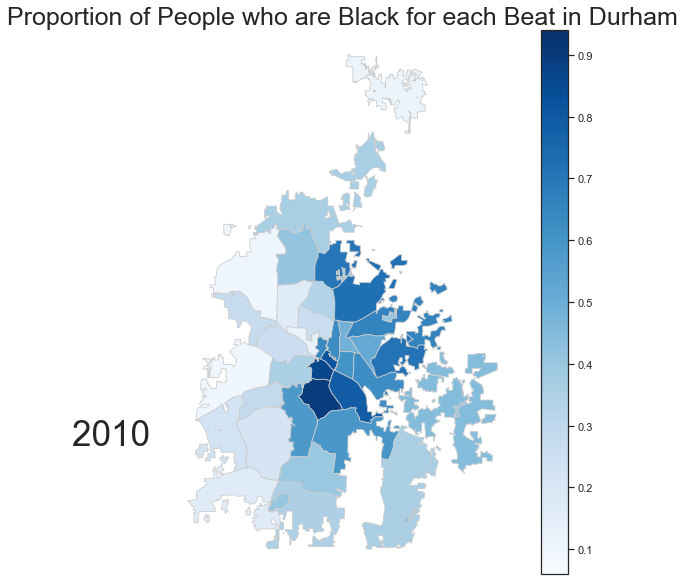

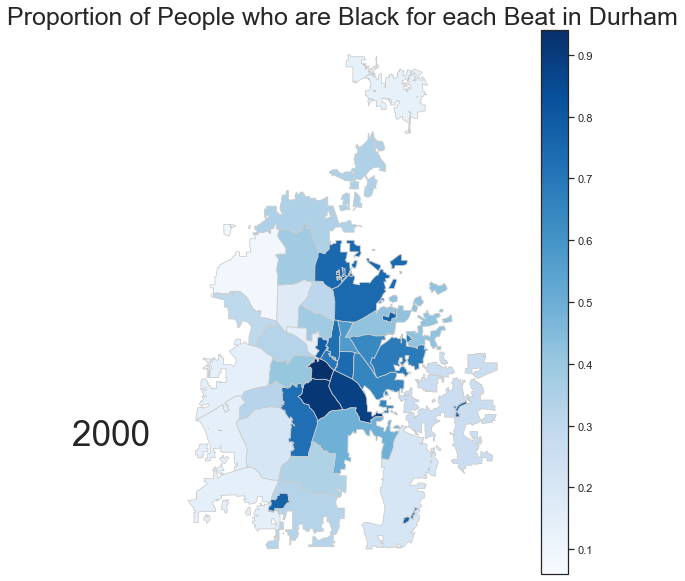

In [857]:
# set the min and max range for the choropleth map
vmin, vmax = 0.06, 0.94

# start the for loop to create one map per year
for year in list_of_years:
    
    # create map, UDPATE: added plt.Normalize to keep the legend range the same for all maps
    fig = racedatacombined.plot(column=year, cmap='Blues', figsize=(10,10), linewidth=0.8, edgecolor='0.8', vmin=vmin, vmax=vmax,
legend=True, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    
    # remove axis of chart
    fig.axis('off')
    
    # add a title
    fig.set_title('Proportion of People who are Black for each Beat in Durham', \
              fontdict={'fontsize': '25',
                         'fontweight' : '3'})
    
    # create an annotation for the year by grabbing the first 4 digits
    only_year = year[-4:]
    # position the annotation to the bottom left
    fig.annotate(only_year,
            xy=(0.1, .225), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=35)
    
    # this will save the figure as a high-res png in the output path. you can also save as svg if you prefer.
    filepath = os.path.join(output_path, only_year+'_propblack.jpg')
    chart = fig.get_figure()
    chart.savefig(filepath, dpi=300)    

In [1098]:
# save all the maps in the charts folder
output_path = "/Users/erikrobertsson/Documents/dataplus/maps"

# counter for the for loop
i = 0

# list of years (which are the column names at the moment)
list_of_years = ['Total Population 2020','Total Population 2010','Total Population 2000']


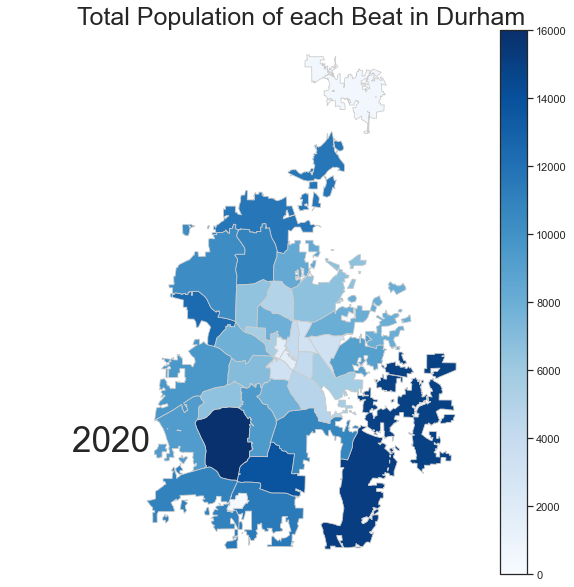

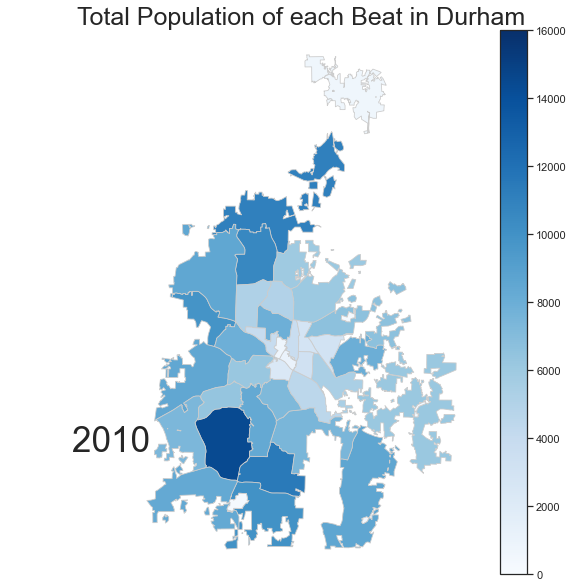

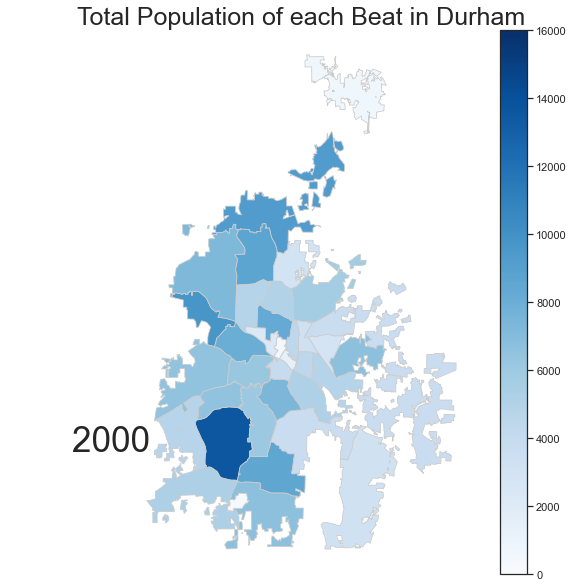

In [1099]:
# set the min and max range for the choropleth map
vmin, vmax = 0, 16000

# start the for loop to create one map per year
for year in list_of_years:
    
    # create map, UDPATE: added plt.Normalize to keep the legend range the same for all maps
    fig = racedatacombined.plot(column=year, cmap='Blues', figsize=(10,10), linewidth=0.8, edgecolor='0.8', vmin=vmin, vmax=vmax,
legend=True, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    
    # remove axis of chart
    fig.axis('off')
    
    # add a title
    fig.set_title('Total Population of each Beat in Durham', \
              fontdict={'fontsize': '25',
                         'fontweight' : '3'})
    
    # create an annotation for the year by grabbing the first 4 digits
    only_year = year[-4:]
    # position the annotation to the bottom left
    fig.annotate(only_year,
            xy=(0.1, .225), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=35)
    
    # this will save the figure as a high-res png in the output path. you can also save as svg if you prefer.
    filepath = os.path.join(output_path, only_year+'_totalpop.jpg')
    chart = fig.get_figure()
    chart.savefig(filepath, dpi=300)    

end of race

In [751]:
beats_callcount_pop_income_householdtype_race_age = pd.merge(beats_callcount_pop_age_householdtype_race, incomesumbybeat, left_on ='LAWBEAT', right_on='Beat')
#beats_callcount_pop_income_householdtype_race_age_correl = beats_callcount_pop_income_householdtype_race_age.dropna()
beats_callcount_pop_income_householdtype_race_age['callcountperarea']= beats_callcount_pop_income_householdtype_race_age['calls_count'] / beats_callcount_pop_income_householdtype_race_age['area']
beats_callcount_pop_income_householdtype_race_age['propmiddleincome']= beats_callcount_pop_income_householdtype_race_age['prop50to75'] + beats_callcount_pop_income_householdtype_race_age['prop75to100']
beats_callcount_pop_income_householdtype_race_age['propadultsandboomers']= beats_callcount_pop_income_householdtype_race_age['propadults'] + beats_callcount_pop_income_householdtype_race_age['propboomers']
beats_callcount_pop_income_householdtype_race_age['propyouthandchildren']= beats_callcount_pop_income_householdtype_race_age['propyouth'] + beats_callcount_pop_income_householdtype_race_age['propchildren']
beats_callcount_pop_income_householdtype_race_age['propboomersandseniors']= beats_callcount_pop_income_householdtype_race_age['propseniors'] + beats_callcount_pop_income_householdtype_race_age['propboomers']
beats_callcount_pop_income_householdtype_race_age['avghouseholdsize']= beats_callcount_pop_income_householdtype_race_age['Total Population'] / beats_callcount_pop_income_householdtype_race_age['Total Households_y']
beats_callcount_pop_income_householdtype_race_age.drop(['OBJECTID', 'index_right', 'Cancelled', 'ALAND20', 'AWATER20', 'index_right', 'Event Numb'], axis=1, inplace=True)

start of poverty level

In [752]:
povertydata = pd.read_csv('/Users/erikrobertsson/Documents/dataplus/povertyleveldata2/ACSDT5Y2020.B17017_data_with_overlays_2022-07-01T121722.csv', skiprows =1)
povertydata['GEOID'] = povertydata['id'].str[-12:]
povertydata.drop('id', axis=1, inplace=True)
povertydata = povertydata.drop(povertydata.filter(regex='Margin').columns, axis=1)
povertydata = povertydata.drop(povertydata.filter(regex='Estimate!!Total:!!Income in the past 12 months below poverty level:!!Family households:!!').columns, axis=1)
povertydata = povertydata.drop(povertydata.filter(regex='Estimate!!Total:!!Income in the past 12 months below poverty level:!!Nonfamily households:!!').columns, axis=1)
povertydata = povertydata.drop(povertydata.filter(regex='Estimate!!Total:!!Income in the past 12 months at or above poverty level:!!Family households:!!').columns, axis=1)
povertydata = povertydata.drop(povertydata.filter(regex='Estimate!!Total:!!Income in the past 12 months at or above poverty level:!!Nonfamily households:!!').columns, axis=1)
povertydata.rename(columns=lambda s: s.replace("Estimate!!Total:!!Income in the past 12 months", "Total People"), inplace=True)
povertydata.rename(columns=lambda s: s.replace(":!!", " "), inplace=True)
povertydata.rename(columns=lambda s: s.replace(":", ""), inplace=True)
povertydata.rename(columns = {'Estimate!!Total':'Total People'}, inplace = True)
povertydata = povertydata[['GEOID', 'Geographic Area Name', 'Total People', 'Total People below poverty level', 'Total People below poverty level Family households', 'Total People below poverty level Nonfamily households', 'Total People at or above poverty level','Total People at or above poverty level Family households', 'Total People at or above poverty level Nonfamily households',]]
povertydata.head(2)

GEOID                               Geographic Area Name  \
0  370630001011  Block Group 1, Census Tract 1.01, Durham Count...   
1  370630001012  Block Group 2, Census Tract 1.01, Durham Count...   

   Total People  Total People below poverty level  \
0           563                                57   
1           859                               105   

   Total People below poverty level Family households  \
0                                                 36    
1                                                 67    

   Total People below poverty level Nonfamily households  \
0                                                 21       
1                                                 38       

   Total People at or above poverty level  \
0                                     506   
1                                     754   

   Total People at or above poverty level Family households  \
0                                                214          
1                                                552          

   Total People at or above poverty level Nonfamily households  
0                                                292            
1                                                202

In [753]:
povertydataindurhambyblocks = pd.merge(cblockDurhamBeatsbg, povertydata, left_on ='GEOID', right_on='GEOID')
povertydataindurhambyblocks.drop(['MTFCC', 'COUNTYFP','NAMELSAD', 'FUNCSTAT', 'ALAND', 'AWATER', 'TRACTCE', 'STATEFP', 'BLKGRPCE'], axis=1, inplace=True)
povertydataindurhambyblocks.head(2)

GEOID     INTPTLAT      INTPTLON  \
0  370630020191  +35.9028449  -078.9763172   
1  370630020201  +35.8836714  -078.9598590   

                                            geometry  Beat  \
0  POLYGON ((-78.98415 35.91174, -78.98394 35.911...   324   
1  POLYGON ((-78.97849 35.86682, -78.97764 35.867...   324   

                                Geographic Area Name  Total People  \
0  Block Group 1, Census Tract 20.19, Durham Coun...           943   
1  Block Group 1, Census Tract 20.20, Durham Coun...           862   

   Total People below poverty level  \
0                                65   
1                                 0   

   Total People below poverty level Family households  \
0                                                  0    
1                                                  0    

   Total People below poverty level Nonfamily households  \
0                                                 65       
1                                                  0       

   Total People at or above poverty level  \
0                                     878   
1                                     862   

   Total People at or above poverty level Family households  \
0                                                267          
1                                                671          

   Total People at or above poverty level Nonfamily households  
0                                                611            
1                                                191

In [754]:
povertysumbybeat = povertydataindurhambyblocks.groupby('Beat', as_index=False).sum()
povertysumbybeat.rename(columns = {'Beat':'LAWBEAT'}, inplace = True)
povertysumbybeat['propbelowpov']= povertysumbybeat['Total People below poverty level'] / povertysumbybeat['Total People']
povertysumbybeat['propabovepov']= povertysumbybeat['Total People at or above poverty level'] / povertysumbybeat['Total People']
povertysumbybeat = povertysumbybeat[['Total People', 'Total People below poverty level', 'Total People below poverty level Family households', 'Total People below poverty level Nonfamily households', 'Total People at or above poverty level','Total People at or above poverty level Family households', 'Total People at or above poverty level Nonfamily households', 'LAWBEAT', 'propbelowpov', 'propabovepov']]
povertysumbybeat.sort_values(by='propbelowpov', inplace=True, ascending=False)

In [755]:
commsafe_list = [511, 512, 513, 411, 113, 112, 214, 223]
povertysumbybeatcommsafe = povertysumbybeat.loc[povertysumbybeat['LAWBEAT'].isin(commsafe_list)].copy()
povertysumbybeatcommsafe

Total People  Total People below poverty level  \
1           1152                               468   
14           385                               135   
2           1339                               366   
31           898                               231   
32           731                               180   
23          1052                               246   
11          2555                               279   
33           244                                21   

    Total People below poverty level Family households  \
1                                                 321    
14                                                 16    
2                                                 150    
31                                                  0    
32                                                  0    
23                                                 58    
11                                                201    
33                                                 13    

    Total People below poverty level Nonfamily households  \
1                                                 147       
14                                                119       
2                                                 216       
31                                                231       
32                                                180       
23                                                188       
11                                                 78       
33                                                  8       

    Total People at or above poverty level  \
1                                      684   
14                                     250   
2                                      973   
31                                     667   
32                                     551   
23                                     806   
11                                    2276   
33                                     223   

    Total People at or above poverty level Family households  \
1                                                 358          
14                                                222          
2                                                 580          
31                                                107          
32                                                 77          
23                                                489          
11                                               1307          
33                                                 74          

    Total People at or above poverty level Nonfamily households  LAWBEAT  \
1                                                 326                112   
14                                                 28                223   
2                                                 393                113   
31                                                560                511   
32                                                474                512   
23                                                317                411   
11                                                969                214   
33                                                149                513   

    propbelowpov  propabovepov  
1       0.406250      0.593750  
14      0.350649      0.649351  
2       0.273338      0.726662  
31      0.257238      0.742762  
32      0.246238      0.753762  
23      0.233840      0.766160  
11      0.109198      0.890802  
33      0.086066      0.913934

In [756]:
meanpropbelowpov = povertysumbybeat[["propbelowpov"]].mean()
meanpropbelowpov

propbelowpov    0.175052
dtype: float64

In [757]:
meanpropbelowpovcommsafe = povertysumbybeatcommsafe[["propbelowpov"]].mean()
meanpropbelowpovcommsafe

propbelowpov    0.245352
dtype: float64

In [758]:
povertydata['Total People'].sum()

130128

In [759]:
mappingdatasetpoverty = pd.merge(policebeats, povertysumbybeat, on ='LAWBEAT')

In [760]:
commsafe_list = [511, 512, 513, 411, 113, 112, 214, 223]
mappingdatasetpovertycommsafe = mappingdatasetpoverty.loc[mappingdatasetpoverty['LAWBEAT'].isin(commsafe_list)].copy()

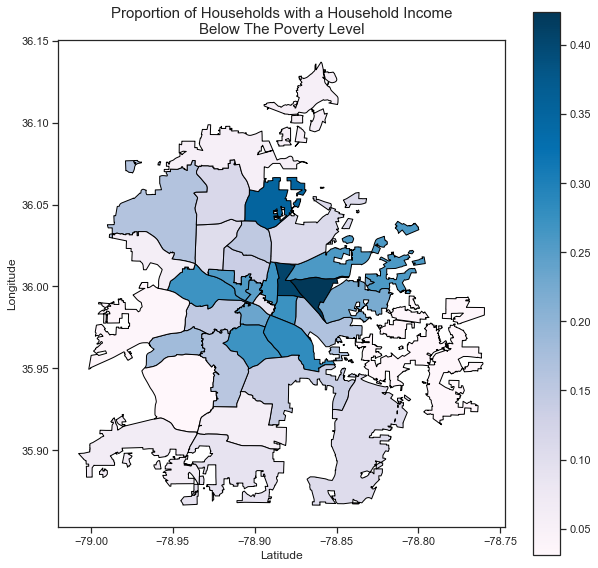

In [761]:
#Plot chloropleth map with merged data
fig, ax = plt.subplots(figsize = (10,10))
mappingdatasetpoverty.plot(column='propbelowpov',
                                legend=True,
                                cmap="PuBu", ax=ax, aspect=1, edgecolor = 'black');

# ax.set(title='Number of Calls by Police Beat')
plt.title("Proportion of Households with a Household Income\nBelow The Poverty Level", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

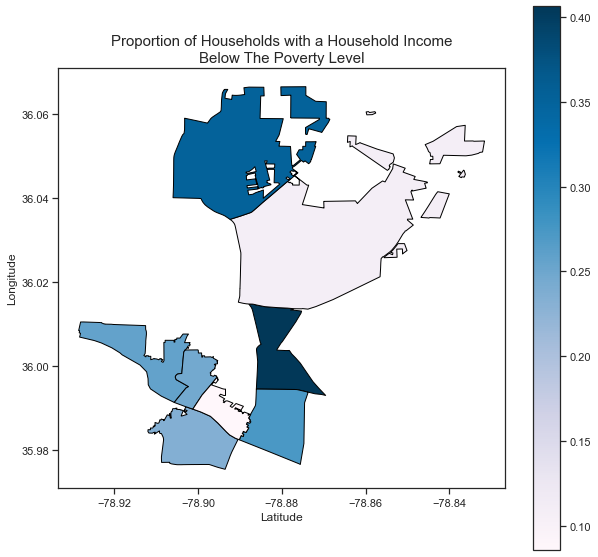

In [762]:
#Plot chloropleth map with merged data
fig, ax = plt.subplots(figsize = (10,10))
mappingdatasetpovertycommsafe.plot(column='propbelowpov',
                                legend=True,
                                cmap="PuBu", ax=ax, aspect=1, edgecolor = 'black');

# ax.set(title='Number of Calls by Police Beat')
plt.title("Proportion of Households with a Household Income\nBelow The Poverty Level", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [763]:
beats_callcount_pop_income_householdtype_race_age_poverty = pd.merge(beats_callcount_pop_income_householdtype_race_age, povertysumbybeat, on ='LAWBEAT')
stats.pearsonr(beats_callcount_pop_income_householdtype_race_age_poverty['propbelowpov'], beats_callcount_pop_income_householdtype_race_age_poverty['callcountperperson'])


(0.3036831343853139, 0.08080579810559438)

In [764]:
beats_callcount_pop_income_householdtype_race_age_poverty.corr()

LAWBEAT  PERIMETER  \
LAWBEAT                                             1.000000   0.251473   
PERIMETER                                           0.251473   1.000000   
ShapeSTAre                                          0.258477   0.887787   
ShapeSTLen                                          0.251473   1.000000   
Beat_left                                           1.000000   0.251473   
...                                                      ...        ...   
Total People at or above poverty level             -0.011876   0.317488   
Total People at or above poverty level Family h... -0.097813   0.256323   
Total People at or above poverty level Nonfamil...  0.115912   0.333640   
propbelowpov                                       -0.237271  -0.456370   
propabovepov                                        0.237271   0.456370   

                                                    ShapeSTAre  ShapeSTLen  \
LAWBEAT                                               0.258477    0.251473   
PERIMETER                                             0.887787    1.000000   
ShapeSTAre                                            1.000000    0.887787   
ShapeSTLen                                            0.887787    1.000000   
Beat_left                                             0.258477    0.251473   
...                                                        ...         ...   
Total People at or above poverty level                0.353579    0.317488   
Total People at or above poverty level Family h...    0.270103    0.256323   
Total People at or above poverty level Nonfamil...    0.393917    0.333640   
propbelowpov                                         -0.471216   -0.456370   
propabovepov                                          0.471216    0.456370   

                                                    Beat_left        id  \
LAWBEAT                                              1.000000  0.983522   
PERIMETER                                            0.251473  0.354215   
ShapeSTAre                                           0.258477  0.347640   
ShapeSTLen                                           0.251473  0.354215   
Beat_left                                            1.000000  0.983522   
...                                                       ...       ...   
Total People at or above poverty level              -0.011876  0.064631   
Total People at or above poverty level Family h...  -0.097813 -0.000554   
Total People at or above poverty level Nonfamil...   0.115912  0.144662   
propbelowpov                                        -0.237271 -0.306205   
propabovepov                                         0.237271  0.306205   

                                                           X         Y  \
LAWBEAT                                            -0.317174 -0.430304   
PERIMETER                                          -0.258072 -0.500759   
ShapeSTAre                                         -0.312554 -0.503036   
ShapeSTLen                                         -0.258072 -0.500759   
Beat_left                                          -0.317174 -0.430304   
...                                                      ...       ...   
Total People at or above poverty level             -0.214034 -0.242611   
Total People at or above poverty level Family h... -0.061527 -0.277046   
Total People at or above poverty level Nonfamil... -0.386857 -0.136823   
propbelowpov                                        0.276179  0.276898   
propabovepov                                       -0.276179 -0.276898   

                                                    calls_count      area  \
LAWBEAT                                                0.157321 -0.035038   
PERIMETER                                             -0.010110  0.633446   
ShapeSTAre                                             0.077159  0.662759   
ShapeSTLen                                            -0.010110  0.633446   
Beat_left                               

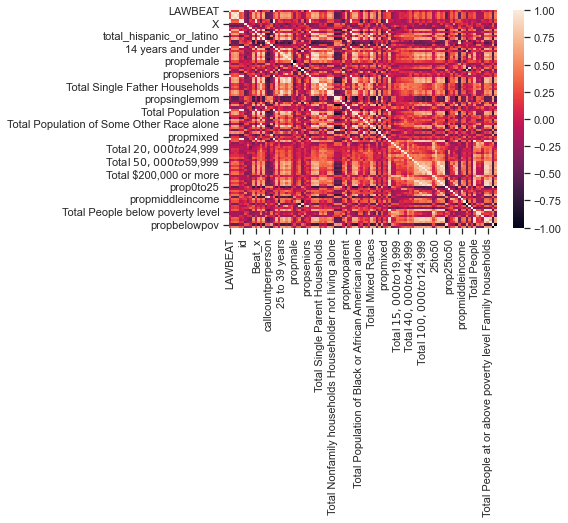

In [765]:
sns.heatmap(beats_callcount_pop_income_householdtype_race_age_poverty.corr());

In [958]:
beats_callcount_pop_income_householdtype_race_age_poverty2 = beats_callcount_pop_income_householdtype_race_age_poverty.copy()
beats_callcount_pop_income_householdtype_race_age_poverty2 = beats_callcount_pop_income_householdtype_race_age_poverty2.loc[(beats_callcount_pop_income_householdtype_race_age_poverty2["LAWBEAT"] != 512) & (beats_callcount_pop_income_householdtype_race_age_poverty2["LAWBEAT"] != 513)]
beats_callcount_pop_income_householdtype_race_age_poverty2['0to10']= beats_callcount_pop_income_householdtype_race_age_poverty2['Total Less than $10,000']
beats_callcount_pop_income_householdtype_race_age_poverty2['prop0to10']= beats_callcount_pop_income_householdtype_race_age_poverty2['0to10'] / beats_callcount_pop_income_householdtype_race_age_poverty2['Total Households_y']
beats_callcount_pop_income_householdtype_race_age_poverty2['prop200plus']= beats_callcount_pop_income_householdtype_race_age_poverty2['Total $200,000 or more'] / beats_callcount_pop_income_householdtype_race_age_poverty2['Total Households_y']
beats_callcount_pop_income_householdtype_race_age_poverty2

LAWBEAT      PERIMETER    ShapeSTAre     ShapeSTLen  Beat_left    id  \
0       111   28608.800781  2.010252e+07   28608.799743      111.0   0.0   
1       112   26265.849609  2.079934e+07   26265.852604      112.0   1.0   
2       113   20667.539062  2.159195e+07   20667.538873      113.0   2.0   
3       114   53321.980469  6.103382e+07   53321.974873      114.0   3.0   
4       121   14495.120117  7.008533e+06   14495.120026      121.0   4.0   
..      ...            ...           ...            ...        ...   ...   
27      415   60313.781250  8.843634e+07   60313.778960      415.0  29.0   
28      421   58692.320312  1.180636e+08   58692.323104      421.0  30.0   
29      422  119968.398438  1.364002e+08  119968.366828      422.0  31.0   
30      423  151917.093750  2.561465e+08  151917.121852      423.0  32.0   
31      511   32615.019531  2.129644e+07   32615.017763      511.0  33.0   

               X              Y  calls_count      area  Beat_x  total  \
0   2.032588e+06  817220.396277        376.0  0.000187     111   3949   
1   2.035117e+06  818966.142466        365.0  0.000193     112   3083   
2   2.034771e+06  814367.727660        470.0  0.000200     113   4094   
3   2.039702e+06  812959.107872        343.0  0.000616     114   5631   
4   2.044614e+06  823994.272031        261.0  0.001061     121   8025   
..           ...            ...          ...       ...     ...    ...   
27  2.024547e+06  800455.631436        369.0  0.000821     415   9436   
28  2.027401e+06  786704.941385        563.0  0.001095     421  13874   
29  2.028308e+06  781517.957721        544.0  0.001344     422  11497   
30  2.048046e+06  782717.906690        568.0  0.002382     423  15092   
31  2.025700e+06  819510.860412        437.0  0.000198     511   5505   

    total_hispanic_or_latino  total_not_hispanic_or_latino    popdensity  \
0                       1130                          2819  2.115229e+07   
1                       1366                          1717  1.595999e+07   
2                       1038                          3056  2.041984e+07   
3                       1756                          3875  9.142323e+06   
4                       1803                          6222  7.560240e+06   
..                       ...                           ...           ...   
27                      1535                          7901  1.149595e+07   
28                      1503                         12371  1.266629e+07   
29                      1068                         10429  8.553777e+06   
30                      1231                         13861  6.336461e+06   
31                       385                          5120  2.783313e+07   

    callcountperperson  prophisp  Beat_y  14 years and under  15 to 24 years  \
0             0.095214  0.286148     111                 843             562   
1             0.118391  0.443075     112                 706             408   
2             0.114802  0.253542     113                 770             509   
3             0.060913  0.311845     114                1372             799   
4             0.032523  0.224673     121                1845             852   
..                 ...       ...     ...                 ...             ...   
27            0.039106  0.162675     415                1688             902   
28            0.040580  0.108332     421                1969            1571   
29            0.047317  0.092894     422                2283             947   
30            0.037636  0.081566     423                1587             974   
31            0.079382  0.069936     511                  92            2320   

    25 to 39 years  40 to 64 years  65 years and over  popcount2010  \
0              943            1147                291          3786   
1              720             810                184          2828   
2              730             997                183          3189   
3             1314            1552                389   

In [1065]:
stats.pearsonr(beats_callcount_pop_income_householdtype_race_age_poverty2['callcountperperson'], beats_callcount_pop_income_householdtype_race_age_poverty2['propsinglefather'])


(0.7322287770237662, 1.903589111533191e-06)

In [ ]:
0.5861068508924008 propsingleparent
0.6045643650791429 prop0to25
0.6152574043262676 propbelowpov
0.7322287770237662 propsinglefather


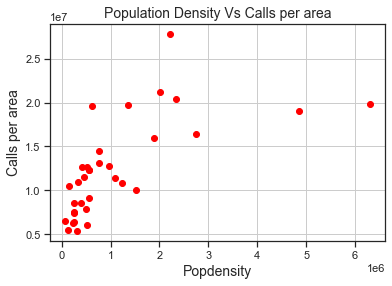

In [867]:
plt.scatter(beats_callcount_pop_income_householdtype_race_age_poverty['callcountperarea'], beats_callcount_pop_income_householdtype_race_age_poverty['popdensity'], color='red')
plt.title('Population Density Vs Calls per area', fontsize=14)
plt.xlabel('Popdensity', fontsize=14)
plt.ylabel('Calls per area', fontsize=14)
plt.grid(True)
plt.show()

In [1069]:
X = beats_callcount_pop_income_householdtype_race_age_poverty2[['propsingleparent', 'propmale', 'prop0to10']] # here we have 2 variables for multiple regression
Y = beats_callcount_pop_income_householdtype_race_age_poverty2['callcountperperson']

regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 -0.23712634665675406
Coefficients: 
 [0.06867255 0.53194992 0.21318662]


In [914]:
New_Prop_20to50 = 0.2
New_Prop_100plus = 0.2
New_Prop_Singlemom = 0.4
New_Prop_Male = 0.5
print ('Predicted Call Count Per Person: \n', regr.predict([[New_Prop_20to50, New_Prop_100plus, New_Prop_Singlemom, New_Prop_Male]]))

ValueError: X has 4 features, but LinearRegression is expecting 11 features as input.

In [1070]:
X = sm.add_constant(X) # adding a constant
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:     callcountperperson   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     11.64
Date:                Fri, 22 Jul 2022   Prob (F-statistic):           3.96e-05
Time:                        12:46:44   Log-Likelihood:                 72.364
No. Observations:                  32   AIC:                            -136.7
Df Residuals:                      28   BIC:                            -130.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.2371      0.089  

We expect that, on avagerage, a one unit increase in prop of poor homeowners will cause a 0.0251 increase in call count per person.

The y-intercept has no meaning because there cannot be negative calls per person.

In [976]:
model.rsquared_adj

0.5073061465472413

This adjusted R-squared value tells us that roughly 74.87% of the variability in call count per person can be explained by the proportion of low income homeowners and the proportion of the single parents households in a beat. Since this R-squared value is (not) closer to 1 than the r-squared value for the other model (), this new model is a better fit for the data.

In [1066]:
df = pd.DataFrame(beats_callcount_pop_income_householdtype_race_age_poverty2)

X = beats_callcount_pop_income_householdtype_race_age_poverty2[['prop0to10', 'propmale', 'propsingleparent']]
Y = beats_callcount_pop_income_householdtype_race_age_poverty2['callcountperperson']

regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

root= tk.Tk()

canvas1 = tk.Canvas(root, width = 500, height = 400)
canvas1.pack()

Intercept_result = ('Intercept: ', regr.intercept_)
label_Intercept = tk.Label(root, text=Intercept_result, justify = 'center')
canvas1.create_window(260, 250, window=label_Intercept)

Coefficients_result  = ('Coefficients: ', regr.coef_)
label_Coefficients = tk.Label(root, text=Coefficients_result, justify = 'center')
canvas1.create_window(260, 270, window=label_Coefficients)

label1 = tk.Label(root, text=' Type Proportion of Household Incomes Between $0 and $10,000: ')
canvas1.create_window(-32, 100, window=label1)

entry1 = tk.Entry (root) # create 1st entry box
canvas1.create_window(270, 100, window=entry1)

label2 = tk.Label(root, text=' Type Proportion of Population That is Male: ')
canvas1.create_window(37, 130, window=label2)

entry2 = tk.Entry (root) # create 2nd entry box
canvas1.create_window(270, 130, window=entry2)

label3 = tk.Label(root, text=' Type Proportion of Family Households that are Single Parent: ')
canvas1.create_window(-15, 160, window=label3)

entry3 = tk.Entry (root) # create 3rd entry box
canvas1.create_window(270, 160, window=entry3)

def values(): 
    global New_Prop_0to10 #our 1st input variable
    New_Prop_0to10 = float(entry1.get()) 
    
    global New_Prop_Male #our 2nd input variable
    New_Prop_Male = float(entry2.get()) 
    
    global New_Prop_Singleparent #our 3rd input variable
    New_Prop_Singleparent = float(entry3.get()) 

    
    Prediction_result  = ('Predicted Call Count Per Person: ', regr.predict([[New_Prop_0to10 ,New_Prop_Male ,New_Prop_Singleparent]]))
    label_Prediction = tk.Label(root, text= Prediction_result, bg='orange')
    canvas1.create_window(260, 320, window=label_Prediction)
    
button1 = tk.Button (root, text='Predicted Call Count Per Person',command=values, bg='orange') # button to call the 'values' command above 
canvas1.create_window(270, 220, window=button1)

#plot 1st scatter 
figure3 = plt.Figure(figsize=(5.5,4), dpi=100)
ax3 = figure3.add_subplot(111)
ax3.scatter(df['prop0to10'].astype(float),df['callcountperperson'].astype(float), color = 'purple')
scatter3 = FigureCanvasTkAgg(figure3, root) 
scatter3.get_tk_widget().pack(side=tk.RIGHT, fill=tk.BOTH)
X = beats_callcount_pop_income_householdtype_race_age_poverty2['prop0to10']
Y = beats_callcount_pop_income_householdtype_race_age_poverty2['callcountperperson']
p1 = polyfit(X,Y,1)
ax3.plot(X,Y,'o', color = 'purple')
ax3.plot(X,polyval(p1,X), 'r-', color = 'r')
ax3.legend(['callcountperperson'])
ax3.set_xlabel('prop0to10')
ax3.set_title('Prop of Household Incomes Less Than $10,000 Vs. Calls Per Person')
ax3.grid(True)

#plot 3rd scatter 
figure5 = plt.Figure(figsize=(5.5,4), dpi=100)
ax5 = figure5.add_subplot(111)
ax5.scatter(df['propsingleparent'].astype(float),df['callcountperperson'].astype(float), color = 'b')
scatter5 = FigureCanvasTkAgg(figure5, root) 
scatter5.get_tk_widget().pack(side=tk.RIGHT, fill=tk.BOTH)
X = beats_callcount_pop_income_householdtype_race_age_poverty2['propsingleparent']
Y = beats_callcount_pop_income_householdtype_race_age_poverty2['callcountperperson']
p1 = polyfit(X,Y,1)
ax5.plot(X,Y,'o', color = 'b')
ax5.plot(X,polyval(p1,X), 'r-', color = 'r')
ax5.legend(['callcountperperson']) 
ax5.set_xlabel('propsingleparent')
ax5.set_title('Prop of Households That Are Single Parent Vs. Calls Per Person')
ax5.grid(True)

#plot 4th scatter 
figure6 = plt.Figure(figsize=(5.5,4), dpi=100)
ax6 = figure6.add_subplot(111)
ax6.scatter(df['propmale'].astype(float),df['callcountperperson'].astype(float), color = 'y')
scatter6 = FigureCanvasTkAgg(figure6, root) 
scatter6.get_tk_widget().pack(side=tk.RIGHT, fill=tk.BOTH)
X = beats_callcount_pop_income_householdtype_race_age_poverty2['propmale']
Y = beats_callcount_pop_income_householdtype_race_age_poverty2['callcountperperson']
p1 = polyfit(X,Y,1)
ax6.plot(X,Y,'o', color = 'y')
ax6.plot(X,polyval(p1,X), 'r-', color = 'r')
ax6.legend(['callcountperperson']) 
ax6.set_xlabel('propmale')
ax6.set_ylabel('callcountperperson')
ax6.set_title('Prop of Population That is Male Vs. Calls Per Person')
ax6.grid(True)

root.mainloop()

Intercept: 
 -0.23712634665675406
Coefficients: 
 [0.21318662 0.53194992 0.06867255]


In [1067]:
X = beats_callcount_pop_income_householdtype_race_age['propmale'] # here we have 2 variables for multiple regression. If you just want to use one variable for simple linear regression, then use X = df['Interest_Rate'] for example.Alternatively, you may add additional variables within the brackets
Y = beats_callcount_pop_income_householdtype_race_age['callcountperperson']
p1 = polyfit(X,Y,1)
print(p1)

[ 0.5554897  -0.19455542]


Text(0, 0.5, 'Calls per person')

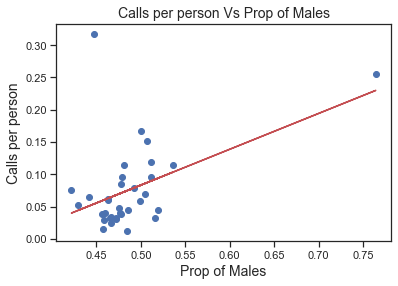

In [781]:
#displaying the linear regression model
X = beats_callcount_pop_income_householdtype_race_age['propmale'] # here wehave 2 variables for multiple regression. 
Y = beats_callcount_pop_income_householdtype_race_age['callcountperperson']
p1 = polyfit(X,Y,1)
plt.plot(X,Y,'o')
plt.plot(X,polyval(p1,X), 'r-')
plt.title('Calls per person Vs Prop of Males', fontsize=14)
plt.xlabel('Prop of Males', fontsize=14)
plt.ylabel('Calls per person', fontsize=14)

In [782]:
#quadratic and cubic regression
p2 = polyfit(X,Y,2)
p3 = polyfit(X,Y,3)

In [783]:
#predicted y values based on linear regression model
yfit = p1[0] * X + p1[1]
print(yfit)

0     0.089352
1     0.089475
2     0.103482
3     0.062612
4     0.063630
        ...   
29    0.069510
30    0.070587
31    0.078871
32    0.230018
33    0.053663
Name: propmale, Length: 34, dtype: float64


In [784]:
#r squared calculation
yresid = Y - yfit
SSresid = sum(pow(yresid,2))
SStotal = len(Y) * var(Y)
rsq = 1 - SSresid/SStotal
print(rsq)

0.22045025894046555


In [785]:
#r squared value
from scipy.stats import *
slope,intercept,r_value,p_value,std_err = linregress(X,Y)
print(pow(r_value,2))

0.22045025894046583


In [786]:
#p-value
print(p_value)

0.005086880460720428


pwd
cd Documents/dataplus/dataplus-project27-community-safety-durham/
git status
git add .
git status
git commit -m 'your commit message'
git pull
git push

start looking at commsafe specific type of calls

In [787]:
callspernature = dpdcalls.groupby( ["Nature"] ).size().to_frame(name = 'dpdcalls_count').reset_index()
callspernature.sort_values(by='dpdcalls_count', inplace=True, ascending=False)
callspernature

Nature  dpdcalls_count
6     TRESPASS OR UNWANTED            4941
0            ASSIST PERSON            3060
7     URGENT WELFARE CHECK            1950
8            WELFARE CHECK            1654
1                   CRISIS            1323
4  PANHANDLING OR NUISANCE             787
5           SUICIDE THREAT             583
2       INTOXICATED PERSON             440
3          MENTAL DISORDER              19

In [788]:
nature_list = ['WELFARE CHECK', 'URGENT WELFARE CHECK', 'PANHANDLING OR NUISANCE', 'VERBAL DISTURBANCE', 'SUICIDE THREAT', 'MENTAL DISORDER', 'TRESPASS OR UNWANTED', 'INTOXICATED PERSON', 'ASSIST PERSON', 'CRISIS']
dpdcallsnature = dpdcalls[dpdcalls['Nature'].isin(nature_list)].copy()
dpdcallsnature

Event Numb Case Numbe  Call Date        time             Source  \
70        21000113       None 2021-01-01  12:41:03AM  Wireless 911 Call   
71        21000114       None 2021-01-01  12:41:53AM  Wireless 911 Call   
74        21000119       None 2021-01-01  12:44:24AM              E-911   
114       21000186       None 2021-01-01   1:19:04AM              E-911   
189       21000338       None 2021-01-01   4:26:38AM  Wireless 911 Call   
...            ...        ...        ...         ...                ...   
278107    21478051       None 2021-12-31   8:29:54PM              E-911   
278116    21478064       None 2021-12-31   8:36:46PM  Wireless 911 Call   
278155    21478122       None 2021-12-31   9:21:17PM         Phone Call   
278215    21478215       None 2021-12-31  10:36:21PM  Wireless 911 Call   
278271    21478336       None 2021-12-31  11:51:01PM  Wireless 911 Call   

       Priority                Nature                Address        X       Y  \
70            2  TRESPASS OR UNWANTED          2300 GUESS RD  2022916  828272   
71            3                CRISIS             0 HAYTI LN  2030397  813534   
74            3         WELFARE CHECK          500 E MAIN ST  2031074  816191   
114           3  TRESPASS OR UNWANTED      2100 N ROXBORO ST  2032434  825627   
189           3                CRISIS        200 N DRIVER ST  2036165  814339   
...         ...                   ...                    ...      ...     ...   
278107        3  TRESPASS OR UNWANTED   3400 HILLSBOROUGH RD  2015445  826468   
278116        3  TRESPASS OR UNWANTED         700 LINDLEY DR  2045812  810608   
278155        2  URGENT WELFARE CHECK   600 W CHAPEL HILL ST  2026386  817495   
278215        2        SUICIDE THREAT    200 N BUCHANAN BLVD  2026005  820358   
278271        3  TRESPASS OR UNWANTED  1600 T W ALEXANDER DR  2045831  791379   

       District Beat               Dispositio  Cancelled  \
70           D2  211  Resolved Without Report          0   
71           D4  411  Resolved Without Report          0   
74           D5  513  Resolved Without Report          0   
114          D2  213  Resolved Without Report          0   
189          D1  113  Resolved Without Report          0   
...         ...  ...                      ...        ...   
278107       D2  221  Resolved Without Report          0   
278116       D1  114  Resolved Without Report          0   
278155       D5  511  Resolved Without Report          0   
278215       D2  212  Resolved Without Report          0   
278271       D4  423                Unfounded          0   

                          geometry  
70      POINT (-78.92250 36.02572)  
71      POINT (-78.89725 35.98522)  
74      POINT (-78.89496 35.99252)  
114     POINT (-78.89032 36.01843)  
189     POINT (-78.87775 35.98741)  
...                            ...  
278107  POINT (-78.94777 36.02078)  
278116  POINT (-78.84517 35.97713)  
278155  POINT (-78.91080 35.99611)  
278215  POINT (-78.91208 36.00398)  
278271  POINT (-78.84520 35.92430)  

[14757 rows x 15 columns]

In [789]:
policebeats_w_dpdnature = gpd.sjoin(policebeats, dpdcallsnature)
naturecallssummedinbeats = policebeats_w_dpdnature.groupby(['LAWBEAT']).size().to_frame(name = 'calls_count2').reset_index()
naturecallssummedinbeats = pd.merge(policebeats, naturecallssummedinbeats, on ='LAWBEAT')
naturecallssummedinbeats.drop(['OBJECTID', 'PERIMETER','STATUS', 'CONTIGUOUS', 'GIS_DataA1', 'CAD', 'id', 'LAWDIST'], axis=1, inplace=True)
naturecallssummedinbeats.head(2)

LAWBEAT                                           geometry    ShapeSTAre  \
0      111  POLYGON ((-78.89039 36.01517, -78.89038 36.015...  2.010252e+07   
1      112  POLYGON ((-78.88787 36.01473, -78.88734 36.014...  2.079934e+07   

     ShapeSTLen  Beat  calls_count2  
0  28608.799743   111           376  
1  26265.852604   112           365

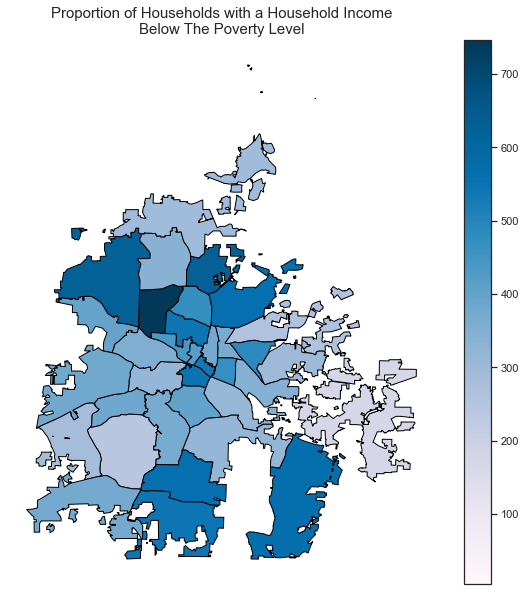

In [790]:
#Plot chloropleth map with merged data
fig, ax = plt.subplots(figsize = (10,10))
naturecallssummedinbeats.plot(column='calls_count2',
                                legend=True,
                                cmap="PuBu", ax=ax, aspect=1, edgecolor = 'black');

# ax.set(title='Number of Calls by Police Beat')
plt.title("Proportion of Households with a Household Income\nBelow The Poverty Level", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
ax.axis('off')
plt.show()

In [133]:
beats_callcount_pop_income_householdtype_race_age_poverty_nature = pd.merge(beats_callcount_pop_income_householdtype_race_age_poverty, naturecallssummedinbeats, on ='LAWBEAT')
beats_callcount_pop_income_householdtype_race_age_poverty_nature['naturecallcountperperson']= beats_callcount_pop_income_householdtype_race_age_poverty_nature['calls_count2'] / beats_callcount_pop_income_householdtype_race_age_poverty_nature['Total Population']
beats_callcount_pop_income_householdtype_race_age_poverty_nature['prop0to50']= beats_callcount_pop_income_householdtype_race_age_poverty_nature['prop0to25'] + beats_callcount_pop_income_householdtype_race_age_poverty_nature['prop25to50']
beats_callcount_pop_income_householdtype_race_age_poverty_nature.head(1)

NameError: name 'beats_callcount_pop_income_householdtype_race_age_poverty' is not defined

In [132]:
mapping_beats_callcount_pop_income_householdtype_race_age_poverty_nature = pd.merge(beats_callcount_pop_income_householdtype_race_age_poverty_nature, policebeats, on ='LAWBEAT')


NameError: name 'beats_callcount_pop_income_householdtype_race_age_poverty_nature' is not defined

In [792]:
stats.pearsonr(beats_callcount_pop_income_householdtype_race_age_poverty_nature['naturecallcountperperson'], beats_callcount_pop_income_householdtype_race_age_poverty_nature['avghouseholdsize'])


(-0.05835031805197534, 0.7430696988438849)

In [793]:
X = beats_callcount_pop_income_householdtype_race_age_poverty_nature[['propsingleparent', 'propblack', 'prop25to50']] # here we have 2 variables for multiple regression. If you just want to use one variable for simple linear regression, then use X = df['Interest_Rate'] for example.Alternatively, you may add additional variables within the brackets
Y = beats_callcount_pop_income_householdtype_race_age_poverty_nature['naturecallcountperperson']

regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 0.034703878824449856
Coefficients: 
 [ 0.42345806 -0.22138737 -0.18422136]


In [794]:
X = sm.add_constant(X) # adding a constant
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
print_model = model.summary()
print(print_model)

                               OLS Regression Results                               
Dep. Variable:     naturecallcountperperson   R-squared:                       0.513
Model:                                  OLS   Adj. R-squared:                  0.464
Method:                       Least Squares   F-statistic:                     10.53
Date:                      Wed, 20 Jul 2022   Prob (F-statistic):           6.80e-05
Time:                              16:33:44   Log-Likelihood:                 57.099
No. Observations:                        34   AIC:                            -106.2
Df Residuals:                            30   BIC:                            -100.1
Df Model:                                 3                                         
Covariance Type:                  nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------